<div align="center">

**Modelo de Detección y Conteo de Mamíferos Africanos a partir de Imágenes Aéreas**  

*Proyecto de Grado - Maestría en Inteligencia Artificial, Universidad de los Andes*  


**Autor:** Grupo 2  
**Institución:** Proyecto Guacamaya *(CINFONIA)*  
**Año:** 2025  


</div>

**Descripción general**:

Este cuaderno documenta el proceso completo de **entrenamiento y evaluación del modelo HerdNet**, diseñado para la **detección y conteo de mamíferos africanos** en imágenes aéreas, utilizando el *dataset* **ULiège**.


| Especie | Nombre común | Nombre científico / Inglés |
|:--|:--|:--|
| 🐃 | **Búfalo**  | *Buffalo* |
| 🐘 | **Elefante** | *Elephant* |
| 🦌 | **Kob** | *Kob* |
| 🦬 | **Topi (Alcelaphinae)** | *Topi / Hartebeest* |
| 🐗 | **Facóquero** | *Warthog* |
| 🦓 | **Waterbuck** | *Waterbuck* |



**Referencia técnica**:

Los experimentos y scripts se fundamentan en el cuaderno de referencia del repositorio oficial de **HerdNet**, disponible en:  
[https://colab.research.google.com/github/Alexandre-Delplanque/HerdNet/blob/main/notebooks/demo-training-testing-herdnet.ipynb](https://colab.research.google.com/github/Alexandre-Delplanque/HerdNet/blob/main/notebooks/demo-training-testing-herdnet.ipynb)

***Última actualización:*** 09 de Noviembre de 2025

</div>

# **Paso 1 - Entrenar HerdNet con Parches (train y val)**

## Instalación y configuración

### Google Drive (conexión) - NO NECESARIO CON DATASET LOCAL

**Nota:** Las siguientes celdas no son necesarias cuando el dataset ya está disponible en la carpeta `data` del proyecto. Se comentan para evitar dependencia de Google Drive.

In [1]:
# CELDA COMENTADA - NO NECESARIA CON DATASET LOCAL
# Esta celda solo es necesaria cuando se trabaja en Google Colab y se necesita
# descargar el dataset desde Google Drive

# import os
# import logging
# from IPython.display import clear_output
# from google.colab import drive

# class GoogleDriveConnector:
#     """
#     GoogleDriveConnector
#     --------------------
#     Clase para montar Google Drive en un entorno de Google Colab.
#     """
#     pass

print("[INFO] Celda de Google Drive omitida - usando dataset local en carpeta 'data'")


[INFO] Celda de Google Drive omitida - usando dataset local en carpeta 'data'


In [2]:
# CELDA COMENTADA - NO NECESARIA CON DATASET LOCAL
# Esta celda solo es necesaria cuando se trabaja en Google Colab

# # Conectar a Google Drive
# CONNECTOR = GoogleDriveConnector(
#     mount_path="/content/drive",
#     verbose=True,
# )
# CONNECTOR.mount_drive()

print("[INFO] Conexión a Google Drive omitida - usando dataset local")

[INFO] Conexión a Google Drive omitida - usando dataset local


### Instalación de librerías y repo de animaloc (HerdNet)

In [94]:
import os
import sys
import logging
import subprocess
from pathlib import Path
from IPython.display import clear_output

class ConfiguradorHerdNet:
    """
    Clase para configurar automáticamente el entorno de HerdNet,
    compatible tanto con Google Colab como con entornos locales.

    Propósito

    ----------
    Reproduce la instalación de HerdNet con detección de entorno,
    manejo de errores y registro de eventos mediante logging.

    Parámetros
    ----------
    base_dir : str, opcional
        Ruta donde se clonará el repositorio HerdNet.
        Por defecto: '/content/HerdNet' si se ejecuta en Colab,
        o './HerdNet' si se ejecuta localmente.
    verbose : bool, opcional
        Si es True, muestra información detallada del proceso.
    """

    def __init__(self, base_dir: str = None, verbose: bool = True):
        """Inicializa el configurador y detecta el entorno de ejecución."""
        # Detectar si se ejecuta en Colab
        self.is_colab = "google.colab" in sys.modules

        # Definir ruta base según entorno
        self.base_dir = Path(base_dir or ("/content/HerdNet" if self.is_colab else "../tools/HerdNet"))

        # Configurar logging estándar
        logging.basicConfig(
            level=logging.INFO,
            format="[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
            force=True
        )
        self.logger = logging.getLogger("ConfiguradorHerdNet")

        # Control de verbosidad
        self.verbose = verbose

    # ------------------------------------------------------------
    def _run_command(self, command: str):
        """
        Ejecuta un comando del sistema de forma segura.

        Parámetros
        ----------
        command : str
            Comando del sistema a ejecutar.

        Excepciones
        -----------
        subprocess.CalledProcessError
            Si el comando devuelve un error de ejecución.
        """
        try:
            result = subprocess.run(
                command,
                shell=True,
                check=True,
                text=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
            )
            if self.verbose and result.stdout.strip():
                self.logger.info(result.stdout.strip())
        except subprocess.CalledProcessError as e:
            self.logger.error(f"Error ejecutando comando: {command}")
            if e.stderr.strip():
                self.logger.error(e.stderr.strip())
            raise

    # ------------------------------------------------------------
    def verificar_gpu(self):
        """Verifica la disponibilidad de una GPU mediante nvidia-smi."""
        self.logger.info("Verificando GPU disponible...")
        try:
            self._run_command("nvidia-smi")
        except Exception:
            self.logger.warning("No se pudo verificar GPU. Puede que no exista o no esté disponible.")

    # ------------------------------------------------------------
    def instalar_dependencias(self):
        """
        Instala las dependencias necesarias según el entorno detectado.

        En Colab se instalan versiones recientes compatibles.
        En local se instalan las versiones exactas del paper HerdNet.
        """
        if self.is_colab:
            self.logger.info("Entorno detectado: Google Colab")
            self.logger.info("Instalando dependencias compatibles con Colab...")
            deps = (
                "albumentations fiftyone hydra-core opencv-python pandas pillow "
                "scikit-image scikit-learn scipy wandb"
            )
        else:
            self.logger.info("Entorno detectado: Local")
            self.logger.info("Instalando dependencias exactas del paper HerdNet...")
            deps = (
                "albumentations==1.0.3 fiftyone==0.14.3 hydra-core==1.1.0 "
                "opencv-python==4.5.1.48 pandas==1.2.3 pillow==8.2.0 "
                "scikit-image==0.18.1 scikit-learn==1.0.2 scipy==1.6.2 wandb==0.10.33"
            )

        cmd = f"{sys.executable} -m pip install {deps} -q"
        try:
            self._run_command(cmd)
        except Exception as e:
            self.logger.warning(f"Fallo parcial en instalación de dependencias: {e}")
            self.logger.warning("Continuando con el proceso...")

    # ------------------------------------------------------------
    def clonar_repo(self):
        """Clona e instala el repositorio HerdNet desde GitHub."""
        self.logger.info("Clonando repositorio HerdNet original...")
        if self.base_dir.exists():
            self.logger.info("El repositorio ya existe. Se omite la clonación.")
        else:
            self._run_command(f"git clone https://github.com/Alexandre-Delplanque/HerdNet {self.base_dir}")

        self._run_command(f"cd {self.base_dir} && {sys.executable} setup.py install -q")
        sys.path.append(str(self.base_dir))

    # ------------------------------------------------------------
    def limpiar_salida(self):
        """Limpia la salida si se ejecuta en Google Colab."""
        if self.is_colab:
            clear_output(wait=True)

    # ------------------------------------------------------------
    def configurar(self):
        """
        Ejecuta el flujo completo de configuración del entorno HerdNet.

        Incluye:
        - Verificación de GPU
        - Instalación de dependencias
        - Clonación del repositorio
        - Instalación local
        - Limpieza de salida (solo en Colab)
        """
        self.logger.info("Iniciando configuración del entorno HerdNet...")
        try:
            self.verificar_gpu()
            self.instalar_dependencias()
            self.clonar_repo()
            self.limpiar_salida()
            self.logger.info("Instalación completada correctamente y entorno listo.")
            print("Instalación completada correctamente y entorno listo.")
        except Exception as e:
            self.logger.error(f"Error durante la configuración: {e}")
            raise

In [95]:
# Instsalación de librerías y clonación de animaloc
configurador = ConfiguradorHerdNet(verbose=True)
configurador.configurar()

[2025-11-23 16:49:49] [INFO] Iniciando configuración del entorno HerdNet...
[2025-11-23 16:49:49] [INFO] Verificando GPU disponible...
[2025-11-23 16:49:50] [INFO] Sun Nov 23 16:49:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8              5W /  300W |   15755MiB /  16303MiB |

Instalación completada correctamente y entorno listo.


### Reinstalar animaloc (si hay error de importación)

**Nota:** Si encuentras un error `ZipImportError` al importar `animaloc`, ejecuta esta celda para reinstalar correctamente el paquete.

In [6]:
import subprocess
import sys

print("[INFO] Reinstalando animaloc (HerdNet) para corregir errores de importación...")

try:
    # Paso 1: Desinstalar animaloc si existe
    print("[1/3] Desinstalando animaloc existente...")
    subprocess.run(
        [sys.executable, "-m", "pip", "uninstall", "-y", "animaloc"],
        check=False,  # No fallar si no está instalado
        capture_output=True
    )
    
    # Paso 2: Limpiar caché de pip
    print("[2/3] Limpiando caché de pip...")
    subprocess.run(
        [sys.executable, "-m", "pip", "cache", "purge"],
        check=False,
        capture_output=True
    )
    
    # Paso 3: Clonar e instalar HerdNet desde el código fuente
    print("[3/3] Instalando HerdNet desde el código fuente...")
    
    # Verificar si ya existe el directorio HerdNet
    import os
    from pathlib import Path
    
    herdnet_dir = Path("./HerdNet")
    if herdnet_dir.exists():
        print("    - Directorio HerdNet ya existe, usando instalación existente...")
    else:
        print("    - Clonando repositorio HerdNet...")
        subprocess.run(
            ["git", "clone", "https://github.com/Alexandre-Delplanque/HerdNet", str(herdnet_dir)],
            check=True
        )
    
    # Instalar desde el código fuente
    print("    - Instalando desde código fuente...")
    subprocess.run(
        [sys.executable, "setup.py", "install"],
        cwd=str(herdnet_dir),
        check=True,
        capture_output=True
    )
    
    # Agregar al path si no está
    if str(herdnet_dir.resolve()) not in sys.path:
        sys.path.insert(0, str(herdnet_dir.resolve()))
    
    print("\n✅ [OK] animaloc reinstalado correctamente")
    print("[INFO] Ahora puedes continuar con las siguientes celdas")
    
except Exception as e:
    print(f"\n❌ [ERROR] Falló la reinstalación: {e}")
    print("\n[SOLUCIÓN ALTERNATIVA] Ejecuta estos comandos en tu terminal:")
    print("  1. pip uninstall -y animaloc")
    print("  2. git clone https://github.com/Alexandre-Delplanque/HerdNet")
    print("  3. cd HerdNet && python setup.py install")

[INFO] Reinstalando animaloc (HerdNet) para corregir errores de importación...
[1/3] Desinstalando animaloc existente...
[2/3] Limpiando caché de pip...
[3/3] Instalando HerdNet desde el código fuente...
    - Clonando repositorio HerdNet...


Cloning into 'HerdNet'...


    - Instalando desde código fuente...

✅ [OK] animaloc reinstalado correctamente
[INFO] Ahora puedes continuar con las siguientes celdas


### Fijar semilla

In [7]:
from animaloc.utils.seed import set_seed

class FijadorSemilla:
    """|
    FijadorSemilla
    ---------------
    Establece una semilla aleatoria determinística para los módulos de Python,
    NumPy y PyTorch, garantizando la reproducibilidad de los experimentos.

    Propósito
    ----------
    Proporcionar una interfaz unificada para fijar el valor de la semilla que
    utilizan los generadores aleatorios del entorno.

    Parámetros
    -----------
    seed : int
        Valor entero que se usará como semilla global.

    Ejemplo
    --------
    >>> fijador = FijadorSemilla(seed=9292)
    >>> fijador.aplicar()
    """

    def __init__(self, seed: int = 9292):
        # Guarda el valor de la semilla
        self.seed = seed

    def aplicar(self):
        """
        Aplica la semilla determinística en Python, NumPy y PyTorch.

        Retorno
        --------
        None
            El método no devuelve ningún valor; solo fija la semilla global.
        """
        # Fija la semilla de manera reproducible
        set_seed(self.seed)

        # Imprime confirmación
        print(f"Semilla aleatoria fijada en {self.seed}")

In [8]:
# Fijar semilla global
fijador = FijadorSemilla(seed=9292)
fijador.aplicar()

Semilla aleatoria fijada en 9292


## Configuración de rutas del dataset local

**Nota:** Esta celda configura las rutas para usar el dataset que ya está disponible localmente en la carpeta `data/` del proyecto, sin necesidad de descargarlo.


In [9]:
import os
from pathlib import Path

# Configurar ruta base del proyecto (detecta automáticamente si es Colab o local)
import sys
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    # En Colab, asumimos que el repositorio está clonado en /content/
    BASE_DIR = Path("/content/aerial-wildlife-count")
    DATA_DIR = BASE_DIR / "data"
else:
    # En entorno local, usar rutas relativas
    BASE_DIR = Path("..").resolve()  # Desde notebooks/ subir un nivel
    DATA_DIR = BASE_DIR / "data"

# Verificar que el dataset existe localmente
if not DATA_DIR.exists():
    print(f"[WARNING] No se encontró la carpeta de datos en: {DATA_DIR}")
    print("[INFO] Si estás en Colab, asegúrate de clonar el repositorio completo")
    print("[INFO] Si estás en local, verifica que la carpeta 'data' existe en el proyecto")
else:
    print(f"[OK] Dataset local encontrado en: {DATA_DIR}")
    
# Configurar rutas de los archivos del dataset
TRAIN_CSV = str(DATA_DIR / "train_patches.csv")
TRAIN_ROOT = str(DATA_DIR / "train_patches")
VAL_CSV = str(DATA_DIR / "val.csv")
VAL_ROOT = str(DATA_DIR / "val")
TEST_CSV = str(DATA_DIR / "test.csv")
TEST_ROOT = str(DATA_DIR / "test")

# Verificar que los archivos existen
print("\n[INFO] Verificando archivos del dataset:")
for name, path in [("Train CSV", TRAIN_CSV), ("Val CSV", VAL_CSV), ("Test CSV", TEST_CSV)]:
    exists = "✓" if os.path.exists(path) else "✗"
    print(f"  {exists} {name}: {path}")

for name, path in [("Train Root", TRAIN_ROOT), ("Val Root", VAL_ROOT), ("Test Root", TEST_ROOT)]:
    exists = "✓" if os.path.exists(path) else "✗"
    print(f"  {exists} {name}: {path}")

print("\n[INFO] Rutas configuradas y listas para usar")


[OK] Dataset local encontrado en: /home/rafael/aerial-wildlife-count/data

[INFO] Verificando archivos del dataset:
  ✓ Train CSV: /home/rafael/aerial-wildlife-count/data/train_patches.csv
  ✓ Val CSV: /home/rafael/aerial-wildlife-count/data/val.csv
  ✓ Test CSV: /home/rafael/aerial-wildlife-count/data/test.csv
  ✓ Train Root: /home/rafael/aerial-wildlife-count/data/train_patches
  ✓ Val Root: /home/rafael/aerial-wildlife-count/data/val
  ✓ Test Root: /home/rafael/aerial-wildlife-count/data/test

[INFO] Rutas configuradas y listas para usar


In [10]:
import os
import json
import logging
import pandas as pd
from tqdm import tqdm

class ConversorCOCOaHerdNet:
    """
    ConversorCOCOaHerdNet
    ---------------------
    Clase para convertir anotaciones en formato COCO JSON al formato CSV
    utilizado por HerdNet.

    Propósito
    ----------
    Facilita la conversión de anotaciones de detección (cajas o puntos)
    al formato CSV compatible con HerdNet, incluyendo coordenadas y etiquetas.

    Parámetros
    ----------
    ruta_json : str
        Ruta al archivo COCO JSON con las anotaciones.
    carpeta_imagenes : str
        Carpeta donde se encuentran las imágenes del dataset.
    ruta_salida : str
        Ruta donde se guardará el CSV resultante.
    verbose : bool, opcional
        Si es True, muestra mensajes detallados del proceso.
    """

    def __init__(self, ruta_json: str, carpeta_imagenes: str, ruta_salida: str, verbose: bool = True):
        """Inicializa el conversor con las rutas y la configuración."""
        self.ruta_json = ruta_json
        self.carpeta_imagenes = carpeta_imagenes
        self.ruta_salida = ruta_salida
        self.verbose = verbose

        # Configurar logger único por instancia
        logger_name = f"ConversorCOCOaHerdNet.{id(self)}"
        self.logger = logging.getLogger(logger_name)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)

        # Siempre eliminar handlers anteriores para evitar duplicaciones o silencios
        if self.logger.hasHandlers():
            self.logger.handlers.clear()

        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            "[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.propagate = False

        # Validar rutas iniciales
        self._validar_entradas()

    # ------------------------------------------------------------
    def _validar_entradas(self):
        """Verifica que las rutas de entrada sean válidas."""
        if not os.path.exists(self.ruta_json):
            raise FileNotFoundError(f"No se encontró el archivo de anotaciones: {self.ruta_json}")
        if not os.path.exists(self.carpeta_imagenes):
            raise FileNotFoundError(f"No se encontró la carpeta de imágenes: {self.carpeta_imagenes}")

    # ------------------------------------------------------------
    def _cargar_json(self) -> dict:
        """Carga el archivo COCO JSON de anotaciones."""
        self.logger.info("Cargando anotaciones COCO...")
        with open(self.ruta_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "images" not in data or "annotations" not in data:
            raise ValueError("El archivo JSON no tiene las claves requeridas: 'images' o 'annotations'.")

        self.logger.info(f"Imágenes detectadas: {len(data['images'])}")
        self.logger.info(f"Anotaciones detectadas: {len(data['annotations'])}")
        return data

    # ------------------------------------------------------------
    def _extraer_registros(self, coco: dict) -> pd.DataFrame:
        """Procesa las anotaciones COCO y genera un DataFrame con el formato HerdNet."""
        categorias = coco.get("categories", [])
        mapa_categorias = {cat["id"]: cat["name"] for cat in categorias}
        self.logger.info(f"Categorías detectadas: {mapa_categorias}")

        id_a_nombre = {img["id"]: img["file_name"] for img in coco["images"]}
        id_a_base = {img["id"]: os.path.splitext(img["file_name"])[0] for img in coco["images"]}

        registros = []

        for anotacion in tqdm(coco["annotations"], desc="Procesando anotaciones"):
            id_imagen = anotacion.get("image_id")
            id_categoria = anotacion.get("category_id")
            bbox = anotacion.get("bbox", None)
            keypoints = anotacion.get("keypoints", None)

            # Calcular punto central de la anotación
            if bbox:
                x, y, w, h = bbox
                cx, cy = x + w / 2, y + h / 2
            elif keypoints and len(keypoints) >= 2:
                cx, cy = keypoints[0], keypoints[1]
            else:
                continue

            nombre_imagen = id_a_nombre.get(id_imagen)
            nombre_base = id_a_base.get(id_imagen)
            if nombre_imagen is None:
                continue

            registros.append({
                "images": nombre_imagen,
                "labels": id_categoria,
                "base_images": nombre_base,
                "x": cx,
                "y": cy,
            })

        df = pd.DataFrame(registros)
        if df.empty:
            raise ValueError("No se generaron registros válidos a partir del archivo COCO.")

        # Validar y limpiar etiquetas no numéricas o nulas
        df["labels"] = pd.to_numeric(df["labels"], errors="coerce")
        filas_invalidas = df[df["labels"].isna()]
        if not filas_invalidas.empty:
            self.logger.warning(f"Se eliminaron {len(filas_invalidas)} anotaciones sin etiqueta válida.")
            df = df.dropna(subset=["labels"])

        # Convertir etiquetas a enteros seguros
        df["labels"] = df["labels"].astype(int)

        # Log de resumen de clases
        etiquetas_unicas = df["labels"].unique().tolist()
        self.logger.info(f"Etiquetas detectadas: {etiquetas_unicas}")

        return df

    # ------------------------------------------------------------
    def convertir(self) -> pd.DataFrame:
        """
        Ejecuta el proceso completo de conversión COCO -> HerdNet CSV.

        Retorna
        -------
        pd.DataFrame
            DataFrame final con las columnas esperadas.
        """
        self.logger.info("Iniciando conversión COCO -> HerdNet...")

        # Cargar anotaciones
        coco = self._cargar_json()

        # Extraer y validar registros
        df = self._extraer_registros(coco)

        # Crear carpeta de salida
        os.makedirs(os.path.dirname(self.ruta_salida), exist_ok=True)

        # Guardar CSV limpio
        df.to_csv(self.ruta_salida, index=False, sep=",", encoding="utf-8")

        self.logger.info(f"Conversión completada. CSV guardado en: {self.ruta_salida}")
        self.logger.info(f"Total de filas finales: {len(df)}")

### Función de limpieza de memoria (RAM y GPU)

**Propósito:** Liberar memoria RAM y VRAM de GPU durante la ejecución del notebook para evitar errores de memoria insuficiente.

In [132]:
import gc
import torch
import psutil
import os
import sys
import ctypes
from typing import Optional

def limpiar_memoria(verbose: bool = True, agresivo: bool = False) -> dict:
    """
    Libera memoria RAM y VRAM de GPU de manera MUY efectiva.
    
    Versión mejorada con técnicas avanzadas de liberación de memoria.
    
    Parámetros
    ----------
    verbose : bool, opcional
        Si es True, muestra estadísticas de memoria antes y después. Default: True
    agresivo : bool, opcional
        Si es True, realiza limpieza EXTREMADAMENTE agresiva. Default: False
        
    Retorna
    -------
    dict
        Diccionario con estadísticas de memoria liberada
    """
    
    # ========================================
    # 1. Capturar estado inicial
    # ========================================
    stats = {
        "ram_antes_mb": 0,
        "ram_despues_mb": 0,
        "ram_liberada_mb": 0,
        "gpu_antes_mb": [],
        "gpu_despues_mb": [],
        "gpu_liberada_mb": []
    }
    
    # Memoria RAM inicial
    proceso = psutil.Process(os.getpid())
    ram_antes = proceso.memory_info().rss / 1024 / 1024  # MB
    stats["ram_antes_mb"] = round(ram_antes, 2)
    
    # Memoria GPU inicial (si está disponible)
    if torch.cuda.is_available():
        gpu_antes = []
        for i in range(torch.cuda.device_count()):
            gpu_antes.append(torch.cuda.memory_allocated(i) / 1024 / 1024)
        stats["gpu_antes_mb"] = [round(x, 2) for x in gpu_antes]
    
    if verbose:
        print("=" * 60)
        print("🧹 LIMPIEZA DE MEMORIA - VERSIÓN MEJORADA")
        print("=" * 60)
        print(f"📊 RAM antes:  {stats['ram_antes_mb']:.2f} MB")
        if stats["gpu_antes_mb"]:
            for i, mem in enumerate(stats["gpu_antes_mb"]):
                print(f"🎮 GPU {i} antes: {mem:.2f} MB")
    
    # ========================================
    # 2. Limpieza AVANZADA de GPU (siempre)
    # ========================================
    
    if torch.cuda.is_available():
        if verbose:
            print("\n🎮 Limpiando memoria GPU...")
        
        # Sincronizar todas las operaciones pendientes
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.synchronize()
        
        # Vaciar cachés
        torch.cuda.empty_cache()
        
        # Limpiar IPC (Inter-Process Communication)
        try:
            torch.cuda.ipc_collect()
        except:
            pass
        
        # Resetear estadísticas de memoria
        try:
            for i in range(torch.cuda.device_count()):
                torch.cuda.reset_peak_memory_stats(i)
                torch.cuda.reset_accumulated_memory_stats(i)
        except:
            pass
    
    # ========================================
    # 3. Limpieza AGRESIVA de RAM
    # ========================================
    
    if verbose:
        print("📊 Limpiando memoria RAM...")
    
    # 3.1 Obtener namespace de IPython/Jupyter
    try:
        ipython = get_ipython()
        has_ipython = True
    except:
        ipython = None
        has_ipython = False
    
    if agresivo and has_ipython:
        if verbose:
            print("\n⚡ Modo AGRESIVO activado...")
        
        # Variables críticas a preservar
        preserve = {
            # Configuración del proyecto
            'BASE_DIR', 'DATA_DIR', 'TRAIN_CSV', 'VAL_CSV', 'TEST_CSV',
            'TRAIN_ROOT', 'VAL_ROOT', 'TEST_ROOT', 'IS_COLAB',
            # Modelos y entrenamiento
            'herdnet', 'trainer', 'optimizer', 'scheduler',
            'train_dataset', 'val_dataset', 'test_dataset',
            'train_dataloader', 'val_dataloader', 'test_dataloader',
            'train_evaluator', 'val_evaluator', 'test_evaluator',
            'stitcher', 'metrics',
            # Funciones y módulos
            'limpiar_memoria', 'limpiar_memoria_colab',
            'gc', 'torch', 'psutil', 'os', 'sys', 'ctypes',
            'get_ipython', 'ipython',
            # Configuraciones
            'work_dir', 'patch_size', 'num_classes', 'down_ratio',
            'epochs', 'lr', 'weight_decay', 'batch_size'
        }
        
        # Obtener todas las variables del usuario
        if hasattr(ipython, 'user_ns'):
            user_vars = list(ipython.user_ns.keys())
            deleted_count = 0
            
            for var_name in user_vars:
                # Saltar variables especiales y preservadas
                if var_name.startswith('_') or var_name in preserve:
                    continue
                
                # Saltar módulos y funciones built-in
                if var_name.startswith('__') or var_name in dir(__builtins__):
                    continue
                
                try:
                    var_obj = ipython.user_ns[var_name]
                    
                    # Eliminar listas grandes, diccionarios, tensores, etc.
                    should_delete = False
                    
                    if isinstance(var_obj, (list, dict, set, tuple)):
                        if sys.getsizeof(var_obj) > 100000:  # > 100KB
                            should_delete = True
                    
                    elif isinstance(var_obj, torch.Tensor):
                        should_delete = True
                    
                    elif hasattr(var_obj, '__sizeof__'):
                        try:
                            if var_obj.__sizeof__() > 500000:  # > 500KB
                                should_delete = True
                        except:
                            pass
                    
                    if should_delete:
                        del ipython.user_ns[var_name]
                        deleted_count += 1
                
                except:
                    continue
            
            if verbose and deleted_count > 0:
                print(f"   ├─ Eliminadas {deleted_count} variables temporales grandes")
        
        # Limpiar historial de outputs de IPython (esto libera MUCHA memoria)
        try:
            if hasattr(ipython, 'displayhook'):
                ipython.displayhook.flush()
            
            # Limpiar el caché de salidas (_oh, Out)
            if 'Out' in ipython.user_ns:
                ipython.user_ns['Out'].clear()
            if '_oh' in ipython.user_ns:
                ipython.user_ns['_oh'].clear()
            
            # Limpiar variables de resultado anteriores (_, __, ___)
            for var in ['_', '__', '___']:
                if var in ipython.user_ns:
                    try:
                        del ipython.user_ns[var]
                    except:
                        pass
            
            # Limpiar resultados numerados (_1, _2, _3, etc.)
            for var in list(ipython.user_ns.keys()):
                if var.startswith('_') and var[1:].isdigit():
                    try:
                        del ipython.user_ns[var]
                    except:
                        pass
            
            if verbose:
                print("   ├─ Historial de IPython limpiado")
        except:
            pass
    
    # ========================================
    # 4. Recolección de basura INTENSIVA
    # ========================================
    
    if verbose:
        print("   ├─ Ejecutando recolector de basura...")
    
    # Deshabilitar temporalmente el GC automático
    gc_was_enabled = gc.isenabled()
    gc.disable()
    
    # Múltiples pasadas de recolección
    collected_total = 0
    for generation in range(3):
        collected = gc.collect(generation)
        collected_total += collected
    
    # Una pasada final completa
    collected_total += gc.collect()
    
    # Restaurar estado del GC
    if gc_was_enabled:
        gc.enable()
    
    if verbose and collected_total > 0:
        print(f"   ├─ Recolectados {collected_total} objetos no referenciados")
    
    # ========================================
    # 5. Liberar memoria a nivel de sistema (Linux/Unix)
    # ========================================
    
    if agresivo:
        try:
            # En Linux, forzar liberación de memoria al sistema operativo
            if sys.platform.startswith('linux'):
                libc = ctypes.CDLL("libc.so.6")
                libc.malloc_trim(0)
                if verbose:
                    print("   ├─ Memoria devuelta al sistema operativo (malloc_trim)")
        except:
            pass
    
    # ========================================
    # 6. Limpieza final de GPU
    # ========================================
    
    if torch.cuda.is_available():
        # Sincronizar nuevamente
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
        
        if verbose:
            print("   └─ GPU sincronizada y caché limpiado")
    
    # ========================================
    # 7. Capturar estado final
    # ========================================
    
    # Esperar un momento para que el sistema actualice
    import time
    time.sleep(0.5)
    
    # Memoria RAM final
    ram_despues = proceso.memory_info().rss / 1024 / 1024  # MB
    stats["ram_despues_mb"] = round(ram_despues, 2)
    stats["ram_liberada_mb"] = round(ram_antes - ram_despues, 2)
    
    # Memoria GPU final
    if torch.cuda.is_available():
        gpu_despues = []
        gpu_liberada = []
        for i in range(torch.cuda.device_count()):
            mem_despues = torch.cuda.memory_allocated(i) / 1024 / 1024
            gpu_despues.append(mem_despues)
            gpu_liberada.append(gpu_antes[i] - mem_despues)
        stats["gpu_despues_mb"] = [round(x, 2) for x in gpu_despues]
        stats["gpu_liberada_mb"] = [round(x, 2) for x in gpu_liberada]
    
    # ========================================
    # 8. Mostrar resultados
    # ========================================
    
    if verbose:
        print("\n" + "=" * 60)
        print("✅ RESULTADOS")
        print("=" * 60)
        print(f"📊 RAM después: {stats['ram_despues_mb']:.2f} MB")
        if stats["ram_liberada_mb"] > 0:
            print(f"   └─ Liberada: {stats['ram_liberada_mb']:.2f} MB ✨")
        elif stats["ram_liberada_mb"] < 0:
            print(f"   └─ Aumentó: {abs(stats['ram_liberada_mb']):.2f} MB (normal durante ejecución)")
        else:
            print(f"   └─ Sin cambios significativos")
        
        if stats["gpu_despues_mb"]:
            for i, (mem, liberada) in enumerate(zip(stats["gpu_despues_mb"], stats["gpu_liberada_mb"])):
                print(f"🎮 GPU {i} después: {mem:.2f} MB")
                if liberada > 0:
                    print(f"   └─ Liberada: {liberada:.2f} MB ✨")
                else:
                    print(f"   └─ Sin cambios significativos")
        print("=" * 60 + "\n")
    
    return stats


# Alias para compatibilidad
limpiar_memoria_colab = limpiar_memoria

# Mensaje de confirmación
print("✅ Función limpiar_memoria() MEJORADA lista para usar")
print("\n🚀 MEJORAS:")
print("  • Limpieza de historial de IPython (libera MUCHA RAM)")
print("  • Eliminación de variables temporales más agresiva")
print("  • malloc_trim para devolver memoria al SO (Linux)")
print("  • Limpieza de caché de outputs de Jupyter")
print("\nUso:")
print("  • Limpieza básica:    limpiar_memoria()")
print("  • Limpieza EXTREMA:   limpiar_memoria(agresivo=True)")
print("  • Silenciosa:         limpiar_memoria(verbose=False)")


✅ Función limpiar_memoria() MEJORADA lista para usar

🚀 MEJORAS:
  • Limpieza de historial de IPython (libera MUCHA RAM)
  • Eliminación de variables temporales más agresiva
  • malloc_trim para devolver memoria al SO (Linux)
  • Limpieza de caché de outputs de Jupyter

Uso:
  • Limpieza básica:    limpiar_memoria()
  • Limpieza EXTREMA:   limpiar_memoria(agresivo=True)
  • Silenciosa:         limpiar_memoria(verbose=False)


### 💡 Cuándo usar la limpieza de memoria

**Recomendaciones:**

1. **Limpieza básica** (`limpiar_memoria()`):
   - Después de cargar datasets grandes
   - Después de cada época de entrenamiento
   - Antes de evaluación en conjunto de prueba
   - Cada vez que termines una sección del notebook

2. **Limpieza agresiva** (`limpiar_memoria(agresivo=True)`):
   - Después de completar todo el entrenamiento
   - Antes de comenzar una nueva fase (ej: Fase 2 con HNP)
   - Cuando recibas errores de "Out of Memory"
   - Al finalizar experimentos completos

3. **Limpieza silenciosa** (`limpiar_memoria(verbose=False)`):
   - Dentro de loops de entrenamiento
   - En scripts automatizados
   - Cuando solo necesites liberar memoria sin logs


In [133]:
# 🧪 PRUEBA LA FUNCIÓN (opcional - puedes ejecutar esta celda para probar)

# Ejemplo 1: Limpieza básica con estadísticas
# print("Ejemplo 1: Limpieza básica")
# stats = limpiar_memoria()
# print()

# Ejemplo 2: Limpieza agresiva (descomenta para usar)
print("Ejemplo 2: Limpieza agresiva")
stats = limpiar_memoria(agresivo=True)
print()

# Ejemplo 3: Limpieza silenciosa (sin output)
# stats = limpiar_memoria(verbose=False)
# print(f"Memoria RAM liberada: {stats['ram_liberada_mb']:.2f} MB")


Ejemplo 2: Limpieza agresiva
🧹 LIMPIEZA DE MEMORIA - VERSIÓN MEJORADA
📊 RAM antes:  4097.64 MB
🎮 GPU 0 antes: 15283.02 MB

🎮 Limpiando memoria GPU...
📊 Limpiando memoria RAM...

⚡ Modo AGRESIVO activado...
   ├─ Eliminadas 2 variables temporales grandes
   ├─ Historial de IPython limpiado
   ├─ Ejecutando recolector de basura...
   ├─ Memoria devuelta al sistema operativo (malloc_trim)
   └─ GPU sincronizada y caché limpiado

✅ RESULTADOS
📊 RAM después: 3971.10 MB
   └─ Liberada: 126.54 MB ✨
🎮 GPU 0 después: 551.47 MB
   └─ Liberada: 14731.55 MB ✨




### Liberar memoria

In [134]:
import gc
import os
import torch
import psutil

def limpiar_memoria_colab():
    """
    Libera memoria RAM y GPU en entornos como Google Colab.

    Pasos:
        1. Vacía la caché de GPU si está disponible.
        2. Elimina variables grandes del entorno global.
        3. Fuerza la recolección de basura.
        4. Muestra el uso actual de RAM y GPU.

    Retorna:
        None
    """
    print("[INFO] Liberando memoria...")

    # 1. Vaciar caché de GPU si está disponible
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        print("[INFO] Memoria GPU vaciada.")

    # 2. Eliminar variables grandes del entorno global
    global_vars = list(globals().keys())
    for var in global_vars:
        if var not in {"os", "torch", "gc", "psutil", "limpiar_memoria_colab"}:
            globals().pop(var, None)  # Uso seguro de pop para evitar errores
    gc.collect()

    # 3. Verificar uso de RAM
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 ** 2
    print(f"[INFO] Memoria RAM usada actualmente: {memory_mb:.2f} MB")

    # 4. Mostrar estado de GPU (comando del sistema)
    if torch.cuda.is_available():
        os.system("nvidia-smi")

    print("[OK] Limpieza completa")

In [135]:
# Liberar memoria y chequear GPU
limpiar_memoria_colab()

!nvidia-smi

[INFO] Liberando memoria...
[INFO] Memoria GPU vaciada.
[INFO] Memoria RAM usada actualmente: 3971.10 MB
Sun Nov 23 17:08:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:01:00.0 Off |                  N/A |
|  0%   34C    P5             13W /  300W |    4981MiB /  16303MiB |      0%      Default |
|                                  

## Descargar datasets

In [15]:
import os
import subprocess
from pathlib import Path
from animaloc.utils.useful_funcs import mkdir

class DelplanqueDatasetManager:
    """
    Clase para gestionar la descarga y preparación del conjunto de datos
    de Delplanque et al. (2021) en entornos como Google Colab.

    Esta clase permite:
        1. Descargar el archivo ZIP del dataset.
        2. Extraer su contenido en la carpeta indicada.
        3. Crear los parches de validación usando el script oficial de HerdNet.

    Parámetros
    ----------
    url_id : str
        ID de Google Drive del dataset a descargar.
    output_dir : str
        Ruta base donde se guardará y extraerá el dataset.
    herdnet_path : str
        Ruta a la carpeta del repositorio HerdNet.
    verbose : bool, opcional
        Si es True, imprime mensajes informativos en consola. Por defecto es True.
    """

    def __init__(self, url_id: str, output_dir: str, herdnet_path: str, verbose: bool = True):
        self.url_id = url_id
        self.output_dir = Path(output_dir)
        self.herdnet_path = Path(herdnet_path)
        self.zip_path = self.output_dir / "data.zip"
        self.verbose = verbose

        # Crear carpeta base si no existe
        
        self.output_dir.mkdir(parents=True, exist_ok=True)

    def _run_command(self, command: str):
        """
        Ejecuta un comando del sistema y muestra salida si verbose=True.
        """
        if self.verbose:
            print(f"[INFO] Ejecutando: {command}")
        subprocess.run(command, shell=True, check=True)

    def download_dataset(self):
        """
        Descarga el dataset desde Google Drive mediante gdown.
        """
        print("[INFO] Descargando dataset de Delplanque et al. (2021)...")
        command = f"gdown {self.url_id} -O {self.zip_path}"
        self._run_command(command)
        print("[OK] Descarga completada.")

    def extract_dataset(self):
        """
        Extrae el archivo ZIP descargado en la carpeta de salida.
        """
        print("[INFO] Extrayendo contenido del ZIP...")
        command = f"unzip -oq {self.zip_path} -d {self.output_dir}"
        self._run_command(command)
        print("[OK] Extracción completada.")

    def create_validation_patches(self, patch_size: int = 512, min_value: float = 0.0, use_all: bool = False):
        """
        Crea los parches de validación utilizando el script patcher.py del repositorio HerdNet.

        Parámetros
        ----------
        patch_size : int
            Tamaño de los parches en píxeles (por defecto 512).
        min_value : float
            Valor mínimo de área o intensidad para mantener el parche (por defecto 0.0).
        use_all : bool
            Si es False, crea solo una muestra; si es True, crea todos los parches posibles.
        """
        print("[INFO] Creando parches de validación...")
        val_dir = self.output_dir / "val"
        patches_dir = self.output_dir / "val_patches"
        csv_path = self.output_dir / "val.csv"

        # Crear carpeta de salida para los parches
        mkdir(str(patches_dir))

        # Ejecutar script oficial de HerdNet
        command = (
            f"python {self.herdnet_path}/tools/patcher.py "
            f"{val_dir} {patch_size} {patch_size} 0 {patches_dir} "
            f"-csv {csv_path} -min {min_value} -all {use_all}"
        )
        self._run_command(command)
        print("[OK] Parches de validación generados correctamente.")

    def prepare_full_dataset(self):
        """
        Ejecuta el flujo completo de descarga, extracción y generación de parches.
        """
        if not self.output_dir.exists():
            self.download_dataset()
            self.extract_dataset()
        
        self.create_validation_patches()
        print("[DONE] Dataset preparado correctamente.")

# Descargar datasets y generar parches de validación
manager = DelplanqueDatasetManager(
    url_id="1CcTAZZJdwrBfCPJtVH6VBU3luGKIN9st",
    output_dir="../data",
    herdnet_path="../tools/HerdNet",
    verbose=True,
)
manager.prepare_full_dataset()

[INFO] Creando parches de validación...
[INFO] Ejecutando: python ../tools/HerdNet/tools/patcher.py ../data/val 512 512 0 ../data/val_patches -csv ../data/val.csv -min 0.0 -all False


Exporting patches: 100%|██████████| 111/111 [00:56<00:00,  1.95it/s]


[OK] Parches de validación generados correctamente.
[DONE] Dataset preparado correctamente.


## Crear datasets y dataloaders

In [16]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )
        return train_dataset, val_dataset, test_dataset

In [17]:
# Crear instancia de la clase
builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv", # contiene parches
    train_root="../data/train_patches",  # contiene parches
    val_csv="../data/val_patches/gt.csv", # contiene parches
    val_root="../data/val_patches", # contiene parches
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=False,       # False = Fase 1 sin HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

# Construir los datasets
train_dataset, val_dataset, test_dataset = builder.build()

In [18]:
# Dataloaders
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = 1, shuffle = False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

print(f"[INFO] Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

[INFO] Train: 7765 | Val: 532 | Test: 258


## Definir arquitectura

In [153]:
# Crear la carpeta de checkpoints (si no existe)
!mkdir -p /home/rafael/.cache/torch/hub/checkpoints/
herdnet = HerdNet(pretrained=True, num_classes=7, down_ratio=2)
!ls -la "/home/rafael/.cache/torch/hub/checkpoints"

total 61756
drwxr-xr-x 2 rafael rafael     4096 Nov 23 22:51 .
drwxr-xr-x 3 rafael rafael     4096 Nov 15 20:40 ..
-rw-r--r-- 1 rafael rafael 63228658 Nov 23 22:51 dla34-ba72cf86.pth


In [20]:
from animaloc.models import HerdNet
from torch import Tensor
from animaloc.models import LossWrapper
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss

num_classes = 7
down_ratio = 2

herdnet = HerdNet(pretrained=True, num_classes=num_classes, down_ratio=down_ratio).cuda()

weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

losses = [
    {'loss': FocalLoss(reduction='mean'), 'idx': 0, 'idy': 0, 'lambda': 1.0, 'name': 'focal_loss'},
    {'loss': CrossEntropyLoss(reduction='mean', weight=weight), 'idx': 1, 'idy': 1, 'lambda': 1.0, 'name': 'ce_loss'}
    ]

herdnet = LossWrapper(herdnet, losses=losses)

## Crear el Trainer

In [21]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

# Crear carpeta de trabajo donde se guardarán los modelos entrenados
work_dir = "../workspace/HerdNet/fase_1/models"
mkdir(work_dir)

# Definir hiperparámetros principales del entrenamiento
lr = 1e-4                 # Tasa de aprendizaje del optimizador
weight_decay = 1e-3       # Factor de regularización L2 para evitar sobreajuste
epochs = 1              # Número total de épocas de entrenamiento
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial de la red
num_classes = 7           # Número total de clases a predecir

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Definir las métricas de evaluación basadas en puntos (detección y conteo)
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que une los parches de salida del modelo
# para reconstruir los mapas completos de densidad o detección
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches consecutivos
    down_ratio=down_ratio,  # Coincide con la reducción interna del modelo
    reduction="mean"        # Método de agregación entre parches superpuestos
)

# Crear el evaluador que calculará las métricas de desempeño en validación
evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,  # Conjunto de datos de validación
    metrics=metrics,            # Métricas definidas anteriormente
    stitcher=stitcher,          # Stitcher encargado de unir las predicciones
    work_dir=work_dir,          # Carpeta donde se guardan resultados
    header="validation"         # Prefijo usado para nombrar archivos de salida
)

# Crear el entrenador principal que gestiona el bucle de entrenamiento
trainer = Trainer(
    model=herdnet,              # Modelo HerdNet envuelto con pérdidas
    train_dataloader=train_dataloader,  # Datos de entrenamiento
    optimizer=optimizer,        # Optimizador Adam definido
    num_epochs=epochs,          # Número total de épocas
    evaluator=evaluator,        # Evaluador para medir desempeño durante el entrenamiento
    work_dir=work_dir           # Carpeta donde se almacenan modelos y logs
)


## Entrenamiento

In [22]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='f1_score');

[2025-11-23 11:42:31] [INFO] [TRAINING] - Epoch: [1] [  1/486] eta: 0:09:17 lr: 0.000002 loss: 9281.7490 (9281.7490) focal_loss: 9279.7471 (9279.7471) ce_loss: 2.0017 (2.0017) time: 1.1466 data: 0.2682 max mem: 8659


[TRAINING] - Epoch: [1] [  1/486] eta: 0:09:17 lr: 0.000002 loss: 9281.7490 (9281.7490) focal_loss: 9279.7471 (9279.7471) ce_loss: 2.0017 (2.0017) time: 1.1466 data: 0.2682 max mem: 8659


[2025-11-23 11:42:55] [INFO] [TRAINING] - Epoch: [1] [ 51/486] eta: 0:03:34 lr: 0.000051 loss: 6085.3975 (7629.9234) focal_loss: 6083.5415 (7628.1344) ce_loss: 1.6608 (1.7890) time: 0.4920 data: 0.2641 max mem: 8802


[TRAINING] - Epoch: [1] [ 51/486] eta: 0:03:34 lr: 0.000051 loss: 6085.3975 (7629.9234) focal_loss: 6083.5415 (7628.1344) ce_loss: 1.6608 (1.7890) time: 0.4920 data: 0.2641 max mem: 8802


[2025-11-23 11:43:20] [INFO] [TRAINING] - Epoch: [1] [101/486] eta: 0:03:10 lr: 0.000100 loss: 1227.9105 (5057.7577) focal_loss: 1226.2113 (5056.1150) ce_loss: 1.4196 (1.6427) time: 0.5044 data: 0.2759 max mem: 8802


[TRAINING] - Epoch: [1] [101/486] eta: 0:03:10 lr: 0.000100 loss: 1227.9105 (5057.7577) focal_loss: 1226.2113 (5056.1150) ce_loss: 1.4196 (1.6427) time: 0.5044 data: 0.2759 max mem: 8802


[2025-11-23 11:43:45] [INFO] [TRAINING] - Epoch: [1] [151/486] eta: 0:02:48 lr: 0.000100 loss: 268.6468 (3523.0179) focal_loss: 267.1276 (3521.4527) ce_loss: 1.4933 (1.5652) time: 0.4985 data: 0.2701 max mem: 8802


[TRAINING] - Epoch: [1] [151/486] eta: 0:02:48 lr: 0.000100 loss: 268.6468 (3523.0179) focal_loss: 267.1276 (3521.4527) ce_loss: 1.4933 (1.5652) time: 0.4985 data: 0.2701 max mem: 8802


[2025-11-23 11:44:11] [INFO] [TRAINING] - Epoch: [1] [201/486] eta: 0:02:23 lr: 0.000100 loss: 120.8772 (2684.8174) focal_loss: 119.8228 (2683.3006) ce_loss: 1.3029 (1.5168) time: 0.5554 data: 0.3260 max mem: 8802


[TRAINING] - Epoch: [1] [201/486] eta: 0:02:23 lr: 0.000100 loss: 120.8772 (2684.8174) focal_loss: 119.8228 (2683.3006) ce_loss: 1.3029 (1.5168) time: 0.5554 data: 0.3260 max mem: 8802


[2025-11-23 11:44:35] [INFO] [TRAINING] - Epoch: [1] [251/486] eta: 0:01:57 lr: 0.000100 loss: 72.2594 (2166.7619) focal_loss: 71.1125 (2165.2867) ce_loss: 1.2410 (1.4751) time: 0.4707 data: 0.2423 max mem: 8802


[TRAINING] - Epoch: [1] [251/486] eta: 0:01:57 lr: 0.000100 loss: 72.2594 (2166.7619) focal_loss: 71.1125 (2165.2867) ce_loss: 1.2410 (1.4751) time: 0.4707 data: 0.2423 max mem: 8802


[2025-11-23 11:44:57] [INFO] [TRAINING] - Epoch: [1] [301/486] eta: 0:01:30 lr: 0.000100 loss: 47.1582 (1815.7241) focal_loss: 45.9745 (1814.2916) ce_loss: 1.1357 (1.4325) time: 0.4514 data: 0.2228 max mem: 8802


[TRAINING] - Epoch: [1] [301/486] eta: 0:01:30 lr: 0.000100 loss: 47.1582 (1815.7241) focal_loss: 45.9745 (1814.2916) ce_loss: 1.1357 (1.4325) time: 0.4514 data: 0.2228 max mem: 8802


[2025-11-23 11:45:21] [INFO] [TRAINING] - Epoch: [1] [351/486] eta: 0:01:06 lr: 0.000100 loss: 33.9101 (1562.4274) focal_loss: 32.5756 (1561.0180) ce_loss: 1.2581 (1.4094) time: 0.4791 data: 0.2502 max mem: 8802


[TRAINING] - Epoch: [1] [351/486] eta: 0:01:06 lr: 0.000100 loss: 33.9101 (1562.4274) focal_loss: 32.5756 (1561.0180) ce_loss: 1.2581 (1.4094) time: 0.4791 data: 0.2502 max mem: 8802


[2025-11-23 11:45:46] [INFO] [TRAINING] - Epoch: [1] [401/486] eta: 0:00:41 lr: 0.000100 loss: 26.0185 (1371.1389) focal_loss: 24.9730 (1369.7603) ce_loss: 1.0906 (1.3786) time: 0.4846 data: 0.2555 max mem: 8802


[TRAINING] - Epoch: [1] [401/486] eta: 0:00:41 lr: 0.000100 loss: 26.0185 (1371.1389) focal_loss: 24.9730 (1369.7603) ce_loss: 1.0906 (1.3786) time: 0.4846 data: 0.2555 max mem: 8802


[2025-11-23 11:46:10] [INFO] [TRAINING] - Epoch: [1] [451/486] eta: 0:00:17 lr: 0.000100 loss: 20.6662 (1221.5607) focal_loss: 19.6781 (1220.2091) ce_loss: 1.0749 (1.3516) time: 0.4862 data: 0.2573 max mem: 8802


[TRAINING] - Epoch: [1] [451/486] eta: 0:00:17 lr: 0.000100 loss: 20.6662 (1221.5607) focal_loss: 19.6781 (1220.2091) ce_loss: 1.0749 (1.3516) time: 0.4862 data: 0.2573 max mem: 8802


[2025-11-23 11:46:27] [INFO] [TRAINING] - Epoch: [1] [486/486] eta: 0:00:00 lr: 0.000100 loss: 18.1185 (1134.9293) focal_loss: 17.0442 (1133.5942) ce_loss: 1.0836 (1.3351) time: 0.4861 data: 0.2642 max mem: 8802
[2025-11-23 11:46:27] [INFO] [TRAINING] - Epoch: [1] Total time: 0:03:57 (0.4880 s / it)
[2025-11-23 11:46:27] [INFO] [VALIDATION] - Epoch: [1] [  1/532] eta: 0:01:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1732.0 MSE: 2999824.0 RMSE: 1732.0 time: 0.1156 data: 0.0043 max mem: 8802


[TRAINING] - Epoch: [1] [486/486] eta: 0:00:00 lr: 0.000100 loss: 18.1185 (1134.9293) focal_loss: 17.0442 (1133.5942) ce_loss: 1.0836 (1.3351) time: 0.4861 data: 0.2642 max mem: 8802
[TRAINING] - Epoch: [1] Total time: 0:03:57 (0.4880 s / it)
[TRAINING] - Epoch: [1] mean loss: 1134.9292
[VALIDATION] - Epoch: [1] [  1/532] eta: 0:01:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1732.0 MSE: 2999824.0 RMSE: 1732.0 time: 0.1156 data: 0.0043 max mem: 8802


[2025-11-23 11:46:27] [INFO] [VALIDATION] - Epoch: [1] [ 11/532] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1481.0 MSE: 2193361.0 RMSE: 1481.0 time: 0.0415 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 11/532] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1481.0 MSE: 2193361.0 RMSE: 1481.0 time: 0.0415 data: 0.0042 max mem: 8802


[2025-11-23 11:46:28] [INFO] [VALIDATION] - Epoch: [1] [ 21/532] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 677.0 MSE: 458329.0 RMSE: 677.0 time: 0.0378 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 21/532] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 677.0 MSE: 458329.0 RMSE: 677.0 time: 0.0378 data: 0.0042 max mem: 8802


[2025-11-23 11:46:28] [INFO] [VALIDATION] - Epoch: [1] [ 31/532] eta: 0:00:19 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.0373 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 31/532] eta: 0:00:19 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.0373 data: 0.0042 max mem: 8802


[2025-11-23 11:46:29] [INFO] [VALIDATION] - Epoch: [1] [ 41/532] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1921.0 MSE: 3690241.0 RMSE: 1921.0 time: 0.0341 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 41/532] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1921.0 MSE: 3690241.0 RMSE: 1921.0 time: 0.0341 data: 0.0042 max mem: 8802


[2025-11-23 11:46:29] [INFO] [VALIDATION] - Epoch: [1] [ 51/532] eta: 0:00:18 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1147.0 MSE: 1315609.0 RMSE: 1147.0 time: 0.0384 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [ 51/532] eta: 0:00:18 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1147.0 MSE: 1315609.0 RMSE: 1147.0 time: 0.0384 data: 0.0043 max mem: 8802


[2025-11-23 11:46:29] [INFO] [VALIDATION] - Epoch: [1] [ 61/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1079.0 MSE: 1164241.0 RMSE: 1079.0 time: 0.0381 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 61/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1079.0 MSE: 1164241.0 RMSE: 1079.0 time: 0.0381 data: 0.0042 max mem: 8802


[2025-11-23 11:46:30] [INFO] [VALIDATION] - Epoch: [1] [ 71/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.0346 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [ 71/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.0346 data: 0.0042 max mem: 8802


[2025-11-23 11:46:30] [INFO] [VALIDATION] - Epoch: [1] [ 81/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1450.0 MSE: 2102500.0 RMSE: 1450.0 time: 0.0392 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [ 81/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1450.0 MSE: 2102500.0 RMSE: 1450.0 time: 0.0392 data: 0.0043 max mem: 8802


[2025-11-23 11:46:30] [INFO] [VALIDATION] - Epoch: [1] [ 91/532] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 539.0 MSE: 290521.0 RMSE: 539.0 time: 0.0387 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [ 91/532] eta: 0:00:16 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 539.0 MSE: 290521.0 RMSE: 539.0 time: 0.0387 data: 0.0043 max mem: 8802


[2025-11-23 11:46:31] [INFO] [VALIDATION] - Epoch: [1] [101/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1259.0 MSE: 1585081.0 RMSE: 1259.0 time: 0.0348 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [101/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1259.0 MSE: 1585081.0 RMSE: 1259.0 time: 0.0348 data: 0.0043 max mem: 8802


[2025-11-23 11:46:31] [INFO] [VALIDATION] - Epoch: [1] [111/532] eta: 0:00:15 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1092.0 MSE: 1192464.0 RMSE: 1092.0 time: 0.0356 data: 0.0045 max mem: 8802


[VALIDATION] - Epoch: [1] [111/532] eta: 0:00:15 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1092.0 MSE: 1192464.0 RMSE: 1092.0 time: 0.0356 data: 0.0045 max mem: 8802


[2025-11-23 11:46:32] [INFO] [VALIDATION] - Epoch: [1] [121/532] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.0417 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [121/532] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.0417 data: 0.0044 max mem: 8802


[2025-11-23 11:46:32] [INFO] [VALIDATION] - Epoch: [1] [131/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1116.0 MSE: 1245456.0 RMSE: 1116.0 time: 0.0415 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [131/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1116.0 MSE: 1245456.0 RMSE: 1116.0 time: 0.0415 data: 0.0044 max mem: 8802


[2025-11-23 11:46:32] [INFO] [VALIDATION] - Epoch: [1] [141/532] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 907.0 MSE: 822649.0 RMSE: 907.0 time: 0.0357 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [141/532] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 907.0 MSE: 822649.0 RMSE: 907.0 time: 0.0357 data: 0.0044 max mem: 8802


[2025-11-23 11:46:33] [INFO] [VALIDATION] - Epoch: [1] [151/532] eta: 0:00:14 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 536.0 MSE: 287296.0 RMSE: 536.0 time: 0.0407 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [151/532] eta: 0:00:14 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 536.0 MSE: 287296.0 RMSE: 536.0 time: 0.0407 data: 0.0043 max mem: 8802


[2025-11-23 11:46:33] [INFO] [VALIDATION] - Epoch: [1] [161/532] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 622.0 MSE: 386884.0 RMSE: 622.0 time: 0.0402 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [161/532] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 622.0 MSE: 386884.0 RMSE: 622.0 time: 0.0402 data: 0.0043 max mem: 8802


[2025-11-23 11:46:34] [INFO] [VALIDATION] - Epoch: [1] [171/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1886.0 MSE: 3556996.0 RMSE: 1886.0 time: 0.0361 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [171/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1886.0 MSE: 3556996.0 RMSE: 1886.0 time: 0.0361 data: 0.0044 max mem: 8802


[2025-11-23 11:46:34] [INFO] [VALIDATION] - Epoch: [1] [181/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1058.0 MSE: 1119364.0 RMSE: 1058.0 time: 0.0369 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [181/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1058.0 MSE: 1119364.0 RMSE: 1058.0 time: 0.0369 data: 0.0043 max mem: 8802


[2025-11-23 11:46:34] [INFO] [VALIDATION] - Epoch: [1] [191/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 958.0 MSE: 917764.0 RMSE: 958.0 time: 0.0419 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [191/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 958.0 MSE: 917764.0 RMSE: 958.0 time: 0.0419 data: 0.0043 max mem: 8802


[2025-11-23 11:46:35] [INFO] [VALIDATION] - Epoch: [1] [201/532] eta: 0:00:12 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1337.0 MSE: 1787569.0 RMSE: 1337.0 time: 0.0429 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [201/532] eta: 0:00:12 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1337.0 MSE: 1787569.0 RMSE: 1337.0 time: 0.0429 data: 0.0043 max mem: 8802


[2025-11-23 11:46:35] [INFO] [VALIDATION] - Epoch: [1] [211/532] eta: 0:00:12 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1108.0 MSE: 1227664.0 RMSE: 1108.0 time: 0.0380 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [211/532] eta: 0:00:12 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1108.0 MSE: 1227664.0 RMSE: 1108.0 time: 0.0380 data: 0.0044 max mem: 8802


[2025-11-23 11:46:36] [INFO] [VALIDATION] - Epoch: [1] [221/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 640.0 MSE: 409600.0 RMSE: 640.0 time: 0.0375 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [221/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 640.0 MSE: 409600.0 RMSE: 640.0 time: 0.0375 data: 0.0044 max mem: 8802


[2025-11-23 11:46:36] [INFO] [VALIDATION] - Epoch: [1] [231/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1418.0 MSE: 2010724.0 RMSE: 1418.0 time: 0.0437 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [231/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1418.0 MSE: 2010724.0 RMSE: 1418.0 time: 0.0437 data: 0.0044 max mem: 8802


[2025-11-23 11:46:36] [INFO] [VALIDATION] - Epoch: [1] [241/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 967.0 MSE: 935089.0 RMSE: 967.0 time: 0.0446 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [241/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 967.0 MSE: 935089.0 RMSE: 967.0 time: 0.0446 data: 0.0043 max mem: 8802


[2025-11-23 11:46:37] [INFO] [VALIDATION] - Epoch: [1] [251/532] eta: 0:00:10 n: 5 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 876.0 MSE: 767376.0 RMSE: 876.0 time: 0.0400 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [251/532] eta: 0:00:10 n: 5 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 876.0 MSE: 767376.0 RMSE: 876.0 time: 0.0400 data: 0.0043 max mem: 8802


[2025-11-23 11:46:37] [INFO] [VALIDATION] - Epoch: [1] [261/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 675.0 MSE: 455625.0 RMSE: 675.0 time: 0.0447 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [261/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 675.0 MSE: 455625.0 RMSE: 675.0 time: 0.0447 data: 0.0043 max mem: 8802


[2025-11-23 11:46:38] [INFO] [VALIDATION] - Epoch: [1] [271/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1817.0 MSE: 3301489.0 RMSE: 1817.0 time: 0.0442 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [271/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1817.0 MSE: 3301489.0 RMSE: 1817.0 time: 0.0442 data: 0.0043 max mem: 8802


[2025-11-23 11:46:38] [INFO] [VALIDATION] - Epoch: [1] [281/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0394 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [281/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0394 data: 0.0043 max mem: 8802


[2025-11-23 11:46:39] [INFO] [VALIDATION] - Epoch: [1] [291/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 547.0 MSE: 299209.0 RMSE: 547.0 time: 0.0393 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [291/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 547.0 MSE: 299209.0 RMSE: 547.0 time: 0.0393 data: 0.0043 max mem: 8802


[2025-11-23 11:46:39] [INFO] [VALIDATION] - Epoch: [1] [301/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1480.0 MSE: 2190400.0 RMSE: 1480.0 time: 0.0398 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [301/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1480.0 MSE: 2190400.0 RMSE: 1480.0 time: 0.0398 data: 0.0043 max mem: 8802


[2025-11-23 11:46:39] [INFO] [VALIDATION] - Epoch: [1] [311/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 978.0 MSE: 956484.0 RMSE: 978.0 time: 0.0459 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [311/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 978.0 MSE: 956484.0 RMSE: 978.0 time: 0.0459 data: 0.0043 max mem: 8802


[2025-11-23 11:46:40] [INFO] [VALIDATION] - Epoch: [1] [321/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1679.0 MSE: 2819041.0 RMSE: 1679.0 time: 0.0466 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [321/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1679.0 MSE: 2819041.0 RMSE: 1679.0 time: 0.0466 data: 0.0044 max mem: 8802


[2025-11-23 11:46:40] [INFO] [VALIDATION] - Epoch: [1] [331/532] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 842.0 MSE: 708964.0 RMSE: 842.0 time: 0.0411 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [331/532] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 842.0 MSE: 708964.0 RMSE: 842.0 time: 0.0411 data: 0.0044 max mem: 8802


[2025-11-23 11:46:41] [INFO] [VALIDATION] - Epoch: [1] [341/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 726.0 MSE: 527076.0 RMSE: 726.0 time: 0.0408 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [341/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 726.0 MSE: 527076.0 RMSE: 726.0 time: 0.0408 data: 0.0044 max mem: 8802


[2025-11-23 11:46:41] [INFO] [VALIDATION] - Epoch: [1] [351/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1286.0 MSE: 1653796.0 RMSE: 1286.0 time: 0.0423 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [351/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1286.0 MSE: 1653796.0 RMSE: 1286.0 time: 0.0423 data: 0.0044 max mem: 8802


[2025-11-23 11:46:42] [INFO] [VALIDATION] - Epoch: [1] [361/532] eta: 0:00:06 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 804.0 MSE: 646416.0 RMSE: 804.0 time: 0.0486 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [361/532] eta: 0:00:06 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 804.0 MSE: 646416.0 RMSE: 804.0 time: 0.0486 data: 0.0044 max mem: 8802


[2025-11-23 11:46:42] [INFO] [VALIDATION] - Epoch: [1] [371/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1539.0 MSE: 2368521.0 RMSE: 1539.0 time: 0.0480 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [371/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1539.0 MSE: 2368521.0 RMSE: 1539.0 time: 0.0480 data: 0.0043 max mem: 8802


[2025-11-23 11:46:42] [INFO] [VALIDATION] - Epoch: [1] [381/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1610.0 MSE: 2592100.0 RMSE: 1610.0 time: 0.0423 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [381/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1610.0 MSE: 2592100.0 RMSE: 1610.0 time: 0.0423 data: 0.0043 max mem: 8802


[2025-11-23 11:46:43] [INFO] [VALIDATION] - Epoch: [1] [391/532] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 869.0 MSE: 755161.0 RMSE: 869.0 time: 0.0421 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [391/532] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 869.0 MSE: 755161.0 RMSE: 869.0 time: 0.0421 data: 0.0043 max mem: 8802


[2025-11-23 11:46:43] [INFO] [VALIDATION] - Epoch: [1] [401/532] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 598.0 MSE: 357604.0 RMSE: 598.0 time: 0.0429 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [401/532] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 598.0 MSE: 357604.0 RMSE: 598.0 time: 0.0429 data: 0.0043 max mem: 8802


[2025-11-23 11:46:44] [INFO] [VALIDATION] - Epoch: [1] [411/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 463.0 MSE: 214369.0 RMSE: 463.0 time: 0.0497 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [411/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 463.0 MSE: 214369.0 RMSE: 463.0 time: 0.0497 data: 0.0043 max mem: 8802


[2025-11-23 11:46:44] [INFO] [VALIDATION] - Epoch: [1] [421/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 880.0 MSE: 774400.0 RMSE: 880.0 time: 0.0502 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [421/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 880.0 MSE: 774400.0 RMSE: 880.0 time: 0.0502 data: 0.0043 max mem: 8802


[2025-11-23 11:46:45] [INFO] [VALIDATION] - Epoch: [1] [431/532] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1349.0 MSE: 1819801.0 RMSE: 1349.0 time: 0.0444 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [431/532] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1349.0 MSE: 1819801.0 RMSE: 1349.0 time: 0.0444 data: 0.0043 max mem: 8802


[2025-11-23 11:46:45] [INFO] [VALIDATION] - Epoch: [1] [441/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 813.0 MSE: 660969.0 RMSE: 813.0 time: 0.0447 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [441/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 813.0 MSE: 660969.0 RMSE: 813.0 time: 0.0447 data: 0.0044 max mem: 8802


[2025-11-23 11:46:46] [INFO] [VALIDATION] - Epoch: [1] [451/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1599.0 MSE: 2556801.0 RMSE: 1599.0 time: 0.0512 data: 0.0044 max mem: 8802


[VALIDATION] - Epoch: [1] [451/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1599.0 MSE: 2556801.0 RMSE: 1599.0 time: 0.0512 data: 0.0044 max mem: 8802


[2025-11-23 11:46:46] [INFO] [VALIDATION] - Epoch: [1] [461/532] eta: 0:00:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1250.0 MSE: 1562500.0 RMSE: 1250.0 time: 0.0517 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [461/532] eta: 0:00:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1250.0 MSE: 1562500.0 RMSE: 1250.0 time: 0.0517 data: 0.0043 max mem: 8802


[2025-11-23 11:46:47] [INFO] [VALIDATION] - Epoch: [1] [471/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1591.0 MSE: 2531281.0 RMSE: 1591.0 time: 0.0468 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [471/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1591.0 MSE: 2531281.0 RMSE: 1591.0 time: 0.0468 data: 0.0043 max mem: 8802


[2025-11-23 11:46:47] [INFO] [VALIDATION] - Epoch: [1] [481/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0458 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [481/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0458 data: 0.0043 max mem: 8802


[2025-11-23 11:46:48] [INFO] [VALIDATION] - Epoch: [1] [491/532] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 846.0 MSE: 715716.0 RMSE: 846.0 time: 0.0453 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [491/532] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 846.0 MSE: 715716.0 RMSE: 846.0 time: 0.0453 data: 0.0043 max mem: 8802


[2025-11-23 11:46:48] [INFO] [VALIDATION] - Epoch: [1] [501/532] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1149.0 MSE: 1320201.0 RMSE: 1149.0 time: 0.0529 data: 0.0043 max mem: 8802


[VALIDATION] - Epoch: [1] [501/532] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1149.0 MSE: 1320201.0 RMSE: 1149.0 time: 0.0529 data: 0.0043 max mem: 8802


[2025-11-23 11:46:49] [INFO] [VALIDATION] - Epoch: [1] [511/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 492.0 MSE: 242064.0 RMSE: 492.0 time: 0.0522 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [511/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 492.0 MSE: 242064.0 RMSE: 492.0 time: 0.0522 data: 0.0042 max mem: 8802


[2025-11-23 11:46:49] [INFO] [VALIDATION] - Epoch: [1] [521/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1017.0 MSE: 1034289.0 RMSE: 1017.0 time: 0.0451 data: 0.0042 max mem: 8802


[VALIDATION] - Epoch: [1] [521/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1017.0 MSE: 1034289.0 RMSE: 1017.0 time: 0.0451 data: 0.0042 max mem: 8802


[2025-11-23 11:46:50] [INFO] [VALIDATION] - Epoch: [1] [531/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1323.0 MSE: 1750329.0 RMSE: 1323.0 time: 0.0456 data: 0.0043 max mem: 8802
[2025-11-23 11:46:50] [INFO] [VALIDATION] - Epoch: [1] [532/532] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0454 data: 0.0043 max mem: 8802
[2025-11-23 11:46:50] [INFO] [VALIDATION] - Epoch: [1] Total time: 0:00:22 (0.0426 s / it)


[VALIDATION] - Epoch: [1] [531/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1323.0 MSE: 1750329.0 RMSE: 1323.0 time: 0.0456 data: 0.0043 max mem: 8802
[VALIDATION] - Epoch: [1] [532/532] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0454 data: 0.0043 max mem: 8802
[VALIDATION] - Epoch: [1] Total time: 0:00:22 (0.0426 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.0031
Best model saved - Epoch 1 - Validation value: 0.003119


## Evaluar el modelo

### Config

In [23]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_1/models/best_model.pth"
)

### Val

In [24]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear la carpeta de salida para guardar resultados de validación
val_dir = "../workspace/HerdNet/fase_1/evaluation_val"
mkdir(val_dir)

# Definir hiperparámetros principales del entrenamiento y evaluación
lr = 1e-4                 # Tasa de aprendizaje
weight_decay = 1e-3       # Factor de regularización L2
epochs = 100              # Número de épocas de entrenamiento
num_classes = 7           # Número de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar el conjunto de métricas para evaluar detecciones y conteos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye las predicciones a nivel de imagen completa
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,             # Superposición entre parches consecutivos
    down_ratio=down_ratio,   # Coincide con la reducción del modelo
    reduction="mean"         # Método de agregación de resultados superpuestos
)

# Crear el evaluador de validación, encargado de medir desempeño del modelo
val_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=val_dir,
    header="val"             # Prefijo usado en los archivos de salida
)

# Definir el entrenador principal con su evaluador y configuración general
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=val_evaluator,
    work_dir=val_dir
)

In [25]:
# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = val_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 11:46:54] [INFO] val [  1/532] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1732.0 MSE: 2999824.0 RMSE: 1732.0 time: 0.0358 data: 0.0046 max mem: 8802


val [  1/532] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1732.0 MSE: 2999824.0 RMSE: 1732.0 time: 0.0358 data: 0.0046 max mem: 8802


[2025-11-23 11:46:54] [INFO] val [ 11/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1481.0 MSE: 2193361.0 RMSE: 1481.0 time: 0.0342 data: 0.0044 max mem: 8802


val [ 11/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1481.0 MSE: 2193361.0 RMSE: 1481.0 time: 0.0342 data: 0.0044 max mem: 8802


[2025-11-23 11:46:54] [INFO] val [ 21/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 677.0 MSE: 458329.0 RMSE: 677.0 time: 0.0333 data: 0.0043 max mem: 8802


val [ 21/532] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 677.0 MSE: 458329.0 RMSE: 677.0 time: 0.0333 data: 0.0043 max mem: 8802


[2025-11-23 11:46:55] [INFO] val [ 31/532] eta: 0:00:16 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.0335 data: 0.0046 max mem: 8802


val [ 31/532] eta: 0:00:16 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.0335 data: 0.0046 max mem: 8802


[2025-11-23 11:46:55] [INFO] val [ 41/532] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1921.0 MSE: 3690241.0 RMSE: 1921.0 time: 0.0431 data: 0.0046 max mem: 8802


val [ 41/532] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1921.0 MSE: 3690241.0 RMSE: 1921.0 time: 0.0431 data: 0.0046 max mem: 8802


[2025-11-23 11:46:56] [INFO] val [ 51/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1147.0 MSE: 1315609.0 RMSE: 1147.0 time: 0.0428 data: 0.0043 max mem: 8802


val [ 51/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1147.0 MSE: 1315609.0 RMSE: 1147.0 time: 0.0428 data: 0.0043 max mem: 8802


[2025-11-23 11:46:56] [INFO] val [ 61/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1079.0 MSE: 1164241.0 RMSE: 1079.0 time: 0.0341 data: 0.0043 max mem: 8802


val [ 61/532] eta: 0:00:17 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1079.0 MSE: 1164241.0 RMSE: 1079.0 time: 0.0341 data: 0.0043 max mem: 8802


[2025-11-23 11:46:56] [INFO] val [ 71/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.0347 data: 0.0043 max mem: 8802


val [ 71/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.0347 data: 0.0043 max mem: 8802


[2025-11-23 11:46:57] [INFO] val [ 81/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1450.0 MSE: 2102500.0 RMSE: 1450.0 time: 0.0351 data: 0.0043 max mem: 8802


val [ 81/532] eta: 0:00:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1450.0 MSE: 2102500.0 RMSE: 1450.0 time: 0.0351 data: 0.0043 max mem: 8802


[2025-11-23 11:46:57] [INFO] val [ 91/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 539.0 MSE: 290521.0 RMSE: 539.0 time: 0.0347 data: 0.0043 max mem: 8802


val [ 91/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 539.0 MSE: 290521.0 RMSE: 539.0 time: 0.0347 data: 0.0043 max mem: 8802


[2025-11-23 11:46:57] [INFO] val [101/532] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1259.0 MSE: 1585081.0 RMSE: 1259.0 time: 0.0351 data: 0.0044 max mem: 8802


val [101/532] eta: 0:00:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1259.0 MSE: 1585081.0 RMSE: 1259.0 time: 0.0351 data: 0.0044 max mem: 8802


[2025-11-23 11:46:58] [INFO] val [111/532] eta: 0:00:15 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1092.0 MSE: 1192464.0 RMSE: 1092.0 time: 0.0360 data: 0.0044 max mem: 8802


val [111/532] eta: 0:00:15 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1092.0 MSE: 1192464.0 RMSE: 1092.0 time: 0.0360 data: 0.0044 max mem: 8802


[2025-11-23 11:46:58] [INFO] val [121/532] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.0367 data: 0.0044 max mem: 8802


val [121/532] eta: 0:00:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.0367 data: 0.0044 max mem: 8802


[2025-11-23 11:46:59] [INFO] val [131/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1116.0 MSE: 1245456.0 RMSE: 1116.0 time: 0.0445 data: 0.0044 max mem: 8802


val [131/532] eta: 0:00:15 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1116.0 MSE: 1245456.0 RMSE: 1116.0 time: 0.0445 data: 0.0044 max mem: 8802


[2025-11-23 11:46:59] [INFO] val [141/532] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 907.0 MSE: 822649.0 RMSE: 907.0 time: 0.0445 data: 0.0044 max mem: 8802


val [141/532] eta: 0:00:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 907.0 MSE: 822649.0 RMSE: 907.0 time: 0.0445 data: 0.0044 max mem: 8802


[2025-11-23 11:46:59] [INFO] val [151/532] eta: 0:00:14 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 536.0 MSE: 287296.0 RMSE: 536.0 time: 0.0368 data: 0.0044 max mem: 8802


val [151/532] eta: 0:00:14 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 536.0 MSE: 287296.0 RMSE: 536.0 time: 0.0368 data: 0.0044 max mem: 8802


[2025-11-23 11:47:00] [INFO] val [161/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 622.0 MSE: 386884.0 RMSE: 622.0 time: 0.0363 data: 0.0044 max mem: 8802


val [161/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 622.0 MSE: 386884.0 RMSE: 622.0 time: 0.0363 data: 0.0044 max mem: 8802


[2025-11-23 11:47:00] [INFO] val [171/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1886.0 MSE: 3556996.0 RMSE: 1886.0 time: 0.0370 data: 0.0044 max mem: 8802


val [171/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1886.0 MSE: 3556996.0 RMSE: 1886.0 time: 0.0370 data: 0.0044 max mem: 8802


[2025-11-23 11:47:00] [INFO] val [181/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1058.0 MSE: 1119364.0 RMSE: 1058.0 time: 0.0377 data: 0.0044 max mem: 8802


val [181/532] eta: 0:00:13 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1058.0 MSE: 1119364.0 RMSE: 1058.0 time: 0.0377 data: 0.0044 max mem: 8802


[2025-11-23 11:47:01] [INFO] val [191/532] eta: 0:00:12 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 958.0 MSE: 917764.0 RMSE: 958.0 time: 0.0381 data: 0.0044 max mem: 8802


val [191/532] eta: 0:00:12 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 958.0 MSE: 917764.0 RMSE: 958.0 time: 0.0381 data: 0.0044 max mem: 8802


[2025-11-23 11:47:01] [INFO] val [201/532] eta: 0:00:12 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1337.0 MSE: 1787569.0 RMSE: 1337.0 time: 0.0389 data: 0.0044 max mem: 8802


val [201/532] eta: 0:00:12 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1337.0 MSE: 1787569.0 RMSE: 1337.0 time: 0.0389 data: 0.0044 max mem: 8802


[2025-11-23 11:47:02] [INFO] val [211/532] eta: 0:00:12 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1108.0 MSE: 1227664.0 RMSE: 1108.0 time: 0.0392 data: 0.0044 max mem: 8802


val [211/532] eta: 0:00:12 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1108.0 MSE: 1227664.0 RMSE: 1108.0 time: 0.0392 data: 0.0044 max mem: 8802


[2025-11-23 11:47:02] [INFO] val [221/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 640.0 MSE: 409600.0 RMSE: 640.0 time: 0.0387 data: 0.0044 max mem: 8802


val [221/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 640.0 MSE: 409600.0 RMSE: 640.0 time: 0.0387 data: 0.0044 max mem: 8802


[2025-11-23 11:47:03] [INFO] val [231/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1418.0 MSE: 2010724.0 RMSE: 1418.0 time: 0.0483 data: 0.0044 max mem: 8802


val [231/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1418.0 MSE: 2010724.0 RMSE: 1418.0 time: 0.0483 data: 0.0044 max mem: 8802


[2025-11-23 11:47:03] [INFO] val [241/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 967.0 MSE: 935089.0 RMSE: 967.0 time: 0.0493 data: 0.0044 max mem: 8802


val [241/532] eta: 0:00:11 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 967.0 MSE: 935089.0 RMSE: 967.0 time: 0.0493 data: 0.0044 max mem: 8802


[2025-11-23 11:47:03] [INFO] val [251/532] eta: 0:00:10 n: 5 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 876.0 MSE: 767376.0 RMSE: 876.0 time: 0.0409 data: 0.0044 max mem: 8802


val [251/532] eta: 0:00:10 n: 5 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 876.0 MSE: 767376.0 RMSE: 876.0 time: 0.0409 data: 0.0044 max mem: 8802


[2025-11-23 11:47:04] [INFO] val [261/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 675.0 MSE: 455625.0 RMSE: 675.0 time: 0.0410 data: 0.0044 max mem: 8802


val [261/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 675.0 MSE: 455625.0 RMSE: 675.0 time: 0.0410 data: 0.0044 max mem: 8802


[2025-11-23 11:47:04] [INFO] val [271/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1817.0 MSE: 3301489.0 RMSE: 1817.0 time: 0.0405 data: 0.0043 max mem: 8802


val [271/532] eta: 0:00:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1817.0 MSE: 3301489.0 RMSE: 1817.0 time: 0.0405 data: 0.0043 max mem: 8802


[2025-11-23 11:47:05] [INFO] val [281/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0407 data: 0.0044 max mem: 8802


val [281/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0407 data: 0.0044 max mem: 8802


[2025-11-23 11:47:05] [INFO] val [291/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 547.0 MSE: 299209.0 RMSE: 547.0 time: 0.0400 data: 0.0044 max mem: 8802


val [291/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 547.0 MSE: 299209.0 RMSE: 547.0 time: 0.0400 data: 0.0044 max mem: 8802


[2025-11-23 11:47:05] [INFO] val [301/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1480.0 MSE: 2190400.0 RMSE: 1480.0 time: 0.0398 data: 0.0043 max mem: 8802


val [301/532] eta: 0:00:09 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1480.0 MSE: 2190400.0 RMSE: 1480.0 time: 0.0398 data: 0.0043 max mem: 8802


[2025-11-23 11:47:06] [INFO] val [311/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 978.0 MSE: 956484.0 RMSE: 978.0 time: 0.0405 data: 0.0043 max mem: 8802


val [311/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 978.0 MSE: 956484.0 RMSE: 978.0 time: 0.0405 data: 0.0043 max mem: 8802


[2025-11-23 11:47:06] [INFO] val [321/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1679.0 MSE: 2819041.0 RMSE: 1679.0 time: 0.0414 data: 0.0043 max mem: 8802


val [321/532] eta: 0:00:08 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1679.0 MSE: 2819041.0 RMSE: 1679.0 time: 0.0414 data: 0.0043 max mem: 8802


[2025-11-23 11:47:07] [INFO] val [331/532] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 842.0 MSE: 708964.0 RMSE: 842.0 time: 0.0509 data: 0.0044 max mem: 8802


val [331/532] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 842.0 MSE: 708964.0 RMSE: 842.0 time: 0.0509 data: 0.0044 max mem: 8802


[2025-11-23 11:47:07] [INFO] val [341/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 726.0 MSE: 527076.0 RMSE: 726.0 time: 0.0505 data: 0.0043 max mem: 8802


val [341/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 726.0 MSE: 527076.0 RMSE: 726.0 time: 0.0505 data: 0.0043 max mem: 8802


[2025-11-23 11:47:08] [INFO] val [351/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1286.0 MSE: 1653796.0 RMSE: 1286.0 time: 0.0419 data: 0.0043 max mem: 8802


val [351/532] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1286.0 MSE: 1653796.0 RMSE: 1286.0 time: 0.0419 data: 0.0043 max mem: 8802


[2025-11-23 11:47:08] [INFO] val [361/532] eta: 0:00:06 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 804.0 MSE: 646416.0 RMSE: 804.0 time: 0.0427 data: 0.0043 max mem: 8802


val [361/532] eta: 0:00:06 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 804.0 MSE: 646416.0 RMSE: 804.0 time: 0.0427 data: 0.0043 max mem: 8802


[2025-11-23 11:47:09] [INFO] val [371/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1539.0 MSE: 2368521.0 RMSE: 1539.0 time: 0.0433 data: 0.0042 max mem: 8802


val [371/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1539.0 MSE: 2368521.0 RMSE: 1539.0 time: 0.0433 data: 0.0042 max mem: 8802


[2025-11-23 11:47:09] [INFO] val [381/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1610.0 MSE: 2592100.0 RMSE: 1610.0 time: 0.0433 data: 0.0042 max mem: 8802


val [381/532] eta: 0:00:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1610.0 MSE: 2592100.0 RMSE: 1610.0 time: 0.0433 data: 0.0042 max mem: 8802


[2025-11-23 11:47:09] [INFO] val [391/532] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 869.0 MSE: 755161.0 RMSE: 869.0 time: 0.0431 data: 0.0042 max mem: 8802


val [391/532] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 869.0 MSE: 755161.0 RMSE: 869.0 time: 0.0431 data: 0.0042 max mem: 8802


[2025-11-23 11:47:10] [INFO] val [401/532] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 598.0 MSE: 357604.0 RMSE: 598.0 time: 0.0437 data: 0.0043 max mem: 8802


val [401/532] eta: 0:00:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 598.0 MSE: 357604.0 RMSE: 598.0 time: 0.0437 data: 0.0043 max mem: 8802


[2025-11-23 11:47:10] [INFO] val [411/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 463.0 MSE: 214369.0 RMSE: 463.0 time: 0.0445 data: 0.0043 max mem: 8802


val [411/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 463.0 MSE: 214369.0 RMSE: 463.0 time: 0.0445 data: 0.0043 max mem: 8802


[2025-11-23 11:47:11] [INFO] val [421/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 880.0 MSE: 774400.0 RMSE: 880.0 time: 0.0451 data: 0.0044 max mem: 8802


val [421/532] eta: 0:00:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 880.0 MSE: 774400.0 RMSE: 880.0 time: 0.0451 data: 0.0044 max mem: 8802


[2025-11-23 11:47:11] [INFO] val [431/532] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1349.0 MSE: 1819801.0 RMSE: 1349.0 time: 0.0453 data: 0.0044 max mem: 8802


val [431/532] eta: 0:00:04 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1349.0 MSE: 1819801.0 RMSE: 1349.0 time: 0.0453 data: 0.0044 max mem: 8802


[2025-11-23 11:47:12] [INFO] val [441/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 813.0 MSE: 660969.0 RMSE: 813.0 time: 0.0562 data: 0.0044 max mem: 8802


val [441/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 813.0 MSE: 660969.0 RMSE: 813.0 time: 0.0562 data: 0.0044 max mem: 8802


[2025-11-23 11:47:12] [INFO] val [451/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1599.0 MSE: 2556801.0 RMSE: 1599.0 time: 0.0565 data: 0.0044 max mem: 8802


val [451/532] eta: 0:00:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1599.0 MSE: 2556801.0 RMSE: 1599.0 time: 0.0565 data: 0.0044 max mem: 8802


[2025-11-23 11:47:13] [INFO] val [461/532] eta: 0:00:02 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1250.0 MSE: 1562500.0 RMSE: 1250.0 time: 0.0463 data: 0.0043 max mem: 8802


val [461/532] eta: 0:00:02 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1250.0 MSE: 1562500.0 RMSE: 1250.0 time: 0.0463 data: 0.0043 max mem: 8802


[2025-11-23 11:47:13] [INFO] val [471/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1591.0 MSE: 2531281.0 RMSE: 1591.0 time: 0.0472 data: 0.0043 max mem: 8802


val [471/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1591.0 MSE: 2531281.0 RMSE: 1591.0 time: 0.0472 data: 0.0043 max mem: 8802


[2025-11-23 11:47:14] [INFO] val [481/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0463 data: 0.0043 max mem: 8802


val [481/532] eta: 0:00:02 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 809.0 MSE: 654481.0 RMSE: 809.0 time: 0.0463 data: 0.0043 max mem: 8802


[2025-11-23 11:47:14] [INFO] val [491/532] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 846.0 MSE: 715716.0 RMSE: 846.0 time: 0.0458 data: 0.0043 max mem: 8802


val [491/532] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 846.0 MSE: 715716.0 RMSE: 846.0 time: 0.0458 data: 0.0043 max mem: 8802


[2025-11-23 11:47:15] [INFO] val [501/532] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1149.0 MSE: 1320201.0 RMSE: 1149.0 time: 0.0468 data: 0.0042 max mem: 8802


val [501/532] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1149.0 MSE: 1320201.0 RMSE: 1149.0 time: 0.0468 data: 0.0042 max mem: 8802


[2025-11-23 11:47:15] [INFO] val [511/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 492.0 MSE: 242064.0 RMSE: 492.0 time: 0.0464 data: 0.0042 max mem: 8802


val [511/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 492.0 MSE: 242064.0 RMSE: 492.0 time: 0.0464 data: 0.0042 max mem: 8802


[2025-11-23 11:47:16] [INFO] val [521/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1017.0 MSE: 1034289.0 RMSE: 1017.0 time: 0.0460 data: 0.0042 max mem: 8802


val [521/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1017.0 MSE: 1034289.0 RMSE: 1017.0 time: 0.0460 data: 0.0042 max mem: 8802


[2025-11-23 11:47:16] [INFO] val [531/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1323.0 MSE: 1750329.0 RMSE: 1323.0 time: 0.0463 data: 0.0042 max mem: 8802
[2025-11-23 11:47:16] [INFO] val [532/532] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0461 data: 0.0042 max mem: 8802
[2025-11-23 11:47:16] [INFO] val Total time: 0:00:22 (0.0422 s / it)


val [531/532] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1323.0 MSE: 1750329.0 RMSE: 1323.0 time: 0.0463 data: 0.0042 max mem: 8802
val [532/532] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1174.0 MSE: 1378276.0 RMSE: 1174.0 time: 0.0461 data: 0.0042 max mem: 8802
val Total time: 0:00:22 (0.0422 s / it)
F1 score = 0%


In [26]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = val_evaluator.results
print(metrics_val)

    class    n    recall  precision  f1_score  confusion          mae  \
0       1  368  0.217391   0.011484  0.021816   0.782016    24.455516   
1       2  102  0.960784   0.001469  0.002934   0.039216   175.696570   
2       3  161  0.782609   0.006434  0.012763   0.217391    84.238095   
3       4   43  0.465116   0.000079  0.000158   0.534884   499.039448   
4       5   39  0.384615   0.001106  0.002205   0.615385    63.013953   
5       6  264  0.787879   0.000791  0.001579   0.203065   551.052411   
6  binary  977  0.995906   0.001562  0.003119   0.000000  1169.178571   

            mse         rmse        ap  
0  1.889552e+03    43.468973  0.004886  
1  7.254599e+04   269.343622  0.032014  
2  1.437059e+04   119.877409  0.017578  
3  3.841195e+05   619.773759  0.000581  
4  1.406099e+04   118.579029  0.004849  
5  5.483674e+05   740.518355  0.005383  
6  1.545366e+06  1243.127650  0.007909  


### Test

In [27]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_1/evaluation_test"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
epochs = 100              # Número de épocas (para consistencia con entrenamiento)
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

# Ignorar advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación sobre el conjunto de prueba y obtener el F1-score
test_f1_score = test_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 11:47:25] [INFO] test [  1/258] eta: 0:08:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 77825.0 MSE: 6056730625.0 RMSE: 77825.0 time: 1.8754 data: 0.3915 max mem: 8802


test [  1/258] eta: 0:08:03 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 77825.0 MSE: 6056730625.0 RMSE: 77825.0 time: 1.8754 data: 0.3915 max mem: 8802


[2025-11-23 11:47:49] [INFO] test [ 11/258] eta: 0:09:44 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 83549.0 MSE: 6980435401.0 RMSE: 83549.0 time: 2.3571 data: 0.3856 max mem: 8802


test [ 11/258] eta: 0:09:44 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 83549.0 MSE: 6980435401.0 RMSE: 83549.0 time: 2.3571 data: 0.3856 max mem: 8802


[2025-11-23 11:48:13] [INFO] test [ 21/258] eta: 0:09:22 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 84660.0 MSE: 7167315600.0 RMSE: 84660.0 time: 2.3893 data: 0.3838 max mem: 8802


test [ 21/258] eta: 0:09:22 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 84660.0 MSE: 7167315600.0 RMSE: 84660.0 time: 2.3893 data: 0.3838 max mem: 8802


[2025-11-23 11:48:37] [INFO] test [ 31/258] eta: 0:09:01 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 122811.0 MSE: 15082541721.0 RMSE: 122811.0 time: 2.3815 data: 0.3834 max mem: 8802


test [ 31/258] eta: 0:09:01 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 122811.0 MSE: 15082541721.0 RMSE: 122811.0 time: 2.3815 data: 0.3834 max mem: 8802


[2025-11-23 11:49:00] [INFO] test [ 41/258] eta: 0:08:35 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 119860.0 MSE: 14366419600.0 RMSE: 119860.0 time: 2.3607 data: 0.3827 max mem: 8802


test [ 41/258] eta: 0:08:35 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 119860.0 MSE: 14366419600.0 RMSE: 119860.0 time: 2.3607 data: 0.3827 max mem: 8802


[2025-11-23 11:49:23] [INFO] test [ 51/258] eta: 0:08:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 68067.0 MSE: 4633116489.0 RMSE: 68067.0 time: 2.3060 data: 0.3828 max mem: 8802


test [ 51/258] eta: 0:08:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 68067.0 MSE: 4633116489.0 RMSE: 68067.0 time: 2.3060 data: 0.3828 max mem: 8802


[2025-11-23 11:49:47] [INFO] test [ 61/258] eta: 0:07:46 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 107690.0 MSE: 11597136100.0 RMSE: 107690.0 time: 2.3390 data: 0.3842 max mem: 8802


test [ 61/258] eta: 0:07:46 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 107690.0 MSE: 11597136100.0 RMSE: 107690.0 time: 2.3390 data: 0.3842 max mem: 8802


[2025-11-23 11:50:11] [INFO] test [ 71/258] eta: 0:07:22 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 137142.0 MSE: 18807928164.0 RMSE: 137142.0 time: 2.3774 data: 0.3837 max mem: 8802


test [ 71/258] eta: 0:07:22 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 137142.0 MSE: 18807928164.0 RMSE: 137142.0 time: 2.3774 data: 0.3837 max mem: 8802


[2025-11-23 11:50:34] [INFO] test [ 81/258] eta: 0:06:57 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 120764.0 MSE: 14583943696.0 RMSE: 120764.0 time: 2.3255 data: 0.3838 max mem: 8802


test [ 81/258] eta: 0:06:57 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 120764.0 MSE: 14583943696.0 RMSE: 120764.0 time: 2.3255 data: 0.3838 max mem: 8802


[2025-11-23 11:50:56] [INFO] test [ 91/258] eta: 0:06:32 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 67341.0 MSE: 4534810281.0 RMSE: 67341.0 time: 2.2590 data: 0.3844 max mem: 8802


test [ 91/258] eta: 0:06:32 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 67341.0 MSE: 4534810281.0 RMSE: 67341.0 time: 2.2590 data: 0.3844 max mem: 8802


[2025-11-23 11:51:20] [INFO] test [101/258] eta: 0:06:10 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75583.0 MSE: 5712789889.0 RMSE: 75583.0 time: 2.3321 data: 0.3834 max mem: 8802


test [101/258] eta: 0:06:10 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75583.0 MSE: 5712789889.0 RMSE: 75583.0 time: 2.3321 data: 0.3834 max mem: 8802


[2025-11-23 11:51:46] [INFO] test [111/258] eta: 0:05:49 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100880.0 MSE: 10176774400.0 RMSE: 100880.0 time: 2.4889 data: 0.3834 max mem: 8802


test [111/258] eta: 0:05:49 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100880.0 MSE: 10176774400.0 RMSE: 100880.0 time: 2.4889 data: 0.3834 max mem: 8802


[2025-11-23 11:52:10] [INFO] test [121/258] eta: 0:05:26 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 102506.0 MSE: 10507480036.0 RMSE: 102506.0 time: 2.4939 data: 0.3857 max mem: 8802


test [121/258] eta: 0:05:26 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 102506.0 MSE: 10507480036.0 RMSE: 102506.0 time: 2.4939 data: 0.3857 max mem: 8802


[2025-11-23 11:52:36] [INFO] test [131/258] eta: 0:05:05 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 115483.0 MSE: 13336323289.0 RMSE: 115483.0 time: 2.5221 data: 0.3903 max mem: 8802


test [131/258] eta: 0:05:05 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 115483.0 MSE: 13336323289.0 RMSE: 115483.0 time: 2.5221 data: 0.3903 max mem: 8802


[2025-11-23 11:53:02] [INFO] test [141/258] eta: 0:04:43 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 97104.0 MSE: 9429186816.0 RMSE: 97104.0 time: 2.5770 data: 0.3899 max mem: 8802


test [141/258] eta: 0:04:43 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 97104.0 MSE: 9429186816.0 RMSE: 97104.0 time: 2.5770 data: 0.3899 max mem: 8802


[2025-11-23 11:53:26] [INFO] test [151/258] eta: 0:04:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100259.0 MSE: 10051867081.0 RMSE: 100259.0 time: 2.4964 data: 0.3849 max mem: 8802


test [151/258] eta: 0:04:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100259.0 MSE: 10051867081.0 RMSE: 100259.0 time: 2.4964 data: 0.3849 max mem: 8802


[2025-11-23 11:53:51] [INFO] test [161/258] eta: 0:03:55 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 71482.0 MSE: 5109676324.0 RMSE: 71482.0 time: 2.4597 data: 0.3752 max mem: 8802


test [161/258] eta: 0:03:55 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 71482.0 MSE: 5109676324.0 RMSE: 71482.0 time: 2.4597 data: 0.3752 max mem: 8802


[2025-11-23 11:54:13] [INFO] test [171/258] eta: 0:03:30 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 36542.0 MSE: 1335317764.0 RMSE: 36542.0 time: 2.3377 data: 0.3504 max mem: 8802


test [171/258] eta: 0:03:30 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 36542.0 MSE: 1335317764.0 RMSE: 36542.0 time: 2.3377 data: 0.3504 max mem: 8802


[2025-11-23 11:54:35] [INFO] test [181/258] eta: 0:03:05 n: 14 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 61229.0 MSE: 3748990441.0 RMSE: 61229.0 time: 2.2025 data: 0.3335 max mem: 8802


test [181/258] eta: 0:03:05 n: 14 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 61229.0 MSE: 3748990441.0 RMSE: 61229.0 time: 2.2025 data: 0.3335 max mem: 8802


[2025-11-23 11:54:59] [INFO] test [191/258] eta: 0:02:41 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56994.0 MSE: 3248316036.0 RMSE: 56994.0 time: 2.2851 data: 0.3320 max mem: 8802


test [191/258] eta: 0:02:41 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56994.0 MSE: 3248316036.0 RMSE: 56994.0 time: 2.2851 data: 0.3320 max mem: 8802


[2025-11-23 11:55:22] [INFO] test [201/258] eta: 0:02:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95462.0 MSE: 9112993444.0 RMSE: 95462.0 time: 2.3674 data: 0.3319 max mem: 8802


test [201/258] eta: 0:02:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95462.0 MSE: 9112993444.0 RMSE: 95462.0 time: 2.3674 data: 0.3319 max mem: 8802


[2025-11-23 11:55:46] [INFO] test [211/258] eta: 0:01:54 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56556.0 MSE: 3198581136.0 RMSE: 56556.0 time: 2.3819 data: 0.3365 max mem: 8802


test [211/258] eta: 0:01:54 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56556.0 MSE: 3198581136.0 RMSE: 56556.0 time: 2.3819 data: 0.3365 max mem: 8802


[2025-11-23 11:56:09] [INFO] test [221/258] eta: 0:01:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95914.0 MSE: 9199495396.0 RMSE: 95914.0 time: 2.3536 data: 0.3404 max mem: 8802


test [221/258] eta: 0:01:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95914.0 MSE: 9199495396.0 RMSE: 95914.0 time: 2.3536 data: 0.3404 max mem: 8802


[2025-11-23 11:56:35] [INFO] test [231/258] eta: 0:01:06 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 89942.0 MSE: 8089563364.0 RMSE: 89942.0 time: 2.4621 data: 0.3389 max mem: 8802


test [231/258] eta: 0:01:06 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 89942.0 MSE: 8089563364.0 RMSE: 89942.0 time: 2.4621 data: 0.3389 max mem: 8802


[2025-11-23 11:56:59] [INFO] test [241/258] eta: 0:00:42 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75824.0 MSE: 5749278976.0 RMSE: 75824.0 time: 2.4865 data: 0.3385 max mem: 8802


test [241/258] eta: 0:00:42 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75824.0 MSE: 5749278976.0 RMSE: 75824.0 time: 2.4865 data: 0.3385 max mem: 8802


[2025-11-23 11:57:23] [INFO] test [251/258] eta: 0:00:19 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 53791.0 MSE: 2893471681.0 RMSE: 53791.0 time: 2.3857 data: 0.3354 max mem: 8802


test [251/258] eta: 0:00:19 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 53791.0 MSE: 2893471681.0 RMSE: 53791.0 time: 2.3857 data: 0.3354 max mem: 8802


[2025-11-23 11:57:40] [INFO] test [258/258] eta: 0:00:02 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 62901.0 MSE: 3956535801.0 RMSE: 62901.0 time: 2.3930 data: 0.3337 max mem: 8802
[2025-11-23 11:57:40] [INFO] test Total time: 0:10:16 (2.3901 s / it)


test [258/258] eta: 0:00:02 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 62901.0 MSE: 3956535801.0 RMSE: 62901.0 time: 2.3930 data: 0.3337 max mem: 8802
test Total time: 0:10:16 (2.3901 s / it)
F1 score = 0%


In [28]:
# Obtener las detecciones generadas durante la evaluación
metrics_test = test_evaluator.results
print(metrics_test)

    class     n    recall  precision  f1_score  confusion           mae  \
0       1   675  0.340741   0.000878  0.001752   0.659259   1226.370892   
1       2   349  0.727794   0.000189  0.000377   0.272206   5214.763566   
2       3   477  0.637317   0.003029  0.006030   0.362683    482.516908   
3       4    74  0.378378   0.000003  0.000005   0.621622  41414.224806   
4       5    36  0.277778   0.000004  0.000009   0.722222  10204.881057   
5       6   688  0.763081   0.000063  0.000126   0.234694  32277.744186   
6  binary  2299  0.999130   0.000100  0.000199   0.000000  89285.034884   

            mse          rmse        ap  
0  4.347348e+06   2085.029473  0.005426  
1  6.629869e+07   8142.400693  0.002821  
2  2.007944e+06   1417.019542  0.017146  
3  2.594514e+09  50936.371168  0.000008  
4  1.937713e+08  13920.176395  0.004157  
5  2.067394e+09  45468.606670  0.000234  
6  8.525253e+09  92332.295369  0.003341  


## Predicción

In [40]:
import torch

# Ruta del modelo entrenado (archivo con pesos)
pth_path = "../workspace/HerdNet/fase_1/models/best_model.pth"

# Cargar el checkpoint existente desde el archivo .pth
checkpoint = torch.load(pth_path)

# Agregar metadatos con las clases utilizadas en el entrenamiento
checkpoint["classes"] = {
    1: "buffalo",     # Búfalo
    2: "elephant",    # Elefante
    3: "kob",         # Kob
    4: "topi",        # Topi
    5: "warthog",     # Facóquero
    6: "waterbuck",   # Waterbuck
}

# Agregar estadísticas de normalización utilizadas durante el preprocesamiento
checkpoint["mean"] = [0.485, 0.456, 0.406]  # Media por canal RGB
checkpoint["std"] = [0.229, 0.224, 0.225]   # Desviación estándar por canal RGB

# Guardar nuevamente el checkpoint actualizado con los nuevos metadatos
torch.save(checkpoint, pth_path)

# Confirmar que la operación se completó correctamente
print("[INFO] Metadata added to PTH")

[INFO] Metadata added to PTH


In [52]:
!python ../tools/HerdNet/tools/infer_optimized.py \
"../data/train" \
# este es el que se debe usar en la ejecución real
#"../workspace/HerdNet/fase_1/models/best_model.pth" \
# este es solo de prueba
"../modelos/herdnet_best.pth" \
-size 512 -over 160 -device cuda \
-batch 10 -batch_patches 8

HERDNET INFERENCE - OPTIMIZED FOR MEMORY
Processing images from: ../data/train
Model: ../modelos/herdnet_best.pth
Batch size (images): 10
Batch size (patches): 8
Parallel workers: 4
Device: cuda
[MEMORY START] RAM: 0.77GB | GPU: 0.00GB (max: 0.00GB)

Loading model...

Total images to process: 928
Processing in batches of: 10 images

Building the model ...
[MEMORY AFTER MODEL LOAD] RAM: 0.96GB | GPU: 0.15GB (max: 0.15GB)

Starting inference...

[BATCH 1] Processing images 1-10 of 928
[MEMORY BATCH START] RAM: 0.96GB | GPU: 0.15GB (max: 0.15GB)
[BATCH 1] [ 1/10] eta: 0:00:40 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 4.0680 data: 0.7626 max mem: 2361
[BATCH 1] [ 6/10] eta: 0:00:12 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 2.5735 data: 0.1272 max mem: 2805
[BATCH 1] [10/10] eta: 0:00:02 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 2.4433 data: 0.0763 max mem: 2805
[BATCH 1] 

In [47]:
#!python ../tools/HerdNet/tools/infer.py \
#"../data/train" \
#"../workspace/HerdNet/fase_1/models/best_model.pth" \
#-size 512 -over 160 -device cuda

In [53]:
!mv ../data/train/*_HerdNet_results ../data/

# **Paso 2 - Reforzar el entrenamiento (HNP)**

## Negative Hard Mining

In [55]:
# Crear carpeta destino
!mkdir -p ../data/pred_patches

# Ejecutar patcher normalmente
!python ../tools/HerdNet/tools/patcher.py ../data/train 512 512 0 ../data/pred_patches -csv ../data/20251123_HerdNet_results/20251123_detections.csv -min 0.0

Exporting patches: 100%|██████████████████████| 928/928 [03:06<00:00,  4.97it/s]


In [56]:
# Crear la carpeta de salida donde se almacenarán los parches combinados
!mkdir -p ../data/train_merged_patches

# Copiar todos los parches originales (positivos) al nuevo directorio
!cp ../data/train_patches/*.JPG ../data/train_merged_patches/ > /dev/null 2>&1

# Copiar los nuevos parches detectados (HNPs) sin reemplazar los ya existentes
!cp -n ../data/pred_patches/*.JPG ../data/train_merged_patches/ > /dev/null 2>&1

In [58]:
import pandas as pd
from pathlib import Path

CSV_TRAIN = Path("../data/train_patches.csv")
MERGED_DIR = Path("../data/train_patches")

# Cargar nombres desde el CSV original
df = pd.read_csv(CSV_TRAIN)
csv_images = set(df["images"].unique())

# Listar imágenes del merged
merged_images = set([p.name for p in MERGED_DIR.glob("*.JPG")])

# Detectar cuáles NO están en el CSV → falsos positivos
hnp_images = merged_images - csv_images

print(f"[INFO] Total merged patches: {len(merged_images)}")
print(f"[INFO] Parches con anotaciones (del CSV): {len(csv_images)}")
print(f"[INFO] Hard negatives detectados (sin anotaciones): {len(hnp_images)}")

# Ver algunos ejemplos
ejemplos = list(hnp_images)[:10]
print(ejemplos)

[INFO] Total merged patches: 7765
[INFO] Parches con anotaciones (del CSV): 7765
[INFO] Hard negatives detectados (sin anotaciones): 0
[]


In [59]:
import pandas as pd
from pathlib import Path

CSV_TRAIN = Path("../data/train_patches.csv")
MERGED_DIR = Path("../data/train_merged_patches")

# Cargar nombres desde el CSV original
df = pd.read_csv(CSV_TRAIN)
csv_images = set(df["images"].unique())

# Listar imágenes del merged
merged_images = set([p.name for p in MERGED_DIR.glob("*.JPG")])

# Detectar cuáles NO están en el CSV → falsos positivos
hnp_images = merged_images - csv_images

print(f"[INFO] Total merged patches: {len(merged_images)}")
print(f"[INFO] Parches con anotaciones (del CSV): {len(csv_images)}")
print(f"[INFO] Hard negatives detectados (sin anotaciones): {len(hnp_images)}")

# Ver algunos ejemplos
ejemplos = list(hnp_images)[:10]
print(ejemplos)

[INFO] Total merged patches: 11663
[INFO] Parches con anotaciones (del CSV): 7765
[INFO] Hard negatives detectados (sin anotaciones): 3898
['L_10_05_16_DSC01216_58.JPG', 'S_09_05_16_DSC00459_38.JPG', '1df6426b66436c4e4aefa1cb683e5e0f764941c8_72.JPG', 'S_09_05_16_DSC00828_3.JPG', 'S_09_05_16_DSC00752_69.JPG', '0cc6202f24123c88f94c1450309fde1f5ac1ce62_13.JPG', 'L_10_05_16_DSC01484_42.JPG', '23a51515fcd0ca3cc48ede1b565a28daa2421009_49.JPG', '12464acd2863fd3abb6af3f0d120e7fec03270e0_56.JPG', 'S_09_05_16_DSC00412_18.JPG']


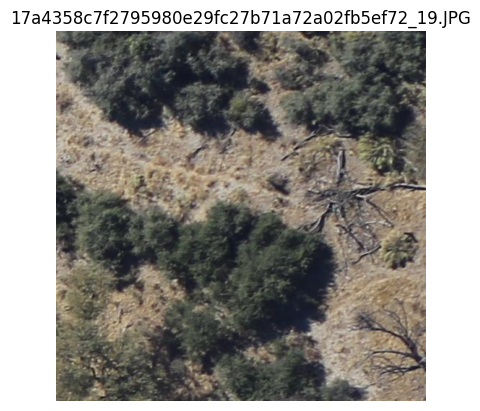

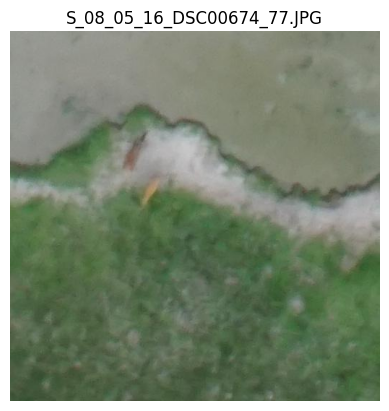

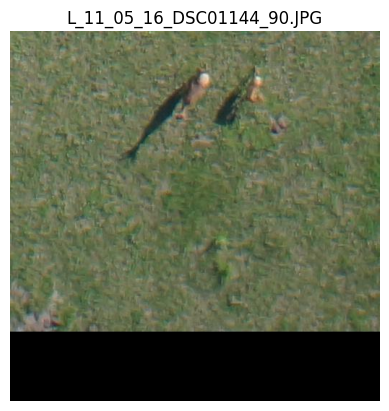

In [60]:
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

samples = random.sample(list(hnp_images), 3)
for name in samples:
    img = Image.open(MERGED_DIR / name)
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.show()

## Preparación de datasets y dataloaders

In [70]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        return train_dataset, val_dataset, test_dataset

builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv",
    train_root="../data/train_merged_patches",  # contiene positivos + HNPs
    val_csv="../data/val.csv", # imágenes completas
    val_root="../data/val", # imágenes completas
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=True,       # True = Fase 2 con HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

train_dataset, val_dataset, test_dataset = builder.build()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

print(f"[INFO] Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

[INFO] Train: 11663 | Val: 111 | Test: 258


## Configuración de arquitectura y modelo

In [71]:
# Crear la carpeta de checkpoints (si no existe)
#!mkdir -p /home/rafael/.cache/torch/hub/checkpoints/

# Copiar el archivo desde tu Drive al directorio de PyTorch
#!cp "/content/drive/MyDrive/HerdNet/original/dla34-ba72cf86.pth" "/root/.cache/torch/hub/checkpoints/dla34-ba72cf86.pth"

# Verificar que esté en su lugar
!ls -lh /home/rafael/.cache/torch/hub/checkpoints/

total 61M
-rw-r--r-- 1 rafael rafael 61M Nov 15 20:40 dla34-ba72cf86.pth


In [72]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

# Crear carpeta de trabajo donde se guardarán los modelos entrenados
work_dir = "../workspace/HerdNet/fase_2/models"
mkdir(work_dir)

# Definir hiperparámetros principales del entrenamiento
lr = 1e-6                 # Tasa de aprendizaje del optimizador
weight_decay = 1e-4       # Factor de regularización L2 para evitar sobreajuste
epochs = 1              # Número total de épocas de entrenamiento
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial de la red
num_classes = 7           # Número total de clases a predecir

from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=False,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_1/models/best_model.pth"
)

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Definir las métricas de evaluación basadas en puntos (detección y conteo)
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que une los parches de salida del modelo
# para reconstruir los mapas completos de densidad o detección
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches consecutivos
    down_ratio=down_ratio,  # Coincide con la reducción interna del modelo
    reduction="mean"        # Método de agregación entre parches superpuestos
)

# Crear el evaluador que calculará las métricas de desempeño en validación
evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,  # Conjunto de datos de validación
    metrics=metrics,            # Métricas definidas anteriormente
    stitcher=stitcher,          # Stitcher encargado de unir las predicciones
    work_dir=work_dir,          # Carpeta donde se guardan resultados
    header="validation"         # Prefijo usado para nombrar archivos de salida
)

# Crear el entrenador principal que gestiona el bucle de entrenamiento
trainer = Trainer(
    model=herdnet,              # Modelo HerdNet envuelto con pérdidas
    train_dataloader=train_dataloader,  # Datos de entrenamiento
    optimizer=optimizer,        # Optimizador Adam definido
    num_epochs=epochs,          # Número total de épocas
    evaluator=evaluator,        # Evaluador para medir desempeño durante el entrenamiento
    work_dir=work_dir           # Carpeta donde se almacenan modelos y logs
)


In [74]:
# Limpiar el estado corrupto de IPython
import sys
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    # Recrear el diccionario _oh
    ipython.user_ns['_oh'] = {}
    ipython.displayhook.cache_size = 1000
    
print("✅ Caché de IPython limpiado")

✅ Caché de IPython limpiado


In [75]:
import warnings
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

trainer.start(
    warmup_iters=1,            # sin fase de calentamiento extensa
    checkpoints="best",        # guarda el mejor modelo
    select="max",              # selecciona el máximo f1_score
    validate_on="f1_score"     # métrica principal
)

[2025-11-23 16:07:27] [INFO] [TRAINING] - Epoch: [1] [  1/729] eta: 0:05:05 lr: 0.000001 loss: 8.8946 (12.0391) focal_loss: 8.0110 (11.1810) ce_loss: 0.7863 (0.8581) time: 0.4189 data: 0.1668 max mem: 9375


[TRAINING] - Epoch: [1] [  1/729] eta: 0:05:05 lr: 0.000001 loss: 8.8946 (12.0391) focal_loss: 8.0110 (11.1810) ce_loss: 0.7863 (0.8581) time: 0.4189 data: 0.1668 max mem: 9375


[2025-11-23 16:07:47] [INFO] [TRAINING] - Epoch: [1] [ 51/729] eta: 0:04:29 lr: 0.000001 loss: 8.5663 (11.8220) focal_loss: 7.6726 (10.9644) ce_loss: 0.7837 (0.8576) time: 0.3982 data: 0.1658 max mem: 9375


[TRAINING] - Epoch: [1] [ 51/729] eta: 0:04:29 lr: 0.000001 loss: 8.5663 (11.8220) focal_loss: 7.6726 (10.9644) ce_loss: 0.7837 (0.8576) time: 0.3982 data: 0.1658 max mem: 9375


[2025-11-23 16:08:08] [INFO] [TRAINING] - Epoch: [1] [101/729] eta: 0:04:18 lr: 0.000001 loss: 7.9890 (11.6092) focal_loss: 7.2932 (10.7552) ce_loss: 0.7230 (0.8540) time: 0.3944 data: 0.1620 max mem: 9375


[TRAINING] - Epoch: [1] [101/729] eta: 0:04:18 lr: 0.000001 loss: 7.9890 (11.6092) focal_loss: 7.2932 (10.7552) ce_loss: 0.7230 (0.8540) time: 0.3944 data: 0.1620 max mem: 9375


[2025-11-23 16:08:28] [INFO] [TRAINING] - Epoch: [1] [151/729] eta: 0:03:56 lr: 0.000001 loss: 8.0864 (11.4043) focal_loss: 7.1082 (10.5540) ce_loss: 0.8367 (0.8503) time: 0.4010 data: 0.1684 max mem: 9375


[TRAINING] - Epoch: [1] [151/729] eta: 0:03:56 lr: 0.000001 loss: 8.0864 (11.4043) focal_loss: 7.1082 (10.5540) ce_loss: 0.8367 (0.8503) time: 0.4010 data: 0.1684 max mem: 9375


[2025-11-23 16:08:48] [INFO] [TRAINING] - Epoch: [1] [201/729] eta: 0:03:34 lr: 0.000001 loss: 7.6708 (11.2070) focal_loss: 6.8217 (10.3593) ce_loss: 0.7902 (0.8477) time: 0.3899 data: 0.1572 max mem: 9375


[TRAINING] - Epoch: [1] [201/729] eta: 0:03:34 lr: 0.000001 loss: 7.6708 (11.2070) focal_loss: 6.8217 (10.3593) ce_loss: 0.7902 (0.8477) time: 0.3899 data: 0.1572 max mem: 9375


[2025-11-23 16:09:08] [INFO] [TRAINING] - Epoch: [1] [251/729] eta: 0:03:14 lr: 0.000001 loss: 7.2439 (11.0110) focal_loss: 6.5119 (10.1686) ce_loss: 0.7320 (0.8424) time: 0.4103 data: 0.1776 max mem: 9375


[TRAINING] - Epoch: [1] [251/729] eta: 0:03:14 lr: 0.000001 loss: 7.2439 (11.0110) focal_loss: 6.5119 (10.1686) ce_loss: 0.7320 (0.8424) time: 0.4103 data: 0.1776 max mem: 9375


[2025-11-23 16:09:28] [INFO] [TRAINING] - Epoch: [1] [301/729] eta: 0:02:53 lr: 0.000001 loss: 7.1527 (10.8290) focal_loss: 6.4042 (9.9885) ce_loss: 0.7404 (0.8405) time: 0.4186 data: 0.1858 max mem: 9375


[TRAINING] - Epoch: [1] [301/729] eta: 0:02:53 lr: 0.000001 loss: 7.1527 (10.8290) focal_loss: 6.4042 (9.9885) ce_loss: 0.7404 (0.8405) time: 0.4186 data: 0.1858 max mem: 9375


[2025-11-23 16:09:49] [INFO] [TRAINING] - Epoch: [1] [351/729] eta: 0:02:34 lr: 0.000001 loss: 6.8570 (10.6538) focal_loss: 6.0643 (9.8153) ce_loss: 0.7532 (0.8386) time: 0.4180 data: 0.1849 max mem: 9375


[TRAINING] - Epoch: [1] [351/729] eta: 0:02:34 lr: 0.000001 loss: 6.8570 (10.6538) focal_loss: 6.0643 (9.8153) ce_loss: 0.7532 (0.8386) time: 0.4180 data: 0.1849 max mem: 9375


[2025-11-23 16:10:09] [INFO] [TRAINING] - Epoch: [1] [401/729] eta: 0:02:13 lr: 0.000001 loss: 6.6262 (10.4790) focal_loss: 5.8360 (9.6441) ce_loss: 0.7385 (0.8349) time: 0.4043 data: 0.1715 max mem: 9375


[TRAINING] - Epoch: [1] [401/729] eta: 0:02:13 lr: 0.000001 loss: 6.6262 (10.4790) focal_loss: 5.8360 (9.6441) ce_loss: 0.7385 (0.8349) time: 0.4043 data: 0.1715 max mem: 9375


[2025-11-23 16:10:30] [INFO] [TRAINING] - Epoch: [1] [451/729] eta: 0:01:53 lr: 0.000001 loss: 6.4407 (10.3133) focal_loss: 5.7033 (9.4802) ce_loss: 0.7614 (0.8331) time: 0.4363 data: 0.2032 max mem: 9375


[TRAINING] - Epoch: [1] [451/729] eta: 0:01:53 lr: 0.000001 loss: 6.4407 (10.3133) focal_loss: 5.7033 (9.4802) ce_loss: 0.7614 (0.8331) time: 0.4363 data: 0.2032 max mem: 9375


[2025-11-23 16:10:50] [INFO] [TRAINING] - Epoch: [1] [501/729] eta: 0:01:33 lr: 0.000001 loss: 6.2954 (10.1560) focal_loss: 5.6144 (9.3236) ce_loss: 0.7348 (0.8325) time: 0.3946 data: 0.1618 max mem: 9375


[TRAINING] - Epoch: [1] [501/729] eta: 0:01:33 lr: 0.000001 loss: 6.2954 (10.1560) focal_loss: 5.6144 (9.3236) ce_loss: 0.7348 (0.8325) time: 0.3946 data: 0.1618 max mem: 9375


[2025-11-23 16:11:11] [INFO] [TRAINING] - Epoch: [1] [551/729] eta: 0:01:12 lr: 0.000001 loss: 6.0680 (9.9991) focal_loss: 5.4081 (9.1705) ce_loss: 0.6186 (0.8286) time: 0.4150 data: 0.1823 max mem: 9375


[TRAINING] - Epoch: [1] [551/729] eta: 0:01:12 lr: 0.000001 loss: 6.0680 (9.9991) focal_loss: 5.4081 (9.1705) ce_loss: 0.6186 (0.8286) time: 0.4150 data: 0.1823 max mem: 9375


[2025-11-23 16:11:32] [INFO] [TRAINING] - Epoch: [1] [601/729] eta: 0:00:52 lr: 0.000001 loss: 6.1290 (9.8506) focal_loss: 5.1755 (9.0225) ce_loss: 0.8422 (0.8281) time: 0.4445 data: 0.2114 max mem: 9375


[TRAINING] - Epoch: [1] [601/729] eta: 0:00:52 lr: 0.000001 loss: 6.1290 (9.8506) focal_loss: 5.1755 (9.0225) ce_loss: 0.8422 (0.8281) time: 0.4445 data: 0.2114 max mem: 9375


[2025-11-23 16:11:53] [INFO] [TRAINING] - Epoch: [1] [651/729] eta: 0:00:32 lr: 0.000001 loss: 5.6628 (9.7049) focal_loss: 4.8743 (8.8795) ce_loss: 0.7713 (0.8254) time: 0.4040 data: 0.1709 max mem: 9375


[TRAINING] - Epoch: [1] [651/729] eta: 0:00:32 lr: 0.000001 loss: 5.6628 (9.7049) focal_loss: 4.8743 (8.8795) ce_loss: 0.7713 (0.8254) time: 0.4040 data: 0.1709 max mem: 9375


[2025-11-23 16:12:13] [INFO] [TRAINING] - Epoch: [1] [701/729] eta: 0:00:11 lr: 0.000001 loss: 5.6088 (9.5646) focal_loss: 4.8708 (8.7415) ce_loss: 0.7570 (0.8230) time: 0.4229 data: 0.1901 max mem: 9375


[TRAINING] - Epoch: [1] [701/729] eta: 0:00:11 lr: 0.000001 loss: 5.6088 (9.5646) focal_loss: 4.8708 (8.7415) ce_loss: 0.7570 (0.8230) time: 0.4229 data: 0.1901 max mem: 9375


[2025-11-23 16:12:26] [INFO] [TRAINING] - Epoch: [1] [729/729] eta: 0:00:00 lr: 0.000001 loss: 5.3875 (9.4851) focal_loss: 4.6855 (8.6638) ce_loss: 0.7263 (0.8213) time: 0.4348 data: 0.2024 max mem: 9375
[2025-11-23 16:12:26] [INFO] [TRAINING] - Epoch: [1] Total time: 0:04:59 (0.4104 s / it)


[TRAINING] - Epoch: [1] [729/729] eta: 0:00:00 lr: 0.000001 loss: 5.3875 (9.4851) focal_loss: 4.6855 (8.6638) ce_loss: 0.7263 (0.8213) time: 0.4348 data: 0.2024 max mem: 9375
[TRAINING] - Epoch: [1] Total time: 0:04:59 (0.4104 s / it)
[TRAINING] - Epoch: [1] mean loss: 6.9278


[2025-11-23 16:12:27] [INFO] [VALIDATION] - Epoch: [1] [  1/111] eta: 0:03:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15133.0 MSE: 229007689.0 RMSE: 15133.0 time: 1.6698 data: 0.3980 max mem: 9375


[VALIDATION] - Epoch: [1] [  1/111] eta: 0:03:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15133.0 MSE: 229007689.0 RMSE: 15133.0 time: 1.6698 data: 0.3980 max mem: 9375


[2025-11-23 16:12:44] [INFO] [VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:51 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21658.0 MSE: 469068964.0 RMSE: 21658.0 time: 1.6948 data: 0.3976 max mem: 9375


[VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:51 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21658.0 MSE: 469068964.0 RMSE: 21658.0 time: 1.6948 data: 0.3976 max mem: 9375


[2025-11-23 16:13:01] [INFO] [VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:33 n: 7 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 15552.0 MSE: 241864704.0 RMSE: 15552.0 time: 1.6876 data: 0.3945 max mem: 9375


[VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:33 n: 7 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 15552.0 MSE: 241864704.0 RMSE: 15552.0 time: 1.6876 data: 0.3945 max mem: 9375


[2025-11-23 16:13:19] [INFO] [VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:18 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17343.0 MSE: 300779649.0 RMSE: 17343.0 time: 1.7190 data: 0.3904 max mem: 9375


[VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:18 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17343.0 MSE: 300779649.0 RMSE: 17343.0 time: 1.7190 data: 0.3904 max mem: 9375


[2025-11-23 16:13:36] [INFO] [VALIDATION] - Epoch: [1] [ 41/111] eta: 0:02:01 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 19886.0 MSE: 395452996.0 RMSE: 19886.0 time: 1.7369 data: 0.3887 max mem: 9375


[VALIDATION] - Epoch: [1] [ 41/111] eta: 0:02:01 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 19886.0 MSE: 395452996.0 RMSE: 19886.0 time: 1.7369 data: 0.3887 max mem: 9375


[2025-11-23 16:13:53] [INFO] [VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:44 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12844.0 MSE: 164968336.0 RMSE: 12844.0 time: 1.7262 data: 0.3925 max mem: 9375


[VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:44 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12844.0 MSE: 164968336.0 RMSE: 12844.0 time: 1.7262 data: 0.3925 max mem: 9375


[2025-11-23 16:14:11] [INFO] [VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:27 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15345.0 MSE: 235469025.0 RMSE: 15345.0 time: 1.7301 data: 0.3928 max mem: 9375


[VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:27 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15345.0 MSE: 235469025.0 RMSE: 15345.0 time: 1.7301 data: 0.3928 max mem: 9375


[2025-11-23 16:14:28] [INFO] [VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:10 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18148.0 MSE: 329349904.0 RMSE: 18148.0 time: 1.7260 data: 0.3846 max mem: 9375


[VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:10 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18148.0 MSE: 329349904.0 RMSE: 18148.0 time: 1.7260 data: 0.3846 max mem: 9375


[2025-11-23 16:14:44] [INFO] [VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:52 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 9566.0 MSE: 91508356.0 RMSE: 9566.0 time: 1.6797 data: 0.3692 max mem: 9375


[VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:52 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 9566.0 MSE: 91508356.0 RMSE: 9566.0 time: 1.6797 data: 0.3692 max mem: 9375


[2025-11-23 16:15:00] [INFO] [VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:35 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 12072.0 MSE: 145733184.0 RMSE: 12072.0 time: 1.5929 data: 0.3431 max mem: 9375


[VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:35 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 12072.0 MSE: 145733184.0 RMSE: 12072.0 time: 1.5929 data: 0.3431 max mem: 9375


[2025-11-23 16:15:15] [INFO] [VALIDATION] - Epoch: [1] [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14513.0 MSE: 210627169.0 RMSE: 14513.0 time: 1.5677 data: 0.3275 max mem: 9375


[VALIDATION] - Epoch: [1] [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14513.0 MSE: 210627169.0 RMSE: 14513.0 time: 1.5677 data: 0.3275 max mem: 9375


[2025-11-23 16:15:31] [INFO] [VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 9989.0 MSE: 99780121.0 RMSE: 9989.0 time: 1.5641 data: 0.3290 max mem: 9375
[2025-11-23 16:15:31] [INFO] [VALIDATION] - Epoch: [1] Total time: 0:03:05 (1.6687 s / it)


[VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 9989.0 MSE: 99780121.0 RMSE: 9989.0 time: 1.5641 data: 0.3290 max mem: 9375
[VALIDATION] - Epoch: [1] Total time: 0:03:05 (1.6687 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.0009
Best model saved - Epoch 1 - Validation value: 0.000937


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

## Evaluación

### Config

In [77]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_2/models/best_model.pth"
)

### Val

In [79]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear la carpeta de salida para guardar resultados de validación
val_dir = "../workspace/HerdNet/fase_2/evaluation_val"
mkdir(val_dir)

# Definir hiperparámetros principales del entrenamiento y evaluación
lr = 1e-4                 # Tasa de aprendizaje
weight_decay = 1e-3       # Factor de regularización L2
epochs = 1              # Número de épocas de entrenamiento
num_classes = 7           # Número de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar el conjunto de métricas para evaluar detecciones y conteos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye las predicciones a nivel de imagen completa
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,             # Superposición entre parches consecutivos
    down_ratio=down_ratio,   # Coincide con la reducción del modelo
    reduction="mean"         # Método de agregación de resultados superpuestos
)

# Crear el evaluador de validación, encargado de medir desempeño del modelo
val_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=val_dir,
    header="val"             # Prefijo usado en los archivos de salida
)

# Definir el entrenador principal con su evaluador y configuración general
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=val_evaluator,
    work_dir=val_dir
)

In [80]:
# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = val_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 16:18:22] [INFO] val [  1/111] eta: 0:04:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15133.0 MSE: 229007689.0 RMSE: 15133.0 time: 2.2378 data: 0.3932 max mem: 9375


val [  1/111] eta: 0:04:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15133.0 MSE: 229007689.0 RMSE: 15133.0 time: 2.2378 data: 0.3932 max mem: 9375


[2025-11-23 16:18:41] [INFO] val [ 11/111] eta: 0:03:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21658.0 MSE: 469068964.0 RMSE: 21658.0 time: 1.9254 data: 0.3930 max mem: 9375


val [ 11/111] eta: 0:03:14 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21658.0 MSE: 469068964.0 RMSE: 21658.0 time: 1.9254 data: 0.3930 max mem: 9375


[2025-11-23 16:19:00] [INFO] val [ 21/111] eta: 0:02:54 n: 7 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 15552.0 MSE: 241864704.0 RMSE: 15552.0 time: 1.9052 data: 0.3912 max mem: 9375


val [ 21/111] eta: 0:02:54 n: 7 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 15552.0 MSE: 241864704.0 RMSE: 15552.0 time: 1.9052 data: 0.3912 max mem: 9375


[2025-11-23 16:19:18] [INFO] val [ 31/111] eta: 0:02:32 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17343.0 MSE: 300779649.0 RMSE: 17343.0 time: 1.8636 data: 0.3890 max mem: 9375


val [ 31/111] eta: 0:02:32 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17343.0 MSE: 300779649.0 RMSE: 17343.0 time: 1.8636 data: 0.3890 max mem: 9375


[2025-11-23 16:19:36] [INFO] val [ 41/111] eta: 0:02:11 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 19886.0 MSE: 395452996.0 RMSE: 19886.0 time: 1.7787 data: 0.3898 max mem: 9375


val [ 41/111] eta: 0:02:11 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 19886.0 MSE: 395452996.0 RMSE: 19886.0 time: 1.7787 data: 0.3898 max mem: 9375


[2025-11-23 16:19:53] [INFO] val [ 51/111] eta: 0:01:51 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12844.0 MSE: 164968336.0 RMSE: 12844.0 time: 1.7424 data: 0.3912 max mem: 9375


val [ 51/111] eta: 0:01:51 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12844.0 MSE: 164968336.0 RMSE: 12844.0 time: 1.7424 data: 0.3912 max mem: 9375


[2025-11-23 16:20:10] [INFO] val [ 61/111] eta: 0:01:32 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15345.0 MSE: 235469025.0 RMSE: 15345.0 time: 1.7227 data: 0.3886 max mem: 9375


val [ 61/111] eta: 0:01:32 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15345.0 MSE: 235469025.0 RMSE: 15345.0 time: 1.7227 data: 0.3886 max mem: 9375


[2025-11-23 16:20:27] [INFO] val [ 71/111] eta: 0:01:13 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18148.0 MSE: 329349904.0 RMSE: 18148.0 time: 1.7090 data: 0.3810 max mem: 9375


val [ 71/111] eta: 0:01:13 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18148.0 MSE: 329349904.0 RMSE: 18148.0 time: 1.7090 data: 0.3810 max mem: 9375


[2025-11-23 16:20:44] [INFO] val [ 81/111] eta: 0:00:55 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 9566.0 MSE: 91508356.0 RMSE: 9566.0 time: 1.6795 data: 0.3679 max mem: 9375


val [ 81/111] eta: 0:00:55 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 9566.0 MSE: 91508356.0 RMSE: 9566.0 time: 1.6795 data: 0.3679 max mem: 9375


[2025-11-23 16:21:00] [INFO] val [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 12072.0 MSE: 145733184.0 RMSE: 12072.0 time: 1.6349 data: 0.3464 max mem: 9375


val [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 12072.0 MSE: 145733184.0 RMSE: 12072.0 time: 1.6349 data: 0.3464 max mem: 9375


[2025-11-23 16:21:15] [INFO] val [101/111] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14513.0 MSE: 210627169.0 RMSE: 14513.0 time: 1.5944 data: 0.3306 max mem: 9375


val [101/111] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14513.0 MSE: 210627169.0 RMSE: 14513.0 time: 1.5944 data: 0.3306 max mem: 9375


[2025-11-23 16:21:31] [INFO] val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 9989.0 MSE: 99780121.0 RMSE: 9989.0 time: 1.5611 data: 0.3315 max mem: 9375
[2025-11-23 16:21:31] [INFO] val Total time: 0:03:11 (1.7245 s / it)


val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 9989.0 MSE: 99780121.0 RMSE: 9989.0 time: 1.5611 data: 0.3315 max mem: 9375
val Total time: 0:03:11 (1.7245 s / it)
F1 score = 0%


In [81]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = val_evaluator.results
print(metrics_val)

    class    n    recall  precision  f1_score  confusion           mae  \
0       1  369  0.222222   0.008384  0.016158   0.754491    106.954545   
1       2  102  0.872549   0.000921  0.001841   0.101010    869.369369   
2       3  161  0.801242   0.018615  0.036384   0.167742     81.554217   
3       4   43  0.348837   0.000019  0.000038   0.605263   7167.409091   
4       5   39  0.487179   0.000155  0.000310   0.472222   1165.504762   
5       6  264  0.666667   0.000203  0.000406   0.217778   7812.540541   
6  binary  978  0.906953   0.000469  0.000937   0.000000  17033.027027   

            mse          rmse        ap  
0  7.498250e+04    273.829326  0.006815  
1  1.632735e+06   1277.785154  0.049106  
2  2.464392e+04    156.983807  0.067148  
3  7.569791e+07   8700.454603  0.000497  
4  2.876571e+06   1696.045821  0.037528  
5  1.092478e+08  10452.165160  0.002885  
6  3.231118e+08  17975.311656  0.018218  


### Test

In [82]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_2/evaluation_test"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
epochs = 100              # Número de épocas (para consistencia con entrenamiento)
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

In [83]:
# Ignorar advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación sobre el conjunto de prueba y obtener el F1-score
test_f1_score = test_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 16:25:52] [INFO] test [  1/258] eta: 0:07:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12688.0 MSE: 160985344.0 RMSE: 12688.0 time: 1.6510 data: 0.3955 max mem: 9375


test [  1/258] eta: 0:07:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12688.0 MSE: 160985344.0 RMSE: 12688.0 time: 1.6510 data: 0.3955 max mem: 9375


[2025-11-23 16:26:10] [INFO] test [ 11/258] eta: 0:07:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14488.0 MSE: 209902144.0 RMSE: 14488.0 time: 1.7366 data: 0.3855 max mem: 9375


test [ 11/258] eta: 0:07:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14488.0 MSE: 209902144.0 RMSE: 14488.0 time: 1.7366 data: 0.3855 max mem: 9375


[2025-11-23 16:26:28] [INFO] test [ 21/258] eta: 0:07:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11577.0 MSE: 134026929.0 RMSE: 11577.0 time: 1.7724 data: 0.3813 max mem: 9375


test [ 21/258] eta: 0:07:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11577.0 MSE: 134026929.0 RMSE: 11577.0 time: 1.7724 data: 0.3813 max mem: 9375


[2025-11-23 16:26:45] [INFO] test [ 31/258] eta: 0:06:39 n: 36 recall: 0.97 precision: 0.0 f1-score: 0.0 MAE: 24717.0 MSE: 610930089.0 RMSE: 24717.0 time: 1.7595 data: 0.3779 max mem: 9375


test [ 31/258] eta: 0:06:39 n: 36 recall: 0.97 precision: 0.0 f1-score: 0.0 MAE: 24717.0 MSE: 610930089.0 RMSE: 24717.0 time: 1.7595 data: 0.3779 max mem: 9375


[2025-11-23 16:27:03] [INFO] test [ 41/258] eta: 0:06:25 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 18616.0 MSE: 346555456.0 RMSE: 18616.0 time: 1.7678 data: 0.3790 max mem: 9375


test [ 41/258] eta: 0:06:25 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 18616.0 MSE: 346555456.0 RMSE: 18616.0 time: 1.7678 data: 0.3790 max mem: 9375


[2025-11-23 16:27:20] [INFO] test [ 51/258] eta: 0:06:05 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12999.0 MSE: 168974001.0 RMSE: 12999.0 time: 1.7680 data: 0.3784 max mem: 9375


test [ 51/258] eta: 0:06:05 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12999.0 MSE: 168974001.0 RMSE: 12999.0 time: 1.7680 data: 0.3784 max mem: 9375


[2025-11-23 16:27:39] [INFO] test [ 61/258] eta: 0:05:51 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21545.0 MSE: 464187025.0 RMSE: 21545.0 time: 1.7948 data: 0.3800 max mem: 9375


test [ 61/258] eta: 0:05:51 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 21545.0 MSE: 464187025.0 RMSE: 21545.0 time: 1.7948 data: 0.3800 max mem: 9375


[2025-11-23 16:27:57] [INFO] test [ 71/258] eta: 0:05:34 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 21317.0 MSE: 454414489.0 RMSE: 21317.0 time: 1.8370 data: 0.3833 max mem: 9375


test [ 71/258] eta: 0:05:34 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 21317.0 MSE: 454414489.0 RMSE: 21317.0 time: 1.8370 data: 0.3833 max mem: 9375


[2025-11-23 16:28:16] [INFO] test [ 81/258] eta: 0:05:19 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20376.0 MSE: 415181376.0 RMSE: 20376.0 time: 1.8440 data: 0.3820 max mem: 9375


test [ 81/258] eta: 0:05:19 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20376.0 MSE: 415181376.0 RMSE: 20376.0 time: 1.8440 data: 0.3820 max mem: 9375


[2025-11-23 16:28:33] [INFO] test [ 91/258] eta: 0:04:59 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11499.0 MSE: 132227001.0 RMSE: 11499.0 time: 1.7802 data: 0.3805 max mem: 9375


test [ 91/258] eta: 0:04:59 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11499.0 MSE: 132227001.0 RMSE: 11499.0 time: 1.7802 data: 0.3805 max mem: 9375


[2025-11-23 16:28:50] [INFO] test [101/258] eta: 0:04:40 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11662.0 MSE: 136002244.0 RMSE: 11662.0 time: 1.7120 data: 0.3790 max mem: 9375


test [101/258] eta: 0:04:40 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11662.0 MSE: 136002244.0 RMSE: 11662.0 time: 1.7120 data: 0.3790 max mem: 9375


[2025-11-23 16:29:07] [INFO] test [111/258] eta: 0:04:21 n: 5 recall: 0.4 precision: 0.0 f1-score: 0.0 MAE: 16964.0 MSE: 287777296.0 RMSE: 16964.0 time: 1.7177 data: 0.3789 max mem: 9375


test [111/258] eta: 0:04:21 n: 5 recall: 0.4 precision: 0.0 f1-score: 0.0 MAE: 16964.0 MSE: 287777296.0 RMSE: 16964.0 time: 1.7177 data: 0.3789 max mem: 9375


[2025-11-23 16:29:25] [INFO] test [121/258] eta: 0:04:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17450.0 MSE: 304502500.0 RMSE: 17450.0 time: 1.7383 data: 0.3815 max mem: 9375


test [121/258] eta: 0:04:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17450.0 MSE: 304502500.0 RMSE: 17450.0 time: 1.7383 data: 0.3815 max mem: 9375


[2025-11-23 16:29:42] [INFO] test [131/258] eta: 0:03:46 n: 17 recall: 0.94 precision: 0.0 f1-score: 0.0 MAE: 17764.0 MSE: 315559696.0 RMSE: 17764.0 time: 1.7488 data: 0.3836 max mem: 9375


test [131/258] eta: 0:03:46 n: 17 recall: 0.94 precision: 0.0 f1-score: 0.0 MAE: 17764.0 MSE: 315559696.0 RMSE: 17764.0 time: 1.7488 data: 0.3836 max mem: 9375


[2025-11-23 16:30:00] [INFO] test [141/258] eta: 0:03:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15751.0 MSE: 248094001.0 RMSE: 15751.0 time: 1.7431 data: 0.3853 max mem: 9375


test [141/258] eta: 0:03:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15751.0 MSE: 248094001.0 RMSE: 15751.0 time: 1.7431 data: 0.3853 max mem: 9375


[2025-11-23 16:30:17] [INFO] test [151/258] eta: 0:03:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17546.0 MSE: 307862116.0 RMSE: 17546.0 time: 1.7470 data: 0.3880 max mem: 9375


test [151/258] eta: 0:03:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17546.0 MSE: 307862116.0 RMSE: 17546.0 time: 1.7470 data: 0.3880 max mem: 9375


[2025-11-23 16:30:34] [INFO] test [161/258] eta: 0:02:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14575.0 MSE: 212430625.0 RMSE: 14575.0 time: 1.7126 data: 0.3796 max mem: 9375


test [161/258] eta: 0:02:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14575.0 MSE: 212430625.0 RMSE: 14575.0 time: 1.7126 data: 0.3796 max mem: 9375


[2025-11-23 16:30:49] [INFO] test [171/258] eta: 0:02:33 n: 11 recall: 0.64 precision: 0.0 f1-score: 0.0 MAE: 8675.0 MSE: 75255625.0 RMSE: 8675.0 time: 1.6136 data: 0.3501 max mem: 9375


test [171/258] eta: 0:02:33 n: 11 recall: 0.64 precision: 0.0 f1-score: 0.0 MAE: 8675.0 MSE: 75255625.0 RMSE: 8675.0 time: 1.6136 data: 0.3501 max mem: 9375


[2025-11-23 16:31:06] [INFO] test [181/258] eta: 0:02:15 n: 14 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 12523.0 MSE: 156825529.0 RMSE: 12523.0 time: 1.6063 data: 0.3309 max mem: 9375


test [181/258] eta: 0:02:15 n: 14 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 12523.0 MSE: 156825529.0 RMSE: 12523.0 time: 1.6063 data: 0.3309 max mem: 9375


[2025-11-23 16:31:22] [INFO] test [191/258] eta: 0:01:57 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13664.0 MSE: 186704896.0 RMSE: 13664.0 time: 1.6191 data: 0.3311 max mem: 9375


test [191/258] eta: 0:01:57 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13664.0 MSE: 186704896.0 RMSE: 13664.0 time: 1.6191 data: 0.3311 max mem: 9375


[2025-11-23 16:31:38] [INFO] test [201/258] eta: 0:01:40 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 29294.0 MSE: 858138436.0 RMSE: 29294.0 time: 1.5980 data: 0.3303 max mem: 9375


test [201/258] eta: 0:01:40 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 29294.0 MSE: 858138436.0 RMSE: 29294.0 time: 1.5980 data: 0.3303 max mem: 9375


[2025-11-23 16:31:53] [INFO] test [211/258] eta: 0:01:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15151.0 MSE: 229552801.0 RMSE: 15151.0 time: 1.5798 data: 0.3264 max mem: 9375


test [211/258] eta: 0:01:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15151.0 MSE: 229552801.0 RMSE: 15151.0 time: 1.5798 data: 0.3264 max mem: 9375


[2025-11-23 16:32:10] [INFO] test [221/258] eta: 0:01:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17125.0 MSE: 293265625.0 RMSE: 17125.0 time: 1.5883 data: 0.3270 max mem: 9375


test [221/258] eta: 0:01:05 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17125.0 MSE: 293265625.0 RMSE: 17125.0 time: 1.5883 data: 0.3270 max mem: 9375


[2025-11-23 16:32:26] [INFO] test [231/258] eta: 0:00:47 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 24940.0 MSE: 622003600.0 RMSE: 24940.0 time: 1.6399 data: 0.3289 max mem: 9375


test [231/258] eta: 0:00:47 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 24940.0 MSE: 622003600.0 RMSE: 24940.0 time: 1.6399 data: 0.3289 max mem: 9375


[2025-11-23 16:32:42] [INFO] test [241/258] eta: 0:00:30 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 23572.0 MSE: 555639184.0 RMSE: 23572.0 time: 1.6097 data: 0.3278 max mem: 9375


test [241/258] eta: 0:00:30 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 23572.0 MSE: 555639184.0 RMSE: 23572.0 time: 1.6097 data: 0.3278 max mem: 9375


[2025-11-23 16:32:58] [INFO] test [251/258] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14109.0 MSE: 199063881.0 RMSE: 14109.0 time: 1.5810 data: 0.3270 max mem: 9375


test [251/258] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14109.0 MSE: 199063881.0 RMSE: 14109.0 time: 1.5810 data: 0.3270 max mem: 9375


[2025-11-23 16:33:08] [INFO] test [258/258] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15676.0 MSE: 245736976.0 RMSE: 15676.0 time: 1.5740 data: 0.3271 max mem: 9375
[2025-11-23 16:33:08] [INFO] test Total time: 0:07:17 (1.6959 s / it)


test [258/258] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15676.0 MSE: 245736976.0 RMSE: 15676.0 time: 1.5740 data: 0.3271 max mem: 9375
test Total time: 0:07:17 (1.6959 s / it)
F1 score = 0%


In [84]:
# Obtener las detecciones generadas durante la evaluación
metrics_test = test_evaluator.results
print(metrics_test)

    class     n    recall  precision  f1_score  confusion           mae  \
0       1   675  0.394074   0.005699  0.011236   0.577107    228.835821   
1       2   349  0.676218   0.002258  0.004502   0.257862    406.835938   
2       3   477  0.689727   0.027346  0.052606   0.300000     66.102857   
3       4    74  0.297297   0.000011  0.000022   0.627119   7733.151163   
4       5    36  0.555556   0.000071  0.000142   0.444444   1175.422594   
5       6   688  0.747093   0.000254  0.000507   0.157377   7854.422481   
6  binary  2299  0.923010   0.000475  0.000950   0.000000  17303.178295   

            mse          rmse        ap  
0  1.781963e+05    422.133081  0.026964  
1  8.380009e+05    915.423881  0.028888  
2  2.121491e+04    145.653405  0.057776  
3  9.428262e+07   9709.923606  0.000880  
4  2.972949e+06   1724.224075  0.004487  
5  1.380254e+08  11748.419577  0.002409  
6  3.362404e+08  18336.858610  0.018119  


# **Paso 3 - Afinar el entrenamiento**

## Datasets y Dataloaders

In [136]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                #A.Resize(height=self.patch_size, width=self.patch_size, p=1.0),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        return train_dataset, val_dataset, test_dataset

builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv",
    train_root="../data/train_patches",  # contiene positivos + HNPs
    val_csv="../data/val.csv", # imágenes completas
    val_root="../data/val", # imágenes completas
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=True,       # True = Fase 2 con HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

train_dataset, val_dataset, test_dataset = builder.build()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

print(f"[INFO] Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

[INFO] Train: 7765 | Val: 111 | Test: 258


## Modelo y Entrenamiento

In [139]:
# Limpiar el estado corrupto de IPython
import sys
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    # Recrear el diccionario _oh
    ipython.user_ns['_oh'] = {}
    ipython.displayhook.cache_size = 1000
    
print("✅ Caché de IPython limpiado")

✅ Caché de IPython limpiado


In [140]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
from animaloc.models import HerdNet, LossWrapper, load_model  # ✅ Agregado load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
import torch

# Configuración general
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WORK_DIR = "../workspace/HerdNet/fase_3/output_ft"
mkdir(WORK_DIR)

LR_HEAD = 0.000001
WEIGHT_DECAY = 0.00005
#EPOCHS = 10
EPOCHS = 1
PATCH_SIZE = 512
DOWN_RATIO = 2
NUM_CLASSES = 7

# Modelo
herdnet = HerdNet(
    pretrained=True,
    num_classes=NUM_CLASSES,
    down_ratio=DOWN_RATIO
).to(DEVICE)

# Evitar drift en BatchNorm (no modifica pesos)
herdnet.eval()
for m in herdnet.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.track_running_stats = False

# Pérdidas proporcionales
CLASS_WEIGHTS = torch.Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).to(DEVICE)  # ✅ Cambio

LOSSES = [
    {"loss": FocalLoss(reduction="mean", normalize=False),
     "idx": 0, "idy": 0, "lambda": 1.0, "name": "focal_loss"},
    {"loss": CrossEntropyLoss(reduction="mean", weight=CLASS_WEIGHTS),
     "idx": 1, "idy": 1, "lambda": 1.0, "name": "ce_loss"},
]

herdnet = LossWrapper(herdnet, losses=LOSSES)

# Cargar los pesos del modelo entrenado en la Fase 2
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_2/models/best_model.pth"
)

# Entrenar solo las cabezas
for name, param in herdnet.named_parameters():
    if any(x in name for x in ["loc_head", "cls_head", "head", "hm", "wh", "reg"]):
        param.requires_grad = False
    else:
        param.requires_grad = True

# Optimizador (modo fine-tuning estable)
optimizer = Adam(
    [p for n, p in herdnet.named_parameters() if p.requires_grad],
    lr=LR_HEAD,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=WEIGHT_DECAY,
    amsgrad=True
)

# Métricas y evaluación
metrics = PointsMetrics(radius=20, num_classes=NUM_CLASSES)
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(PATCH_SIZE, PATCH_SIZE),
    overlap=160,
    down_ratio=DOWN_RATIO,
    reduction="mean"
)

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=WORK_DIR,
    header="validation",
    print_freq=10,
    lmds_kwargs={"kernel_size": (3, 3), "adapt_ts": 0.3}
)

# Entrenador
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    evaluator=evaluator,
    work_dir=WORK_DIR,
    print_freq=20,
    valid_freq=1,
    auto_lr=False,
)

import warnings
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

trainer.start(
    warmup_iters=1,
    checkpoints="best",
    select="max",
    validate_on="f1_score"
)

[2025-11-23 17:18:19] [INFO] [TRAINING] - Epoch: [1] [  1/486] eta: 0:03:24 lr: 0.000001 loss: 5.5232 (5.5232) focal_loss: 4.9038 (4.9038) ce_loss: 0.6194 (0.6194) time: 0.4209 data: 0.1914 max mem: 15283


[TRAINING] - Epoch: [1] [  1/486] eta: 0:03:24 lr: 0.000001 loss: 5.5232 (5.5232) focal_loss: 4.9038 (4.9038) ce_loss: 0.6194 (0.6194) time: 0.4209 data: 0.1914 max mem: 15283


[2025-11-23 17:18:27] [INFO] [TRAINING] - Epoch: [1] [ 21/486] eta: 0:03:17 lr: 0.000001 loss: 5.9014 (5.8661) focal_loss: 4.9775 (5.0040) ce_loss: 0.8209 (0.8621) time: 0.4238 data: 0.1946 max mem: 15283


[TRAINING] - Epoch: [1] [ 21/486] eta: 0:03:17 lr: 0.000001 loss: 5.9014 (5.8661) focal_loss: 4.9775 (5.0040) ce_loss: 0.8209 (0.8621) time: 0.4238 data: 0.1946 max mem: 15283


[2025-11-23 17:18:36] [INFO] [TRAINING] - Epoch: [1] [ 41/486] eta: 0:03:11 lr: 0.000001 loss: 5.8386 (5.8826) focal_loss: 4.9744 (5.0113) ce_loss: 0.8251 (0.8713) time: 0.4358 data: 0.2065 max mem: 15283


[TRAINING] - Epoch: [1] [ 41/486] eta: 0:03:11 lr: 0.000001 loss: 5.8386 (5.8826) focal_loss: 4.9744 (5.0113) ce_loss: 0.8251 (0.8713) time: 0.4358 data: 0.2065 max mem: 15283


[2025-11-23 17:18:45] [INFO] [TRAINING] - Epoch: [1] [ 61/486] eta: 0:03:08 lr: 0.000001 loss: 5.7629 (5.8509) focal_loss: 4.9519 (4.9990) ce_loss: 0.7627 (0.8519) time: 0.4704 data: 0.2413 max mem: 15283


[TRAINING] - Epoch: [1] [ 61/486] eta: 0:03:08 lr: 0.000001 loss: 5.7629 (5.8509) focal_loss: 4.9519 (4.9990) ce_loss: 0.7627 (0.8519) time: 0.4704 data: 0.2413 max mem: 15283


[2025-11-23 17:18:54] [INFO] [TRAINING] - Epoch: [1] [ 81/486] eta: 0:03:00 lr: 0.000001 loss: 5.8127 (5.8383) focal_loss: 4.9424 (4.9915) ce_loss: 0.7915 (0.8468) time: 0.4517 data: 0.2225 max mem: 15283


[TRAINING] - Epoch: [1] [ 81/486] eta: 0:03:00 lr: 0.000001 loss: 5.8127 (5.8383) focal_loss: 4.9424 (4.9915) ce_loss: 0.7915 (0.8468) time: 0.4517 data: 0.2225 max mem: 15283


[2025-11-23 17:19:03] [INFO] [TRAINING] - Epoch: [1] [101/486] eta: 0:02:50 lr: 0.000001 loss: 5.5927 (5.8034) focal_loss: 4.8018 (4.9705) ce_loss: 0.7591 (0.8329) time: 0.4266 data: 0.1970 max mem: 15283


[TRAINING] - Epoch: [1] [101/486] eta: 0:02:50 lr: 0.000001 loss: 5.5927 (5.8034) focal_loss: 4.8018 (4.9705) ce_loss: 0.7591 (0.8329) time: 0.4266 data: 0.1970 max mem: 15283


[2025-11-23 17:19:11] [INFO] [TRAINING] - Epoch: [1] [121/486] eta: 0:02:40 lr: 0.000001 loss: 5.9432 (5.8294) focal_loss: 5.0551 (4.9934) ce_loss: 0.8749 (0.8360) time: 0.4203 data: 0.1909 max mem: 15283


[TRAINING] - Epoch: [1] [121/486] eta: 0:02:40 lr: 0.000001 loss: 5.9432 (5.8294) focal_loss: 5.0551 (4.9934) ce_loss: 0.8749 (0.8360) time: 0.4203 data: 0.1909 max mem: 15283


[2025-11-23 17:19:20] [INFO] [TRAINING] - Epoch: [1] [141/486] eta: 0:02:30 lr: 0.000001 loss: 6.0557 (5.8479) focal_loss: 5.0657 (5.0035) ce_loss: 0.8612 (0.8444) time: 0.4253 data: 0.1957 max mem: 15283


[TRAINING] - Epoch: [1] [141/486] eta: 0:02:30 lr: 0.000001 loss: 6.0557 (5.8479) focal_loss: 5.0657 (5.0035) ce_loss: 0.8612 (0.8444) time: 0.4253 data: 0.1957 max mem: 15283


[2025-11-23 17:19:28] [INFO] [TRAINING] - Epoch: [1] [161/486] eta: 0:02:22 lr: 0.000001 loss: 5.8408 (5.8402) focal_loss: 4.9015 (4.9971) ce_loss: 0.8042 (0.8431) time: 0.4332 data: 0.2035 max mem: 15283


[TRAINING] - Epoch: [1] [161/486] eta: 0:02:22 lr: 0.000001 loss: 5.8408 (5.8402) focal_loss: 4.9015 (4.9971) ce_loss: 0.8042 (0.8431) time: 0.4332 data: 0.2035 max mem: 15283


[2025-11-23 17:19:37] [INFO] [TRAINING] - Epoch: [1] [181/486] eta: 0:02:12 lr: 0.000001 loss: 5.7892 (5.8391) focal_loss: 4.9337 (4.9969) ce_loss: 0.7704 (0.8423) time: 0.4208 data: 0.1911 max mem: 15283


[TRAINING] - Epoch: [1] [181/486] eta: 0:02:12 lr: 0.000001 loss: 5.7892 (5.8391) focal_loss: 4.9337 (4.9969) ce_loss: 0.7704 (0.8423) time: 0.4208 data: 0.1911 max mem: 15283


[2025-11-23 17:19:45] [INFO] [TRAINING] - Epoch: [1] [201/486] eta: 0:02:04 lr: 0.000001 loss: 5.7865 (5.8302) focal_loss: 4.9468 (4.9879) ce_loss: 0.8292 (0.8422) time: 0.4374 data: 0.2075 max mem: 15283


[TRAINING] - Epoch: [1] [201/486] eta: 0:02:04 lr: 0.000001 loss: 5.7865 (5.8302) focal_loss: 4.9468 (4.9879) ce_loss: 0.8292 (0.8422) time: 0.4374 data: 0.2075 max mem: 15283


[2025-11-23 17:19:55] [INFO] [TRAINING] - Epoch: [1] [221/486] eta: 0:01:56 lr: 0.000001 loss: 5.7266 (5.8277) focal_loss: 4.8578 (4.9779) ce_loss: 0.9383 (0.8498) time: 0.4581 data: 0.2286 max mem: 15283


[TRAINING] - Epoch: [1] [221/486] eta: 0:01:56 lr: 0.000001 loss: 5.7266 (5.8277) focal_loss: 4.8578 (4.9779) ce_loss: 0.9383 (0.8498) time: 0.4581 data: 0.2286 max mem: 15283


[2025-11-23 17:20:04] [INFO] [TRAINING] - Epoch: [1] [241/486] eta: 0:01:48 lr: 0.000001 loss: 5.7124 (5.8183) focal_loss: 4.8166 (4.9680) ce_loss: 0.8959 (0.8503) time: 0.4726 data: 0.2430 max mem: 15283


[TRAINING] - Epoch: [1] [241/486] eta: 0:01:48 lr: 0.000001 loss: 5.7124 (5.8183) focal_loss: 4.8166 (4.9680) ce_loss: 0.8959 (0.8503) time: 0.4726 data: 0.2430 max mem: 15283


[2025-11-23 17:20:14] [INFO] [TRAINING] - Epoch: [1] [261/486] eta: 0:01:39 lr: 0.000001 loss: 5.6659 (5.8102) focal_loss: 4.7688 (4.9560) ce_loss: 0.9117 (0.8542) time: 0.4726 data: 0.2427 max mem: 15283


[TRAINING] - Epoch: [1] [261/486] eta: 0:01:39 lr: 0.000001 loss: 5.6659 (5.8102) focal_loss: 4.7688 (4.9560) ce_loss: 0.9117 (0.8542) time: 0.4726 data: 0.2427 max mem: 15283


[2025-11-23 17:20:23] [INFO] [TRAINING] - Epoch: [1] [281/486] eta: 0:01:31 lr: 0.000001 loss: 5.7480 (5.8030) focal_loss: 4.7737 (4.9461) ce_loss: 0.9103 (0.8569) time: 0.4707 data: 0.2411 max mem: 15283


[TRAINING] - Epoch: [1] [281/486] eta: 0:01:31 lr: 0.000001 loss: 5.7480 (5.8030) focal_loss: 4.7737 (4.9461) ce_loss: 0.9103 (0.8569) time: 0.4707 data: 0.2411 max mem: 15283


[2025-11-23 17:20:31] [INFO] [TRAINING] - Epoch: [1] [301/486] eta: 0:01:22 lr: 0.000001 loss: 5.6530 (5.8001) focal_loss: 4.8641 (4.9426) ce_loss: 0.8368 (0.8575) time: 0.4207 data: 0.1912 max mem: 15283


[TRAINING] - Epoch: [1] [301/486] eta: 0:01:22 lr: 0.000001 loss: 5.6530 (5.8001) focal_loss: 4.8641 (4.9426) ce_loss: 0.8368 (0.8575) time: 0.4207 data: 0.1912 max mem: 15283


[2025-11-23 17:20:40] [INFO] [TRAINING] - Epoch: [1] [321/486] eta: 0:01:13 lr: 0.000001 loss: 5.7281 (5.7996) focal_loss: 4.8236 (4.9448) ce_loss: 0.8059 (0.8549) time: 0.4216 data: 0.1918 max mem: 15283


[TRAINING] - Epoch: [1] [321/486] eta: 0:01:13 lr: 0.000001 loss: 5.7281 (5.7996) focal_loss: 4.8236 (4.9448) ce_loss: 0.8059 (0.8549) time: 0.4216 data: 0.1918 max mem: 15283


[2025-11-23 17:20:48] [INFO] [TRAINING] - Epoch: [1] [341/486] eta: 0:01:04 lr: 0.000001 loss: 5.6485 (5.7903) focal_loss: 4.7162 (4.9365) ce_loss: 0.7730 (0.8538) time: 0.4198 data: 0.1902 max mem: 15283


[TRAINING] - Epoch: [1] [341/486] eta: 0:01:04 lr: 0.000001 loss: 5.6485 (5.7903) focal_loss: 4.7162 (4.9365) ce_loss: 0.7730 (0.8538) time: 0.4198 data: 0.1902 max mem: 15283


[2025-11-23 17:20:57] [INFO] [TRAINING] - Epoch: [1] [361/486] eta: 0:00:55 lr: 0.000001 loss: 5.6701 (5.7826) focal_loss: 4.7585 (4.9302) ce_loss: 0.8219 (0.8524) time: 0.4313 data: 0.2015 max mem: 15283


[TRAINING] - Epoch: [1] [361/486] eta: 0:00:55 lr: 0.000001 loss: 5.6701 (5.7826) focal_loss: 4.7585 (4.9302) ce_loss: 0.8219 (0.8524) time: 0.4313 data: 0.2015 max mem: 15283


[2025-11-23 17:21:05] [INFO] [TRAINING] - Epoch: [1] [381/486] eta: 0:00:46 lr: 0.000001 loss: 5.7687 (5.7794) focal_loss: 4.8731 (4.9280) ce_loss: 0.8162 (0.8514) time: 0.4201 data: 0.1905 max mem: 15283


[TRAINING] - Epoch: [1] [381/486] eta: 0:00:46 lr: 0.000001 loss: 5.7687 (5.7794) focal_loss: 4.8731 (4.9280) ce_loss: 0.8162 (0.8514) time: 0.4201 data: 0.1905 max mem: 15283


[2025-11-23 17:21:14] [INFO] [TRAINING] - Epoch: [1] [401/486] eta: 0:00:37 lr: 0.000001 loss: 5.7062 (5.7744) focal_loss: 4.9257 (4.9255) ce_loss: 0.7847 (0.8490) time: 0.4209 data: 0.1914 max mem: 15283


[TRAINING] - Epoch: [1] [401/486] eta: 0:00:37 lr: 0.000001 loss: 5.7062 (5.7744) focal_loss: 4.9257 (4.9255) ce_loss: 0.7847 (0.8490) time: 0.4209 data: 0.1914 max mem: 15283


[2025-11-23 17:21:22] [INFO] [TRAINING] - Epoch: [1] [421/486] eta: 0:00:28 lr: 0.000001 loss: 5.6276 (5.7680) focal_loss: 4.7256 (4.9207) ce_loss: 0.7797 (0.8473) time: 0.4277 data: 0.1979 max mem: 15283


[TRAINING] - Epoch: [1] [421/486] eta: 0:00:28 lr: 0.000001 loss: 5.6276 (5.7680) focal_loss: 4.7256 (4.9207) ce_loss: 0.7797 (0.8473) time: 0.4277 data: 0.1979 max mem: 15283


[2025-11-23 17:21:31] [INFO] [TRAINING] - Epoch: [1] [441/486] eta: 0:00:20 lr: 0.000001 loss: 5.5205 (5.7660) focal_loss: 4.8496 (4.9209) ce_loss: 0.7111 (0.8451) time: 0.4478 data: 0.2182 max mem: 15283


[TRAINING] - Epoch: [1] [441/486] eta: 0:00:20 lr: 0.000001 loss: 5.5205 (5.7660) focal_loss: 4.8496 (4.9209) ce_loss: 0.7111 (0.8451) time: 0.4478 data: 0.2182 max mem: 15283


[2025-11-23 17:21:40] [INFO] [TRAINING] - Epoch: [1] [461/486] eta: 0:00:11 lr: 0.000001 loss: 5.5181 (5.7621) focal_loss: 4.7612 (4.9177) ce_loss: 0.8141 (0.8445) time: 0.4212 data: 0.1915 max mem: 15283


[TRAINING] - Epoch: [1] [461/486] eta: 0:00:11 lr: 0.000001 loss: 5.5181 (5.7621) focal_loss: 4.7612 (4.9177) ce_loss: 0.8141 (0.8445) time: 0.4212 data: 0.1915 max mem: 15283


[2025-11-23 17:21:48] [INFO] [TRAINING] - Epoch: [1] [481/486] eta: 0:00:02 lr: 0.000001 loss: 5.7042 (5.7597) focal_loss: 4.8059 (4.9143) ce_loss: 0.8106 (0.8454) time: 0.4306 data: 0.2008 max mem: 15283


[TRAINING] - Epoch: [1] [481/486] eta: 0:00:02 lr: 0.000001 loss: 5.7042 (5.7597) focal_loss: 4.8059 (4.9143) ce_loss: 0.8106 (0.8454) time: 0.4306 data: 0.2008 max mem: 15283


[2025-11-23 17:21:50] [INFO] [TRAINING] - Epoch: [1] [486/486] eta: 0:00:00 lr: 0.000001 loss: 5.7042 (5.7596) focal_loss: 4.8202 (4.9135) ce_loss: 0.8106 (0.8461) time: 0.4169 data: 0.1947 max mem: 15283
[2025-11-23 17:21:50] [INFO] [TRAINING] - Epoch: [1] Total time: 0:03:31 (0.4360 s / it)


[TRAINING] - Epoch: [1] [486/486] eta: 0:00:00 lr: 0.000001 loss: 5.7042 (5.7596) focal_loss: 4.8202 (4.9135) ce_loss: 0.8106 (0.8461) time: 0.4169 data: 0.1947 max mem: 15283
[TRAINING] - Epoch: [1] Total time: 0:03:31 (0.4360 s / it)
[TRAINING] - Epoch: [1] mean loss: 5.7596


[2025-11-23 17:21:52] [INFO] [VALIDATION] - Epoch: [1] [  1/111] eta: 0:03:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15799.0 MSE: 249608401.0 RMSE: 15799.0 time: 1.6779 data: 0.3997 max mem: 15283


[VALIDATION] - Epoch: [1] [  1/111] eta: 0:03:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15799.0 MSE: 249608401.0 RMSE: 15799.0 time: 1.6779 data: 0.3997 max mem: 15283


[2025-11-23 17:22:09] [INFO] [VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:57 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19405.0 MSE: 376554025.0 RMSE: 19405.0 time: 1.7531 data: 0.3960 max mem: 15283


[VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:57 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19405.0 MSE: 376554025.0 RMSE: 19405.0 time: 1.7531 data: 0.3960 max mem: 15283


[2025-11-23 17:22:27] [INFO] [VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:39 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15119.0 MSE: 228584161.0 RMSE: 15119.0 time: 1.7535 data: 0.3947 max mem: 15283


[VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:39 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15119.0 MSE: 228584161.0 RMSE: 15119.0 time: 1.7535 data: 0.3947 max mem: 15283


[2025-11-23 17:22:44] [INFO] [VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:22 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16628.0 MSE: 276490384.0 RMSE: 16628.0 time: 1.7543 data: 0.3919 max mem: 15283


[VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:22 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16628.0 MSE: 276490384.0 RMSE: 16628.0 time: 1.7543 data: 0.3919 max mem: 15283


[2025-11-23 17:23:02] [INFO] [VALIDATION] - Epoch: [1] [ 41/111] eta: 0:02:04 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19799.0 MSE: 392000401.0 RMSE: 19799.0 time: 1.7631 data: 0.3910 max mem: 15283


[VALIDATION] - Epoch: [1] [ 41/111] eta: 0:02:04 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19799.0 MSE: 392000401.0 RMSE: 19799.0 time: 1.7631 data: 0.3910 max mem: 15283


[2025-11-23 17:23:20] [INFO] [VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:47 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13130.0 MSE: 172396900.0 RMSE: 13130.0 time: 1.7609 data: 0.3949 max mem: 15283


[VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:47 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13130.0 MSE: 172396900.0 RMSE: 13130.0 time: 1.7609 data: 0.3949 max mem: 15283


[2025-11-23 17:23:38] [INFO] [VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14991.0 MSE: 224730081.0 RMSE: 14991.0 time: 1.7930 data: 0.3944 max mem: 15283


[VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14991.0 MSE: 224730081.0 RMSE: 14991.0 time: 1.7930 data: 0.3944 max mem: 15283


[2025-11-23 17:23:56] [INFO] [VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:12 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18336.0 MSE: 336208896.0 RMSE: 18336.0 time: 1.7962 data: 0.3869 max mem: 15283


[VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:12 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18336.0 MSE: 336208896.0 RMSE: 18336.0 time: 1.7962 data: 0.3869 max mem: 15283


[2025-11-23 17:24:13] [INFO] [VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:54 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 13108.0 MSE: 171819664.0 RMSE: 13108.0 time: 1.7363 data: 0.3741 max mem: 15283


[VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:54 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 13108.0 MSE: 171819664.0 RMSE: 13108.0 time: 1.7363 data: 0.3741 max mem: 15283


[2025-11-23 17:24:29] [INFO] [VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 11443.0 MSE: 130942249.0 RMSE: 11443.0 time: 1.6469 data: 0.3520 max mem: 15283


[VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 11443.0 MSE: 130942249.0 RMSE: 11443.0 time: 1.6469 data: 0.3520 max mem: 15283


[2025-11-23 17:24:44] [INFO] [VALIDATION] - Epoch: [1] [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14346.0 MSE: 205807716.0 RMSE: 14346.0 time: 1.5752 data: 0.3343 max mem: 15283


[VALIDATION] - Epoch: [1] [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14346.0 MSE: 205807716.0 RMSE: 14346.0 time: 1.5752 data: 0.3343 max mem: 15283


[2025-11-23 17:25:00] [INFO] [VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 10917.0 MSE: 119180889.0 RMSE: 10917.0 time: 1.5739 data: 0.3339 max mem: 15283
[2025-11-23 17:25:00] [INFO] [VALIDATION] - Epoch: [1] Total time: 0:03:09 (1.7112 s / it)


[VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 10917.0 MSE: 119180889.0 RMSE: 10917.0 time: 1.5739 data: 0.3339 max mem: 15283
[VALIDATION] - Epoch: [1] Total time: 0:03:09 (1.7112 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.0010
Best model saved - Epoch 1 - Validation value: 0.000981


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1

## Evaluación

In [141]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_3/output_ft/best_model.pth"
)

In [142]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear la carpeta de salida para guardar resultados de validación
val_dir = "../workspace/HerdNet/fase_3/evaluation_val"
mkdir(val_dir)

# Definir hiperparámetros principales del entrenamiento y evaluación
lr = 1e-4                 # Tasa de aprendizaje
weight_decay = 1e-3       # Factor de regularización L2
#epochs = 100              # Número de épocas de entrenamiento
epochs = 11
num_classes = 7           # Número de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar el conjunto de métricas para evaluar detecciones y conteos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye las predicciones a nivel de imagen completa
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,             # Superposición entre parches consecutivos
    down_ratio=down_ratio,   # Coincide con la reducción del modelo
    reduction="mean"         # Método de agregación de resultados superpuestos
)

# Crear el evaluador de validación, encargado de medir desempeño del modelo
val_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=val_dir,
    header="val"             # Prefijo usado en los archivos de salida
)

# Definir el entrenador principal con su evaluador y configuración general
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=val_evaluator,
    work_dir=val_dir
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = val_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 17:26:31] [INFO] val [  1/111] eta: 0:03:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15799.0 MSE: 249608401.0 RMSE: 15799.0 time: 1.6831 data: 0.4033 max mem: 15283


val [  1/111] eta: 0:03:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15799.0 MSE: 249608401.0 RMSE: 15799.0 time: 1.6831 data: 0.4033 max mem: 15283


[2025-11-23 17:26:48] [INFO] val [ 11/111] eta: 0:02:52 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19405.0 MSE: 376554025.0 RMSE: 19405.0 time: 1.7120 data: 0.3977 max mem: 15283


val [ 11/111] eta: 0:02:52 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19405.0 MSE: 376554025.0 RMSE: 19405.0 time: 1.7120 data: 0.3977 max mem: 15283


[2025-11-23 17:27:06] [INFO] val [ 21/111] eta: 0:02:41 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15119.0 MSE: 228584161.0 RMSE: 15119.0 time: 1.7753 data: 0.3952 max mem: 15283


val [ 21/111] eta: 0:02:41 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15119.0 MSE: 228584161.0 RMSE: 15119.0 time: 1.7753 data: 0.3952 max mem: 15283


[2025-11-23 17:27:23] [INFO] val [ 31/111] eta: 0:02:22 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16628.0 MSE: 276490384.0 RMSE: 16628.0 time: 1.7767 data: 0.3939 max mem: 15283


val [ 31/111] eta: 0:02:22 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16628.0 MSE: 276490384.0 RMSE: 16628.0 time: 1.7767 data: 0.3939 max mem: 15283


[2025-11-23 17:27:40] [INFO] val [ 41/111] eta: 0:02:04 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19799.0 MSE: 392000401.0 RMSE: 19799.0 time: 1.7216 data: 0.3946 max mem: 15283


val [ 41/111] eta: 0:02:04 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 19799.0 MSE: 392000401.0 RMSE: 19799.0 time: 1.7216 data: 0.3946 max mem: 15283


[2025-11-23 17:27:58] [INFO] val [ 51/111] eta: 0:01:46 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13130.0 MSE: 172396900.0 RMSE: 13130.0 time: 1.7271 data: 0.3962 max mem: 15283


val [ 51/111] eta: 0:01:46 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13130.0 MSE: 172396900.0 RMSE: 13130.0 time: 1.7271 data: 0.3962 max mem: 15283


[2025-11-23 17:28:15] [INFO] val [ 61/111] eta: 0:01:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14991.0 MSE: 224730081.0 RMSE: 14991.0 time: 1.7418 data: 0.3943 max mem: 15283


val [ 61/111] eta: 0:01:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14991.0 MSE: 224730081.0 RMSE: 14991.0 time: 1.7418 data: 0.3943 max mem: 15283


[2025-11-23 17:28:33] [INFO] val [ 71/111] eta: 0:01:11 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18336.0 MSE: 336208896.0 RMSE: 18336.0 time: 1.7467 data: 0.3877 max mem: 15283


val [ 71/111] eta: 0:01:11 n: 4 recall: 0.75 precision: 0.0 f1-score: 0.0 MAE: 18336.0 MSE: 336208896.0 RMSE: 18336.0 time: 1.7467 data: 0.3877 max mem: 15283


[2025-11-23 17:28:50] [INFO] val [ 81/111] eta: 0:00:53 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 13108.0 MSE: 171819664.0 RMSE: 13108.0 time: 1.7139 data: 0.3728 max mem: 15283


val [ 81/111] eta: 0:00:53 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 13108.0 MSE: 171819664.0 RMSE: 13108.0 time: 1.7139 data: 0.3728 max mem: 15283


[2025-11-23 17:29:05] [INFO] val [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 11443.0 MSE: 130942249.0 RMSE: 11443.0 time: 1.6136 data: 0.3484 max mem: 15283


val [ 91/111] eta: 0:00:36 n: 8 recall: 0.88 precision: 0.0 f1-score: 0.0 MAE: 11443.0 MSE: 130942249.0 RMSE: 11443.0 time: 1.6136 data: 0.3484 max mem: 15283


[2025-11-23 17:29:21] [INFO] val [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14346.0 MSE: 205807716.0 RMSE: 14346.0 time: 1.5525 data: 0.3311 max mem: 15283


val [101/111] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14346.0 MSE: 205807716.0 RMSE: 14346.0 time: 1.5525 data: 0.3311 max mem: 15283


[2025-11-23 17:29:36] [INFO] val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 10917.0 MSE: 119180889.0 RMSE: 10917.0 time: 1.5529 data: 0.3311 max mem: 15283
[2025-11-23 17:29:36] [INFO] val Total time: 0:03:07 (1.6863 s / it)


val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 10917.0 MSE: 119180889.0 RMSE: 10917.0 time: 1.5529 data: 0.3311 max mem: 15283
val Total time: 0:03:07 (1.6863 s / it)
F1 score = 0%


In [143]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = val_evaluator.results
print(metrics_val)

    class    n    recall  precision  f1_score  confusion           mae  \
0       1  369  0.333333   0.005360  0.010550   0.655462    248.131868   
1       2  102  0.862745   0.000688  0.001374   0.137255   1152.009009   
2       3  161  0.850932   0.011441  0.022577   0.143750    134.250000   
3       4   43  0.209302   0.000013  0.000027   0.775000   6148.100000   
4       5   39  0.512821   0.000161  0.000322   0.473684   1216.617647   
5       6  264  0.723485   0.000203  0.000406   0.194093   8470.450450   
6  binary  978  0.955010   0.000491  0.000981   0.000000  17143.000000   

            mse          rmse        ap  
0  1.858884e+05    431.147816  0.004971  
1  3.024319e+06   1739.056908  0.026568  
2  5.195061e+04    227.926773  0.056523  
3  5.662871e+07   7525.205208  0.000864  
4  2.914856e+06   1707.294847  0.013765  
5  1.222506e+08  11056.699653  0.002515  
6  3.265683e+08  18071.199992  0.013018  


In [145]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_3/evaluation_test"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
#epochs = 100              # Número de épocas (para consistencia con entrenamiento)
epochs = 1
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = test_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-23 17:30:05] [INFO] test [  1/258] eta: 0:07:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13356.0 MSE: 178382736.0 RMSE: 13356.0 time: 1.6324 data: 0.3959 max mem: 15283


test [  1/258] eta: 0:07:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 13356.0 MSE: 178382736.0 RMSE: 13356.0 time: 1.6324 data: 0.3959 max mem: 15283


[2025-11-23 17:30:23] [INFO] test [ 11/258] eta: 0:07:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14697.0 MSE: 216001809.0 RMSE: 14697.0 time: 1.8200 data: 0.3903 max mem: 15283


test [ 11/258] eta: 0:07:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14697.0 MSE: 216001809.0 RMSE: 14697.0 time: 1.8200 data: 0.3903 max mem: 15283


[2025-11-23 17:30:42] [INFO] test [ 21/258] eta: 0:07:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11988.0 MSE: 143712144.0 RMSE: 11988.0 time: 1.8556 data: 0.3871 max mem: 15283


test [ 21/258] eta: 0:07:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11988.0 MSE: 143712144.0 RMSE: 11988.0 time: 1.8556 data: 0.3871 max mem: 15283


[2025-11-23 17:31:01] [INFO] test [ 31/258] eta: 0:07:03 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 24534.0 MSE: 601917156.0 RMSE: 24534.0 time: 1.8777 data: 0.3849 max mem: 15283


test [ 31/258] eta: 0:07:03 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 24534.0 MSE: 601917156.0 RMSE: 24534.0 time: 1.8777 data: 0.3849 max mem: 15283


[2025-11-23 17:31:17] [INFO] test [ 41/258] eta: 0:06:34 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 18804.0 MSE: 353590416.0 RMSE: 18804.0 time: 1.7726 data: 0.3858 max mem: 15283


test [ 41/258] eta: 0:06:34 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 18804.0 MSE: 353590416.0 RMSE: 18804.0 time: 1.7726 data: 0.3858 max mem: 15283


[2025-11-23 17:31:37] [INFO] test [ 51/258] eta: 0:06:22 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12894.0 MSE: 166255236.0 RMSE: 12894.0 time: 1.8135 data: 0.3837 max mem: 15283


test [ 51/258] eta: 0:06:22 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 12894.0 MSE: 166255236.0 RMSE: 12894.0 time: 1.8135 data: 0.3837 max mem: 15283


[2025-11-23 17:31:54] [INFO] test [ 61/258] eta: 0:06:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20306.0 MSE: 412333636.0 RMSE: 20306.0 time: 1.8449 data: 0.3803 max mem: 15283


test [ 61/258] eta: 0:06:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20306.0 MSE: 412333636.0 RMSE: 20306.0 time: 1.8449 data: 0.3803 max mem: 15283


[2025-11-23 17:32:12] [INFO] test [ 71/258] eta: 0:05:42 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 20506.0 MSE: 420496036.0 RMSE: 20506.0 time: 1.7749 data: 0.3804 max mem: 15283


test [ 71/258] eta: 0:05:42 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 20506.0 MSE: 420496036.0 RMSE: 20506.0 time: 1.7749 data: 0.3804 max mem: 15283


[2025-11-23 17:32:30] [INFO] test [ 81/258] eta: 0:05:22 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20342.0 MSE: 413796964.0 RMSE: 20342.0 time: 1.7779 data: 0.3820 max mem: 15283


test [ 81/258] eta: 0:05:22 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 20342.0 MSE: 413796964.0 RMSE: 20342.0 time: 1.7779 data: 0.3820 max mem: 15283


[2025-11-23 17:32:47] [INFO] test [ 91/258] eta: 0:05:02 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11286.0 MSE: 127373796.0 RMSE: 11286.0 time: 1.7320 data: 0.3826 max mem: 15283


test [ 91/258] eta: 0:05:02 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11286.0 MSE: 127373796.0 RMSE: 11286.0 time: 1.7320 data: 0.3826 max mem: 15283


[2025-11-23 17:33:05] [INFO] test [101/258] eta: 0:04:44 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11507.0 MSE: 132411049.0 RMSE: 11507.0 time: 1.7653 data: 0.3830 max mem: 15283


test [101/258] eta: 0:04:44 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 11507.0 MSE: 132411049.0 RMSE: 11507.0 time: 1.7653 data: 0.3830 max mem: 15283


[2025-11-23 17:33:24] [INFO] test [111/258] eta: 0:04:27 n: 5 recall: 0.4 precision: 0.0 f1-score: 0.0 MAE: 16360.0 MSE: 267649600.0 RMSE: 16360.0 time: 1.8198 data: 0.3827 max mem: 15283


test [111/258] eta: 0:04:27 n: 5 recall: 0.4 precision: 0.0 f1-score: 0.0 MAE: 16360.0 MSE: 267649600.0 RMSE: 16360.0 time: 1.8198 data: 0.3827 max mem: 15283


[2025-11-23 17:33:43] [INFO] test [121/258] eta: 0:04:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17368.0 MSE: 301647424.0 RMSE: 17368.0 time: 1.8797 data: 0.3835 max mem: 15283


test [121/258] eta: 0:04:10 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17368.0 MSE: 301647424.0 RMSE: 17368.0 time: 1.8797 data: 0.3835 max mem: 15283


[2025-11-23 17:34:02] [INFO] test [131/258] eta: 0:03:53 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17985.0 MSE: 323460225.0 RMSE: 17985.0 time: 1.9145 data: 0.3841 max mem: 15283


test [131/258] eta: 0:03:53 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17985.0 MSE: 323460225.0 RMSE: 17985.0 time: 1.9145 data: 0.3841 max mem: 15283


[2025-11-23 17:34:19] [INFO] test [141/258] eta: 0:03:33 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15360.0 MSE: 235929600.0 RMSE: 15360.0 time: 1.8075 data: 0.3833 max mem: 15283


test [141/258] eta: 0:03:33 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15360.0 MSE: 235929600.0 RMSE: 15360.0 time: 1.8075 data: 0.3833 max mem: 15283


[2025-11-23 17:34:37] [INFO] test [151/258] eta: 0:03:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17862.0 MSE: 319051044.0 RMSE: 17862.0 time: 1.7341 data: 0.3823 max mem: 15283


test [151/258] eta: 0:03:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 17862.0 MSE: 319051044.0 RMSE: 17862.0 time: 1.7341 data: 0.3823 max mem: 15283


[2025-11-23 17:34:53] [INFO] test [161/258] eta: 0:02:56 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15512.0 MSE: 240622144.0 RMSE: 15512.0 time: 1.6990 data: 0.3733 max mem: 15283


test [161/258] eta: 0:02:56 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15512.0 MSE: 240622144.0 RMSE: 15512.0 time: 1.6990 data: 0.3733 max mem: 15283


[2025-11-23 17:35:09] [INFO] test [171/258] eta: 0:02:37 n: 11 recall: 0.82 precision: 0.0 f1-score: 0.0 MAE: 9471.0 MSE: 89699841.0 RMSE: 9471.0 time: 1.6277 data: 0.3458 max mem: 15283


test [171/258] eta: 0:02:37 n: 11 recall: 0.82 precision: 0.0 f1-score: 0.0 MAE: 9471.0 MSE: 89699841.0 RMSE: 9471.0 time: 1.6277 data: 0.3458 max mem: 15283


[2025-11-23 17:35:26] [INFO] test [181/258] eta: 0:02:18 n: 14 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 13237.0 MSE: 175218169.0 RMSE: 13237.0 time: 1.6420 data: 0.3274 max mem: 15283


test [181/258] eta: 0:02:18 n: 14 recall: 0.86 precision: 0.0 f1-score: 0.0 MAE: 13237.0 MSE: 175218169.0 RMSE: 13237.0 time: 1.6420 data: 0.3274 max mem: 15283


[2025-11-23 17:35:43] [INFO] test [191/258] eta: 0:02:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15357.0 MSE: 235837449.0 RMSE: 15357.0 time: 1.6913 data: 0.3257 max mem: 15283


test [191/258] eta: 0:02:00 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15357.0 MSE: 235837449.0 RMSE: 15357.0 time: 1.6913 data: 0.3257 max mem: 15283


[2025-11-23 17:36:00] [INFO] test [201/258] eta: 0:01:43 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 29619.0 MSE: 877285161.0 RMSE: 29619.0 time: 1.7330 data: 0.3257 max mem: 15283


test [201/258] eta: 0:01:43 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 29619.0 MSE: 877285161.0 RMSE: 29619.0 time: 1.7330 data: 0.3257 max mem: 15283


[2025-11-23 17:36:16] [INFO] test [211/258] eta: 0:01:24 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14787.0 MSE: 218655369.0 RMSE: 14787.0 time: 1.6596 data: 0.3249 max mem: 15283


test [211/258] eta: 0:01:24 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14787.0 MSE: 218655369.0 RMSE: 14787.0 time: 1.6596 data: 0.3249 max mem: 15283


[2025-11-23 17:36:32] [INFO] test [221/258] eta: 0:01:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15451.0 MSE: 238733401.0 RMSE: 15451.0 time: 1.5967 data: 0.3244 max mem: 15283


test [221/258] eta: 0:01:06 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 15451.0 MSE: 238733401.0 RMSE: 15451.0 time: 1.5967 data: 0.3244 max mem: 15283


[2025-11-23 17:36:48] [INFO] test [231/258] eta: 0:00:49 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 27597.0 MSE: 761594409.0 RMSE: 27597.0 time: 1.6115 data: 0.3283 max mem: 15283


test [231/258] eta: 0:00:49 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 27597.0 MSE: 761594409.0 RMSE: 27597.0 time: 1.6115 data: 0.3283 max mem: 15283


[2025-11-23 17:37:04] [INFO] test [241/258] eta: 0:00:31 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 28540.0 MSE: 814531600.0 RMSE: 28540.0 time: 1.6103 data: 0.3285 max mem: 15283


test [241/258] eta: 0:00:31 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 28540.0 MSE: 814531600.0 RMSE: 28540.0 time: 1.6103 data: 0.3285 max mem: 15283


[2025-11-23 17:37:21] [INFO] test [251/258] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14602.0 MSE: 213218404.0 RMSE: 14602.0 time: 1.6444 data: 0.3269 max mem: 15283


test [251/258] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 14602.0 MSE: 213218404.0 RMSE: 14602.0 time: 1.6444 data: 0.3269 max mem: 15283


[2025-11-23 17:37:32] [INFO] test [258/258] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16807.0 MSE: 282475249.0 RMSE: 16807.0 time: 1.6175 data: 0.3274 max mem: 15283
[2025-11-23 17:37:32] [INFO] test Total time: 0:07:29 (1.7406 s / it)


test [258/258] eta: 0:00:01 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 16807.0 MSE: 282475249.0 RMSE: 16807.0 time: 1.6175 data: 0.3274 max mem: 15283
test Total time: 0:07:29 (1.7406 s / it)
F1 score = 0%


In [146]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = test_evaluator.results
print(metrics_val)

    class     n    recall  precision  f1_score  confusion           mae  \
0       1   675  0.441481   0.003220  0.006393   0.548485    441.745192   
1       2   349  0.753582   0.001947  0.003884   0.219585    526.339844   
2       3   477  0.767296   0.016001  0.031349   0.232704    116.051813   
3       4    74  0.216216   0.000009  0.000018   0.733333   7133.749020   
4       5    36  0.583333   0.000074  0.000149   0.416667   1222.969697   
5       6   688  0.773256   0.000244  0.000489   0.154213   8431.461240   
6  binary  2299  0.956503   0.000486  0.000971   0.000000  17542.445736   

            mse          rmse        ap  
0  4.859570e+05    697.106144  0.014208  
1  1.018456e+06   1009.185975  0.023744  
2  7.259537e+04    269.435276  0.047365  
3  8.131414e+07   9017.435229  0.000545  
4  3.082930e+06   1755.827386  0.002772  
5  1.492096e+08  12215.138131  0.002062  
6  3.434340e+08  18531.973581  0.011249  


# **Paso 4 - Afinar el Modelo Original**

## Dadaloaders

In [155]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        return train_dataset, val_dataset, test_dataset

builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv",
    train_root="../data/train_merged_patches",  # contiene positivos + HNPs
    val_csv="../data/val.csv", # imágenes completas
    val_root="../data/val", # imágenes completas
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=True,       # True = Fase 2 con HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

train_dataset, val_dataset, test_dataset = builder.build()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Afinación

In [158]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch import Tensor

from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

# Configuración general
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WORK_DIR = "../workspace/HerdNet/fase_4/output"
mkdir(WORK_DIR)

LR_HEAD = 3e-6
WEIGHT_DECAY = 8e-5
#EPOCHS = 5
EPOCHS = 1
PATCH_SIZE = 512
DOWN_RATIO = 2
NUM_CLASSES = 7

# Modelo
herdnet = HerdNet(
    pretrained=False,
    num_classes=NUM_CLASSES,
    down_ratio=DOWN_RATIO
).to(DEVICE)

# Evitar drift en BatchNorm (no modifica pesos)
herdnet.eval()
for m in herdnet.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.track_running_stats = False

# Pérdidas proporcionales
CLASS_WEIGHTS = Tensor([0.3, 0.5, 0.3, 1.5, 3.0, 0.2, 1.5]).to(DEVICE)

LOSSES = [
    {"loss": FocalLoss(reduction="mean", normalize=False),
     "idx": 0, "idy": 0, "lambda": 1.0, "name": "focal_loss"},
    {"loss": CrossEntropyLoss(reduction="mean", weight=CLASS_WEIGHTS),
     "idx": 1, "idy": 1, "lambda": 1.0, "name": "ce_loss"},
]

herdnet = LossWrapper(herdnet, losses=LOSSES)

# Cargar pesos previos
herdnet = load_model(
    herdnet,
    pth_path="../data/20220413_HerdNet_General_dataset_2022.pth"
)

# Entrenar solo las cabezas
for name, param in herdnet.named_parameters():
    if any(x in name for x in ["loc_head", "cls_head", "head", "hm", "wh", "reg"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

# Optimizador (modo fine-tuning estable)
optimizer = Adam(
    [p for n, p in herdnet.named_parameters() if p.requires_grad],
    lr=LR_HEAD,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=WEIGHT_DECAY,
    amsgrad=True
)

# Métricas y evaluación
metrics = PointsMetrics(radius=20, num_classes=NUM_CLASSES)
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(PATCH_SIZE, PATCH_SIZE),
    overlap=160,
    down_ratio=DOWN_RATIO,
    reduction="mean"
)

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=WORK_DIR,
    header="validation",
    print_freq=10,
    lmds_kwargs={"kernel_size": (3, 3), "adapt_ts": 0.3}
)

# Entrenador
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    evaluator=evaluator,
    work_dir=WORK_DIR,
    print_freq=200,
    valid_freq=1,
    auto_lr=False,
)

import warnings
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

trainer.start(
    warmup_iters=1,
    checkpoints="best",
    select="max",
    validate_on="f1_score"
)

[2025-11-24 00:20:43] [INFO] [TRAINING] - Epoch: [1] [  1/729] eta: 0:02:55 lr: 0.000003 loss: 0.3498 (0.3498) focal_loss: 0.2156 (0.2156) ce_loss: 0.1342 (0.1342) time: 0.2401 data: 0.1475 max mem: 15283


[TRAINING] - Epoch: [1] [  1/729] eta: 0:02:55 lr: 0.000003 loss: 0.3498 (0.3498) focal_loss: 0.2156 (0.2156) ce_loss: 0.1342 (0.1342) time: 0.2401 data: 0.1475 max mem: 15283


[2025-11-24 00:21:37] [INFO] [TRAINING] - Epoch: [1] [201/729] eta: 0:02:22 lr: 0.000003 loss: 0.4070 (0.3478) focal_loss: 0.3160 (0.2517) ce_loss: 0.0823 (0.0962) time: 0.2916 data: 0.1986 max mem: 15283


[TRAINING] - Epoch: [1] [201/729] eta: 0:02:22 lr: 0.000003 loss: 0.4070 (0.3478) focal_loss: 0.3160 (0.2517) ce_loss: 0.0823 (0.0962) time: 0.2916 data: 0.1986 max mem: 15283


[2025-11-24 00:22:30] [INFO] [TRAINING] - Epoch: [1] [401/729] eta: 0:01:27 lr: 0.000003 loss: 0.2999 (0.3486) focal_loss: 0.2121 (0.2610) ce_loss: 0.0769 (0.0877) time: 0.2488 data: 0.1560 max mem: 15283


[TRAINING] - Epoch: [1] [401/729] eta: 0:01:27 lr: 0.000003 loss: 0.2999 (0.3486) focal_loss: 0.2121 (0.2610) ce_loss: 0.0769 (0.0877) time: 0.2488 data: 0.1560 max mem: 15283


[2025-11-24 00:23:24] [INFO] [TRAINING] - Epoch: [1] [601/729] eta: 0:00:34 lr: 0.000003 loss: 0.2828 (0.3415) focal_loss: 0.2459 (0.2594) ce_loss: 0.0602 (0.0822) time: 0.2886 data: 0.1954 max mem: 15283


[TRAINING] - Epoch: [1] [601/729] eta: 0:00:34 lr: 0.000003 loss: 0.2828 (0.3415) focal_loss: 0.2459 (0.2594) ce_loss: 0.0602 (0.0822) time: 0.2886 data: 0.1954 max mem: 15283


[2025-11-24 00:23:59] [INFO] [TRAINING] - Epoch: [1] [729/729] eta: 0:00:00 lr: 0.000003 loss: 0.3136 (0.3373) focal_loss: 0.2365 (0.2581) ce_loss: 0.0715 (0.0792) time: 0.2840 data: 0.1912 max mem: 15283
[2025-11-24 00:23:59] [INFO] [TRAINING] - Epoch: [1] Total time: 0:03:16 (0.2689 s / it)


[TRAINING] - Epoch: [1] [729/729] eta: 0:00:00 lr: 0.000003 loss: 0.3136 (0.3373) focal_loss: 0.2365 (0.2581) ce_loss: 0.0715 (0.0792) time: 0.2840 data: 0.1912 max mem: 15283
[TRAINING] - Epoch: [1] Total time: 0:03:16 (0.2689 s / it)
[TRAINING] - Epoch: [1] mean loss: 0.3373


[2025-11-24 00:24:01] [INFO] [VALIDATION] - Epoch: [1] [  1/111] eta: 0:02:57 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6028 data: 0.3976 max mem: 15283


[VALIDATION] - Epoch: [1] [  1/111] eta: 0:02:57 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6028 data: 0.3976 max mem: 15283


[2025-11-24 00:24:17] [INFO] [VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:48 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6640 data: 0.3918 max mem: 15283


[VALIDATION] - Epoch: [1] [ 11/111] eta: 0:02:48 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6640 data: 0.3918 max mem: 15283


[2025-11-24 00:24:34] [INFO] [VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:29 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6504 data: 0.3906 max mem: 15283


[VALIDATION] - Epoch: [1] [ 21/111] eta: 0:02:29 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6504 data: 0.3906 max mem: 15283


[2025-11-24 00:24:50] [INFO] [VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:13 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6317 data: 0.3877 max mem: 15283


[VALIDATION] - Epoch: [1] [ 31/111] eta: 0:02:13 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6317 data: 0.3877 max mem: 15283


[2025-11-24 00:25:07] [INFO] [VALIDATION] - Epoch: [1] [ 41/111] eta: 0:01:57 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6625 data: 0.3869 max mem: 15283


[VALIDATION] - Epoch: [1] [ 41/111] eta: 0:01:57 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6625 data: 0.3869 max mem: 15283


[2025-11-24 00:25:23] [INFO] [VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:40 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6533 data: 0.3896 max mem: 15283


[VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:40 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6533 data: 0.3896 max mem: 15283


[2025-11-24 00:25:39] [INFO] [VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:23 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6218 data: 0.3876 max mem: 15283


[VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:23 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6218 data: 0.3876 max mem: 15283


[2025-11-24 00:25:57] [INFO] [VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:08 n: 4 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6884 data: 0.3821 max mem: 15283


[VALIDATION] - Epoch: [1] [ 71/111] eta: 0:01:08 n: 4 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6884 data: 0.3821 max mem: 15283


[2025-11-24 00:26:12] [INFO] [VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:50 n: 8 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6211 data: 0.3672 max mem: 15283


[VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:50 n: 8 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6211 data: 0.3672 max mem: 15283


[2025-11-24 00:26:26] [INFO] [VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:33 n: 8 recall: 0.5 precision: 1.0 f1-score: 0.67 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4600 data: 0.3400 max mem: 15283


[VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:33 n: 8 recall: 0.5 precision: 1.0 f1-score: 0.67 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4600 data: 0.3400 max mem: 15283


[2025-11-24 00:26:41] [INFO] [VALIDATION] - Epoch: [1] [101/111] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.4522 data: 0.3241 max mem: 15283


[VALIDATION] - Epoch: [1] [101/111] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.4522 data: 0.3241 max mem: 15283


[2025-11-24 00:26:55] [INFO] [VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 1.4728 data: 0.3258 max mem: 15283
[2025-11-24 00:26:55] [INFO] [VALIDATION] - Epoch: [1] Total time: 0:02:56 (1.5896 s / it)


[VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 1.4728 data: 0.3258 max mem: 15283
[VALIDATION] - Epoch: [1] Total time: 0:02:56 (1.5896 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.8559
Best model saved - Epoch 1 - Validation value: 0.855856


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1

## Evaluación

In [159]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_4/output/best_model.pth"
)

In [162]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear la carpeta de salida para guardar resultados de validación
val_dir = "../workspace/HerdNet/fase_4/evaluation_val"
mkdir(val_dir)

# Definir hiperparámetros principales del entrenamiento y evaluación
lr = 1e-4                 # Tasa de aprendizaje
weight_decay = 1e-3       # Factor de regularización L2
#epochs = 100              # Número de épocas de entrenamiento
epochs = 1
num_classes = 7           # Número de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches de entrada
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar el conjunto de métricas para evaluar detecciones y conteos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye las predicciones a nivel de imagen completa
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,             # Superposición entre parches consecutivos
    down_ratio=down_ratio,   # Coincide con la reducción del modelo
    reduction="mean"         # Método de agregación de resultados superpuestos
)

# Crear el evaluador de validación, encargado de medir desempeño del modelo
val_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=val_dir,
    header="val"             # Prefijo usado en los archivos de salida
)

# Definir el entrenador principal con su evaluador y configuración general
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=val_evaluator,
    work_dir=val_dir
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = val_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-24 00:28:57] [INFO] val [  1/111] eta: 0:02:56 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5940 data: 0.3992 max mem: 15283


val [  1/111] eta: 0:02:56 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5940 data: 0.3992 max mem: 15283


[2025-11-24 00:29:14] [INFO] val [ 11/111] eta: 0:02:50 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6888 data: 0.3897 max mem: 15283


val [ 11/111] eta: 0:02:50 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6888 data: 0.3897 max mem: 15283


[2025-11-24 00:29:31] [INFO] val [ 21/111] eta: 0:02:31 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6700 data: 0.3881 max mem: 15283


val [ 21/111] eta: 0:02:31 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6700 data: 0.3881 max mem: 15283


[2025-11-24 00:29:47] [INFO] val [ 31/111] eta: 0:02:13 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6302 data: 0.3851 max mem: 15283


val [ 31/111] eta: 0:02:13 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6302 data: 0.3851 max mem: 15283


[2025-11-24 00:30:03] [INFO] val [ 41/111] eta: 0:01:56 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6064 data: 0.3836 max mem: 15283


val [ 41/111] eta: 0:01:56 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6064 data: 0.3836 max mem: 15283


[2025-11-24 00:30:19] [INFO] val [ 51/111] eta: 0:01:39 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6203 data: 0.3855 max mem: 15283


val [ 51/111] eta: 0:01:39 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6203 data: 0.3855 max mem: 15283


[2025-11-24 00:30:37] [INFO] val [ 61/111] eta: 0:01:25 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.7318 data: 0.3848 max mem: 15283


val [ 61/111] eta: 0:01:25 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.7318 data: 0.3848 max mem: 15283


[2025-11-24 00:30:53] [INFO] val [ 71/111] eta: 0:01:07 n: 4 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6991 data: 0.3768 max mem: 15283


val [ 71/111] eta: 0:01:07 n: 4 recall: 0.75 precision: 0.6 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6991 data: 0.3768 max mem: 15283


[2025-11-24 00:31:09] [INFO] val [ 81/111] eta: 0:00:50 n: 8 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5633 data: 0.3606 max mem: 15283


val [ 81/111] eta: 0:00:50 n: 8 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5633 data: 0.3606 max mem: 15283


[2025-11-24 00:31:23] [INFO] val [ 91/111] eta: 0:00:33 n: 8 recall: 0.5 precision: 1.0 f1-score: 0.67 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4879 data: 0.3345 max mem: 15283


val [ 91/111] eta: 0:00:33 n: 8 recall: 0.5 precision: 1.0 f1-score: 0.67 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4879 data: 0.3345 max mem: 15283


[2025-11-24 00:31:38] [INFO] val [101/111] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.4406 data: 0.3169 max mem: 15283


val [101/111] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.4406 data: 0.3169 max mem: 15283


[2025-11-24 00:31:52] [INFO] val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 1.4365 data: 0.3191 max mem: 15283
[2025-11-24 00:31:52] [INFO] val Total time: 0:02:56 (1.5862 s / it)


val [111/111] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.09 f1-score: 0.17 MAE: 10.0 MSE: 100.0 RMSE: 10.0 time: 1.4365 data: 0.3191 max mem: 15283
val Total time: 0:02:56 (1.5862 s / it)
F1 score = 86%


In [163]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = val_evaluator.results
print(metrics_val)

    class    n    recall  precision  f1_score  confusion       mae        mse  \
0       1  369  0.905149   0.843434  0.873203   0.056497  1.382353   4.029412   
1       2  102  0.882353   0.857143  0.869565   0.021739  1.055556   2.277778   
2       3  161  0.894410   0.808989  0.849558   0.070968  1.083333   3.083333   
3       4   43  0.441860   0.487179  0.463415   0.000000  1.428571   3.928571   
4       5   39  0.461538   0.818182  0.590164   0.485714  2.300000   7.900000   
5       6  264  0.753788   0.710714  0.731618   0.005000  2.333333  14.095238   
6  binary  978  0.874233   0.838235  0.855856   0.000000  1.675676   7.747748   

       rmse        ap  
0  2.007339  0.800184  
1  1.509231  0.796915  
2  1.755942  0.842280  
3  1.982062  0.325294  
4  2.810694  0.413692  
5  3.754363  0.681914  
6  2.783478  0.728641  


In [164]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_4/evaluation_test"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
#epochs = 100              # Número de épocas (para consistencia con entrenamiento)
epochs = 1
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = test_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-24 00:31:55] [INFO] test [  1/258] eta: 0:06:44 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5685 data: 0.3731 max mem: 15283


test [  1/258] eta: 0:06:44 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5685 data: 0.3731 max mem: 15283


[2025-11-24 00:32:11] [INFO] test [ 11/258] eta: 0:06:38 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6068 data: 0.3786 max mem: 15283


test [ 11/258] eta: 0:06:38 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6068 data: 0.3786 max mem: 15283


[2025-11-24 00:32:27] [INFO] test [ 21/258] eta: 0:06:20 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5983 data: 0.3780 max mem: 15283


test [ 21/258] eta: 0:06:20 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5983 data: 0.3780 max mem: 15283


[2025-11-24 00:32:43] [INFO] test [ 31/258] eta: 0:06:03 n: 36 recall: 0.92 precision: 1.0 f1-score: 0.96 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5907 data: 0.3746 max mem: 15283


test [ 31/258] eta: 0:06:03 n: 36 recall: 0.92 precision: 1.0 f1-score: 0.96 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5907 data: 0.3746 max mem: 15283


[2025-11-24 00:32:58] [INFO] test [ 41/258] eta: 0:05:47 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5914 data: 0.3737 max mem: 15283


test [ 41/258] eta: 0:05:47 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5914 data: 0.3737 max mem: 15283


[2025-11-24 00:33:14] [INFO] test [ 51/258] eta: 0:05:31 n: 6 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5911 data: 0.3746 max mem: 15283


test [ 51/258] eta: 0:05:31 n: 6 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5911 data: 0.3746 max mem: 15283


[2025-11-24 00:33:30] [INFO] test [ 61/258] eta: 0:05:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5897 data: 0.3751 max mem: 15283


test [ 61/258] eta: 0:05:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5897 data: 0.3751 max mem: 15283


[2025-11-24 00:33:46] [INFO] test [ 71/258] eta: 0:04:59 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5841 data: 0.3748 max mem: 15283


test [ 71/258] eta: 0:04:59 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5841 data: 0.3748 max mem: 15283


[2025-11-24 00:34:02] [INFO] test [ 81/258] eta: 0:04:43 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5863 data: 0.3762 max mem: 15283


test [ 81/258] eta: 0:04:43 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5863 data: 0.3762 max mem: 15283


[2025-11-24 00:34:18] [INFO] test [ 91/258] eta: 0:04:27 n: 5 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6064 data: 0.3785 max mem: 15283


test [ 91/258] eta: 0:04:27 n: 5 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6064 data: 0.3785 max mem: 15283


[2025-11-24 00:34:34] [INFO] test [101/258] eta: 0:04:11 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6055 data: 0.3772 max mem: 15283


test [101/258] eta: 0:04:11 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6055 data: 0.3772 max mem: 15283


[2025-11-24 00:34:50] [INFO] test [111/258] eta: 0:03:55 n: 5 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5875 data: 0.3764 max mem: 15283


test [111/258] eta: 0:03:55 n: 5 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5875 data: 0.3764 max mem: 15283


[2025-11-24 00:35:06] [INFO] test [121/258] eta: 0:03:39 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5874 data: 0.3770 max mem: 15283


test [121/258] eta: 0:03:39 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5874 data: 0.3770 max mem: 15283


[2025-11-24 00:35:22] [INFO] test [131/258] eta: 0:03:23 n: 17 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5885 data: 0.3763 max mem: 15283


test [131/258] eta: 0:03:23 n: 17 recall: 1.0 precision: 0.89 f1-score: 0.94 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.5885 data: 0.3763 max mem: 15283


[2025-11-24 00:35:38] [INFO] test [141/258] eta: 0:03:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5898 data: 0.3758 max mem: 15283


test [141/258] eta: 0:03:07 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5898 data: 0.3758 max mem: 15283


[2025-11-24 00:35:53] [INFO] test [151/258] eta: 0:02:51 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5875 data: 0.3757 max mem: 15283


test [151/258] eta: 0:02:51 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5875 data: 0.3757 max mem: 15283


[2025-11-24 00:36:09] [INFO] test [161/258] eta: 0:02:35 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5477 data: 0.3651 max mem: 15283


test [161/258] eta: 0:02:35 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5477 data: 0.3651 max mem: 15283


[2025-11-24 00:36:22] [INFO] test [171/258] eta: 0:02:18 n: 11 recall: 0.91 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4287 data: 0.3335 max mem: 15283


test [171/258] eta: 0:02:18 n: 11 recall: 0.91 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4287 data: 0.3335 max mem: 15283


[2025-11-24 00:36:36] [INFO] test [181/258] eta: 0:02:02 n: 14 recall: 0.5 precision: 0.88 f1-score: 0.64 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3939 data: 0.3120 max mem: 15283


test [181/258] eta: 0:02:02 n: 14 recall: 0.5 precision: 0.88 f1-score: 0.64 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3939 data: 0.3120 max mem: 15283


[2025-11-24 00:36:50] [INFO] test [191/258] eta: 0:01:45 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.4030 data: 0.3104 max mem: 15283


test [191/258] eta: 0:01:45 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.4030 data: 0.3104 max mem: 15283


[2025-11-24 00:37:04] [INFO] test [201/258] eta: 0:01:29 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.3953 data: 0.3123 max mem: 15283


test [201/258] eta: 0:01:29 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.3953 data: 0.3123 max mem: 15283


[2025-11-24 00:37:18] [INFO] test [211/258] eta: 0:01:14 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4162 data: 0.3153 max mem: 15283


test [211/258] eta: 0:01:14 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4162 data: 0.3153 max mem: 15283


[2025-11-24 00:37:32] [INFO] test [221/258] eta: 0:00:58 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4026 data: 0.3175 max mem: 15283


test [221/258] eta: 0:00:58 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4026 data: 0.3175 max mem: 15283


[2025-11-24 00:37:46] [INFO] test [231/258] eta: 0:00:42 n: 7 recall: 0.43 precision: 0.38 f1-score: 0.4 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3712 data: 0.3180 max mem: 15283


test [231/258] eta: 0:00:42 n: 7 recall: 0.43 precision: 0.38 f1-score: 0.4 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3712 data: 0.3180 max mem: 15283


[2025-11-24 00:37:59] [INFO] test [241/258] eta: 0:00:27 n: 13 recall: 0.46 precision: 0.86 f1-score: 0.6 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3523 data: 0.3135 max mem: 15283


test [241/258] eta: 0:00:27 n: 13 recall: 0.46 precision: 0.86 f1-score: 0.6 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3523 data: 0.3135 max mem: 15283


[2025-11-24 00:38:13] [INFO] test [251/258] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3659 data: 0.3115 max mem: 15283


test [251/258] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3659 data: 0.3115 max mem: 15283


[2025-11-24 00:38:23] [INFO] test [258/258] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3631 data: 0.3122 max mem: 15283
[2025-11-24 00:38:23] [INFO] test Total time: 0:06:29 (1.5102 s / it)


test [258/258] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3631 data: 0.3122 max mem: 15283
test Total time: 0:06:29 (1.5102 s / it)
F1 score = 84%


In [165]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_val = test_evaluator.results
print(metrics_val)

    class     n    recall  precision  f1_score  confusion       mae  \
0       1   675  0.866667   0.850291  0.858401   0.059486  1.720588   
1       2   349  0.710602   0.928839  0.805195   0.081481  3.769231   
2       3   477  0.911950   0.859684  0.885046   0.084211  0.943925   
3       4    74  0.432432   0.363636  0.395062   0.058824  2.200000   
4       5    36  0.694444   0.714286  0.704225   0.193548  1.363636   
5       6   688  0.723837   0.692629  0.707889   0.000000  2.495146   
6  binary  2299  0.839495   0.838037  0.838766   0.000000  1.829457   

         mse      rmse        ap  
0   8.455882  2.907900  0.781724  
1  42.153846  6.492599  0.681730  
2   3.242991  1.800831  0.870607  
3   9.550000  3.090307  0.272557  
4   2.636364  1.623688  0.566408  
5  17.058252  4.130164  0.658000  
6  12.317829  3.509677  0.711743  


# **Paso 5: Benchmark**

In [166]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        return train_dataset, val_dataset, test_dataset

builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv",
        train_root="../data/train_merged_patches",  # contiene positivos + HNPs
    val_csv="../data/val.csv", # imágenes completas
    val_root="../data/val", # imágenes completas
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=True,       # True = Fase 2 con HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

train_dataset, val_dataset, test_dataset = builder.build()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [167]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../data/20220413_HerdNet_General_dataset_2022.pth"
)

In [168]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_0/evaluation_test_b"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
#epochs = 100              # Número de épocas (para consistencia con entrenamiento)
epochs = 1
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator_b = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator_b,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = test_evaluator_b.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-24 00:46:18] [INFO] test [  1/258] eta: 0:06:49 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5872 data: 0.3847 max mem: 15283


test [  1/258] eta: 0:06:49 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5872 data: 0.3847 max mem: 15283


[2025-11-24 00:46:33] [INFO] test [ 11/258] eta: 0:06:32 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5847 data: 0.3841 max mem: 15283


test [ 11/258] eta: 0:06:32 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5847 data: 0.3841 max mem: 15283


[2025-11-24 00:46:50] [INFO] test [ 21/258] eta: 0:06:22 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6074 data: 0.3808 max mem: 15283


test [ 21/258] eta: 0:06:22 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6074 data: 0.3808 max mem: 15283


[2025-11-24 00:47:06] [INFO] test [ 31/258] eta: 0:06:06 n: 36 recall: 0.92 precision: 1.0 f1-score: 0.96 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6223 data: 0.3768 max mem: 15283


test [ 31/258] eta: 0:06:06 n: 36 recall: 0.92 precision: 1.0 f1-score: 0.96 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6223 data: 0.3768 max mem: 15283


[2025-11-24 00:47:23] [INFO] test [ 41/258] eta: 0:05:54 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6513 data: 0.3763 max mem: 15283


test [ 41/258] eta: 0:05:54 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.6513 data: 0.3763 max mem: 15283


[2025-11-24 00:47:39] [INFO] test [ 51/258] eta: 0:05:38 n: 6 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6529 data: 0.3766 max mem: 15283


test [ 51/258] eta: 0:05:38 n: 6 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.6529 data: 0.3766 max mem: 15283


[2025-11-24 00:47:55] [INFO] test [ 61/258] eta: 0:05:21 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6149 data: 0.3774 max mem: 15283


test [ 61/258] eta: 0:05:21 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6149 data: 0.3774 max mem: 15283


[2025-11-24 00:48:11] [INFO] test [ 71/258] eta: 0:05:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5996 data: 0.3794 max mem: 15283


test [ 71/258] eta: 0:05:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5996 data: 0.3794 max mem: 15283


[2025-11-24 00:48:27] [INFO] test [ 81/258] eta: 0:04:47 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5889 data: 0.3786 max mem: 15283


test [ 81/258] eta: 0:04:47 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.5889 data: 0.3786 max mem: 15283


[2025-11-24 00:48:43] [INFO] test [ 91/258] eta: 0:04:30 n: 5 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5903 data: 0.3788 max mem: 15283


test [ 91/258] eta: 0:04:30 n: 5 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5903 data: 0.3788 max mem: 15283


[2025-11-24 00:48:59] [INFO] test [101/258] eta: 0:04:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6186 data: 0.3798 max mem: 15283


test [101/258] eta: 0:04:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6186 data: 0.3798 max mem: 15283


[2025-11-24 00:49:16] [INFO] test [111/258] eta: 0:03:59 n: 5 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.6422 data: 0.3800 max mem: 15283


test [111/258] eta: 0:03:59 n: 5 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.6422 data: 0.3800 max mem: 15283


[2025-11-24 00:49:32] [INFO] test [121/258] eta: 0:03:43 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6201 data: 0.3810 max mem: 15283


test [121/258] eta: 0:03:43 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.6201 data: 0.3810 max mem: 15283


[2025-11-24 00:49:48] [INFO] test [131/258] eta: 0:03:26 n: 17 recall: 1.0 precision: 0.85 f1-score: 0.92 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5962 data: 0.3814 max mem: 15283


test [131/258] eta: 0:03:26 n: 17 recall: 1.0 precision: 0.85 f1-score: 0.92 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.5962 data: 0.3814 max mem: 15283


[2025-11-24 00:50:03] [INFO] test [141/258] eta: 0:03:10 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5885 data: 0.3809 max mem: 15283


test [141/258] eta: 0:03:10 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5885 data: 0.3809 max mem: 15283


[2025-11-24 00:50:20] [INFO] test [151/258] eta: 0:02:54 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6139 data: 0.3782 max mem: 15283


test [151/258] eta: 0:02:54 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.6139 data: 0.3782 max mem: 15283


[2025-11-24 00:50:35] [INFO] test [161/258] eta: 0:02:37 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5779 data: 0.3673 max mem: 15283


test [161/258] eta: 0:02:37 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.5779 data: 0.3673 max mem: 15283


[2025-11-24 00:50:49] [INFO] test [171/258] eta: 0:02:20 n: 11 recall: 0.91 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4540 data: 0.3351 max mem: 15283


test [171/258] eta: 0:02:20 n: 11 recall: 0.91 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4540 data: 0.3351 max mem: 15283


[2025-11-24 00:51:03] [INFO] test [181/258] eta: 0:02:03 n: 14 recall: 0.5 precision: 0.88 f1-score: 0.64 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.4263 data: 0.3132 max mem: 15283


test [181/258] eta: 0:02:03 n: 14 recall: 0.5 precision: 0.88 f1-score: 0.64 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.4263 data: 0.3132 max mem: 15283


[2025-11-24 00:51:18] [INFO] test [191/258] eta: 0:01:47 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.4598 data: 0.3118 max mem: 15283


test [191/258] eta: 0:01:47 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.4598 data: 0.3118 max mem: 15283


[2025-11-24 00:51:32] [INFO] test [201/258] eta: 0:01:31 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4257 data: 0.3117 max mem: 15283


test [201/258] eta: 0:01:31 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.4257 data: 0.3117 max mem: 15283


[2025-11-24 00:51:46] [INFO] test [211/258] eta: 0:01:15 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3964 data: 0.3133 max mem: 15283


test [211/258] eta: 0:01:15 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3964 data: 0.3133 max mem: 15283


[2025-11-24 00:52:00] [INFO] test [221/258] eta: 0:00:59 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4001 data: 0.3166 max mem: 15283


test [221/258] eta: 0:00:59 n: 2 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.4001 data: 0.3166 max mem: 15283


[2025-11-24 00:52:14] [INFO] test [231/258] eta: 0:00:43 n: 7 recall: 0.43 precision: 0.38 f1-score: 0.4 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3972 data: 0.3176 max mem: 15283


test [231/258] eta: 0:00:43 n: 7 recall: 0.43 precision: 0.38 f1-score: 0.4 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.3972 data: 0.3176 max mem: 15283


[2025-11-24 00:52:28] [INFO] test [241/258] eta: 0:00:27 n: 13 recall: 0.46 precision: 0.86 f1-score: 0.6 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3775 data: 0.3129 max mem: 15283


test [241/258] eta: 0:00:27 n: 13 recall: 0.46 precision: 0.86 f1-score: 0.6 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 1.3775 data: 0.3129 max mem: 15283


[2025-11-24 00:52:41] [INFO] test [251/258] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3666 data: 0.3120 max mem: 15283


test [251/258] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3666 data: 0.3120 max mem: 15283


[2025-11-24 00:52:51] [INFO] test [258/258] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3628 data: 0.3133 max mem: 15283
[2025-11-24 00:52:51] [INFO] test Total time: 0:06:34 (1.5301 s / it)


test [258/258] eta: 0:00:01 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 1.3628 data: 0.3133 max mem: 15283
test Total time: 0:06:34 (1.5301 s / it)
F1 score = 83%


In [169]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_test = test_evaluator_b.results
print(metrics_test)

    class     n    recall  precision  f1_score  confusion       mae  \
0       1   675  0.877037   0.839716  0.857971   0.055821  1.690141   
1       2   349  0.727794   0.916968  0.811502   0.066176  3.500000   
2       3   477  0.903564   0.848425  0.875127   0.092632  1.028302   
3       4    74  0.445946   0.388235  0.415094   0.057143  2.243243   
4       5    36  0.694444   0.675676  0.684932   0.193548  1.250000   
5       6   688  0.728198   0.675202  0.700699   0.001992  2.601942   
6  binary  2299  0.844715   0.824979  0.834730   0.000000  1.903101   

         mse      rmse        ap  
0   7.802817  2.793352  0.803968  
1  35.642857  5.970164  0.693947  
2   3.952830  1.988173  0.859623  
3   9.810811  3.132221  0.273214  
4   2.250000  1.500000  0.596373  
5  19.669903  4.435076  0.655560  
6  13.523256  3.677398  0.723553  


# **Análisis y preparación del modelo final**

In [170]:
import albumentations as A
from animaloc.datasets import FolderDataset, CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader

class HerdNetDatasetsBuilder:
    """
    Builder para los datasets de HerdNet (entrenamiento, validación y prueba).
    Permite alternar entre FolderDataset y CSVDataset en entrenamiento,
    y elegir el tipo de normalización (ImageNet o simple).
    """

    def __init__(
        self,
        train_csv: str,
        train_root: str,
        val_csv: str,
        val_root: str,
        test_csv: str,
        test_root: str,
        patch_size: int = 512,
        num_classes: int = 7,
        down_ratio: int = 2,
        use_folder_dataset: bool = False,
        normalize_mode: str = "imagenet"  # "imagenet" o "simple"
    ):
        self.train_csv = train_csv
        self.train_root = train_root
        self.val_csv = val_csv
        self.val_root = val_root
        self.test_csv = test_csv
        self.test_root = test_root
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.use_folder_dataset = use_folder_dataset
        self.normalize_mode = normalize_mode.lower()

    def _get_normalize_transform(self):
        """
        Retorna la transformación de normalización según el modo elegido.
        """
        if self.normalize_mode == "imagenet":
            return A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                p=1.0,
            )
        elif self.normalize_mode == "simple":
            return A.Normalize(p=1.0)
        else:
            raise ValueError("normalize_mode debe ser 'imagenet' o 'simple'.")

    def build(self):
        """
        Construye los datasets y retorna una tupla (train, val, test).
        """
        normalize_transform = self._get_normalize_transform()
        DatasetClass = FolderDataset if self.use_folder_dataset else CSVDataset

        # Dataset de entrenamiento
        train_dataset = DatasetClass(
            csv_file=self.train_csv,
            root_dir=self.train_root,
            albu_transforms=[
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
                A.Blur(blur_limit=15, p=0.2),
                normalize_transform,
            ],
            end_transforms=[
                MultiTransformsWrapper([
                    FIDT(num_classes=self.num_classes, add_bg=False, down_ratio=self.down_ratio),
                    PointsToMask(
                        radius=2,
                        num_classes=self.num_classes,
                        squeeze=True,
                        down_ratio=int(self.patch_size // 16),
                    ),
                ])
            ],
        )

        # Dataset de validación
        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # Dataset de prueba
        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_root,
            albu_transforms=[normalize_transform],
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        return train_dataset, val_dataset, test_dataset

builder = HerdNetDatasetsBuilder(
    train_csv="../data/train_patches.csv",
    train_root="../data/train_merged_patches",  # contiene positivos + HNPs
    val_csv="../data/val.csv", # imágenes completas
    val_root="../data/val", # imágenes completas
    test_csv="../data/test.csv", # inalterado
    test_root="../data/test", # inalterado
    use_folder_dataset=True,       # True = Fase 2 con HNPs
    normalize_mode="imagenet"      # normalización de "imagenet" o "simple"
)

train_dataset, val_dataset, test_dataset = builder.build()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [172]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss
from torch import Tensor

# Definir los parámetros del modelo
num_classes = 7     # Número total de clases en el conjunto de datos
down_ratio = 2      # Factor de reducción espacial de la red (stride total)

# Inicializar el modelo HerdNet con pesos preentrenados
herdnet = HerdNet(
    pretrained=True,
    num_classes=num_classes,
    down_ratio=down_ratio
).cuda()  # Enviar el modelo a la GPU

# Definir pesos de clase para la pérdida CrossEntropy
# Se usan para balancear las clases según su frecuencia
weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

# Definir las funciones de pérdida utilizadas en el entrenamiento
# Cada pérdida se asigna a una parte del modelo según sus índices (idx, idy)
losses = [
    {
        "loss": FocalLoss(reduction="mean"),     # Focal Loss para detección de puntos
        "idx": 0,
        "idy": 0,
        "lambda": 1.0,                          # Peso relativo en la combinación total
        "name": "focal_loss"
    },
    {
        "loss": CrossEntropyLoss(
            reduction="mean",
            weight=weight                        # Peso por clase para balancear clases minoritarias
        ),
        "idx": 1,
        "idy": 1,
        "lambda": 1.0,
        "name": "ce_loss"
    }
]

# Envolver el modelo con el contenedor de pérdidas
# Esto permite que HerdNet calcule ambas pérdidas durante el entrenamiento
herdnet = LossWrapper(herdnet, losses=losses)

# Cargar los pesos del modelo entrenado en la Fase 1
herdnet = load_model(
    herdnet,
    pth_path="../workspace/HerdNet/fase_1/models/best_model.pth"
)

In [173]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir
import warnings

# Crear carpeta de salida donde se almacenarán los resultados de la fase de prueba
test_dir = "../workspace/HerdNet/fase_final/evaluation_test"
mkdir(test_dir)

# Definir los hiperparámetros principales
lr = 1e-4                 # Tasa de aprendizaje para el optimizador
weight_decay = 1e-3       # Factor de regularización L2 para prevenir sobreajuste
#epochs = 100              # Número de épocas (para consistencia con entrenamiento)
epochs = 1
num_classes = 7           # Número total de clases en el conjunto de datos
patch_size = 512          # Tamaño de los parches procesados por el modelo
down_ratio = 2            # Factor de reducción espacial del modelo

# Definir el optimizador Adam con los parámetros del modelo HerdNet
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

# Inicializar las métricas de evaluación basadas en puntos
metrics = PointsMetrics(radius=20, num_classes=num_classes)

# Configurar el Stitcher que reconstruye los mapas completos de salida
stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size, patch_size),
    overlap=160,            # Superposición entre parches contiguos
    down_ratio=down_ratio,  # Coincide con el stride interno del modelo
    reduction="mean"        # Promedia resultados superpuestos
)

# Crear el evaluador para la fase de prueba (testing)
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,  # Conjunto de datos de prueba
    metrics=metrics,             # Métricas de conteo y detección
    stitcher=stitcher,           # Stitcher que recompone las predicciones
    work_dir=test_dir,           # Carpeta donde se guardan los resultados
    header="test"                # Prefijo para nombrar los archivos de salida
)

# Crear el entrenador con el evaluador de prueba (no entrena, solo se usa para consistencia)
trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,  # Se requiere para inicialización, aunque no se usa aquí
    optimizer=optimizer,                # Optimizador Adam
    num_epochs=epochs,                  # Número de épocas (solo referencia)
    evaluator=test_evaluator,           # Evaluador definido para testing
    work_dir=test_dir                   # Carpeta de trabajo para almacenar resultados
)

# Suprimir advertencias irrelevantes generadas por Albumentations
warnings.filterwarnings("ignore", message="Got processor for keypoints, but no transform to process it")

# Ejecutar la evaluación y obtener el F1-score de validación
test_f1_score = test_evaluator.evaluate(returns="f1_score")
print(f"F1 score = {test_f1_score * 100:0.0f}%")

[2025-11-24 00:54:01] [INFO] test [  1/258] eta: 0:08:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 77825.0 MSE: 6056730625.0 RMSE: 77825.0 time: 1.8782 data: 0.3862 max mem: 15283


test [  1/258] eta: 0:08:04 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 77825.0 MSE: 6056730625.0 RMSE: 77825.0 time: 1.8782 data: 0.3862 max mem: 15283


[2025-11-24 00:54:23] [INFO] test [ 11/258] eta: 0:09:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 83549.0 MSE: 6980435401.0 RMSE: 83549.0 time: 2.1840 data: 0.3745 max mem: 15283


test [ 11/258] eta: 0:09:01 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 83549.0 MSE: 6980435401.0 RMSE: 83549.0 time: 2.1840 data: 0.3745 max mem: 15283


[2025-11-24 00:54:46] [INFO] test [ 21/258] eta: 0:08:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 84660.0 MSE: 7167315600.0 RMSE: 84660.0 time: 2.2542 data: 0.3682 max mem: 15283


test [ 21/258] eta: 0:08:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 84660.0 MSE: 7167315600.0 RMSE: 84660.0 time: 2.2542 data: 0.3682 max mem: 15283


[2025-11-24 00:55:09] [INFO] test [ 31/258] eta: 0:08:34 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 122811.0 MSE: 15082541721.0 RMSE: 122811.0 time: 2.2941 data: 0.3676 max mem: 15283


test [ 31/258] eta: 0:08:34 n: 36 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 122811.0 MSE: 15082541721.0 RMSE: 122811.0 time: 2.2941 data: 0.3676 max mem: 15283


[2025-11-24 00:55:32] [INFO] test [ 41/258] eta: 0:08:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 119860.0 MSE: 14366419600.0 RMSE: 119860.0 time: 2.3058 data: 0.3773 max mem: 15283


test [ 41/258] eta: 0:08:14 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 119860.0 MSE: 14366419600.0 RMSE: 119860.0 time: 2.3058 data: 0.3773 max mem: 15283


[2025-11-24 00:55:56] [INFO] test [ 51/258] eta: 0:07:53 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 68067.0 MSE: 4633116489.0 RMSE: 68067.0 time: 2.3112 data: 0.3838 max mem: 15283


test [ 51/258] eta: 0:07:53 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 68067.0 MSE: 4633116489.0 RMSE: 68067.0 time: 2.3112 data: 0.3838 max mem: 15283


[2025-11-24 00:56:18] [INFO] test [ 61/258] eta: 0:07:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 107690.0 MSE: 11597136100.0 RMSE: 107690.0 time: 2.2832 data: 0.3799 max mem: 15283


test [ 61/258] eta: 0:07:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 107690.0 MSE: 11597136100.0 RMSE: 107690.0 time: 2.2832 data: 0.3799 max mem: 15283


[2025-11-24 00:56:41] [INFO] test [ 71/258] eta: 0:07:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 137142.0 MSE: 18807928164.0 RMSE: 137142.0 time: 2.2763 data: 0.3769 max mem: 15283


test [ 71/258] eta: 0:07:08 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 137142.0 MSE: 18807928164.0 RMSE: 137142.0 time: 2.2763 data: 0.3769 max mem: 15283


[2025-11-24 00:57:04] [INFO] test [ 81/258] eta: 0:06:46 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 120764.0 MSE: 14583943696.0 RMSE: 120764.0 time: 2.3165 data: 0.3746 max mem: 15283


test [ 81/258] eta: 0:06:46 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 120764.0 MSE: 14583943696.0 RMSE: 120764.0 time: 2.3165 data: 0.3746 max mem: 15283


[2025-11-24 00:57:27] [INFO] test [ 91/258] eta: 0:06:23 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 67341.0 MSE: 4534810281.0 RMSE: 67341.0 time: 2.3062 data: 0.3666 max mem: 15283


test [ 91/258] eta: 0:06:23 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 67341.0 MSE: 4534810281.0 RMSE: 67341.0 time: 2.3062 data: 0.3666 max mem: 15283


[2025-11-24 00:57:52] [INFO] test [101/258] eta: 0:06:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75583.0 MSE: 5712789889.0 RMSE: 75583.0 time: 2.3792 data: 0.3646 max mem: 15283


test [101/258] eta: 0:06:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75583.0 MSE: 5712789889.0 RMSE: 75583.0 time: 2.3792 data: 0.3646 max mem: 15283


[2025-11-24 00:58:17] [INFO] test [111/258] eta: 0:05:43 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100880.0 MSE: 10176774400.0 RMSE: 100880.0 time: 2.4813 data: 0.3674 max mem: 15283


test [111/258] eta: 0:05:43 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100880.0 MSE: 10176774400.0 RMSE: 100880.0 time: 2.4813 data: 0.3674 max mem: 15283


[2025-11-24 00:58:41] [INFO] test [121/258] eta: 0:05:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 102506.0 MSE: 10507480036.0 RMSE: 102506.0 time: 2.4270 data: 0.3696 max mem: 15283


test [121/258] eta: 0:05:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 102506.0 MSE: 10507480036.0 RMSE: 102506.0 time: 2.4270 data: 0.3696 max mem: 15283


[2025-11-24 00:59:06] [INFO] test [131/258] eta: 0:04:59 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 115483.0 MSE: 13336323289.0 RMSE: 115483.0 time: 2.4656 data: 0.3665 max mem: 15283


test [131/258] eta: 0:04:59 n: 17 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 115483.0 MSE: 13336323289.0 RMSE: 115483.0 time: 2.4656 data: 0.3665 max mem: 15283


[2025-11-24 00:59:33] [INFO] test [141/258] eta: 0:04:38 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 97104.0 MSE: 9429186816.0 RMSE: 97104.0 time: 2.6055 data: 0.3617 max mem: 15283


test [141/258] eta: 0:04:38 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 97104.0 MSE: 9429186816.0 RMSE: 97104.0 time: 2.6055 data: 0.3617 max mem: 15283


[2025-11-24 00:59:57] [INFO] test [151/258] eta: 0:04:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100259.0 MSE: 10051867081.0 RMSE: 100259.0 time: 2.5421 data: 0.3597 max mem: 15283


test [151/258] eta: 0:04:15 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 100259.0 MSE: 10051867081.0 RMSE: 100259.0 time: 2.5421 data: 0.3597 max mem: 15283


[2025-11-24 01:00:22] [INFO] test [161/258] eta: 0:03:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 71482.0 MSE: 5109676324.0 RMSE: 71482.0 time: 2.4421 data: 0.3545 max mem: 15283


test [161/258] eta: 0:03:52 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 71482.0 MSE: 5109676324.0 RMSE: 71482.0 time: 2.4421 data: 0.3545 max mem: 15283


[2025-11-24 01:00:45] [INFO] test [171/258] eta: 0:03:28 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 36542.0 MSE: 1335317764.0 RMSE: 36542.0 time: 2.4082 data: 0.3324 max mem: 15283


test [171/258] eta: 0:03:28 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 36542.0 MSE: 1335317764.0 RMSE: 36542.0 time: 2.4082 data: 0.3324 max mem: 15283


[2025-11-24 01:01:06] [INFO] test [181/258] eta: 0:03:03 n: 14 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 61229.0 MSE: 3748990441.0 RMSE: 61229.0 time: 2.2350 data: 0.3128 max mem: 15283


test [181/258] eta: 0:03:03 n: 14 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 61229.0 MSE: 3748990441.0 RMSE: 61229.0 time: 2.2350 data: 0.3128 max mem: 15283


[2025-11-24 01:01:28] [INFO] test [191/258] eta: 0:02:39 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56994.0 MSE: 3248316036.0 RMSE: 56994.0 time: 2.1307 data: 0.3110 max mem: 15283


test [191/258] eta: 0:02:39 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56994.0 MSE: 3248316036.0 RMSE: 56994.0 time: 2.1307 data: 0.3110 max mem: 15283


[2025-11-24 01:01:52] [INFO] test [201/258] eta: 0:02:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95462.0 MSE: 9112993444.0 RMSE: 95462.0 time: 2.2693 data: 0.3118 max mem: 15283


test [201/258] eta: 0:02:16 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95462.0 MSE: 9112993444.0 RMSE: 95462.0 time: 2.2693 data: 0.3118 max mem: 15283


[2025-11-24 01:02:14] [INFO] test [211/258] eta: 0:01:52 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56556.0 MSE: 3198581136.0 RMSE: 56556.0 time: 2.3114 data: 0.3140 max mem: 15283


test [211/258] eta: 0:01:52 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 56556.0 MSE: 3198581136.0 RMSE: 56556.0 time: 2.3114 data: 0.3140 max mem: 15283


[2025-11-24 01:02:37] [INFO] test [221/258] eta: 0:01:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95914.0 MSE: 9199495396.0 RMSE: 95914.0 time: 2.2817 data: 0.3181 max mem: 15283


test [221/258] eta: 0:01:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 95914.0 MSE: 9199495396.0 RMSE: 95914.0 time: 2.2817 data: 0.3181 max mem: 15283


[2025-11-24 01:03:04] [INFO] test [231/258] eta: 0:01:05 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 89942.0 MSE: 8089563364.0 RMSE: 89942.0 time: 2.4953 data: 0.3176 max mem: 15283


test [231/258] eta: 0:01:05 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 89942.0 MSE: 8089563364.0 RMSE: 89942.0 time: 2.4953 data: 0.3176 max mem: 15283


[2025-11-24 01:03:28] [INFO] test [241/258] eta: 0:00:42 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75824.0 MSE: 5749278976.0 RMSE: 75824.0 time: 2.5175 data: 0.3128 max mem: 15283


test [241/258] eta: 0:00:42 n: 13 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 75824.0 MSE: 5749278976.0 RMSE: 75824.0 time: 2.5175 data: 0.3128 max mem: 15283


[2025-11-24 01:03:51] [INFO] test [251/258] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 53791.0 MSE: 2893471681.0 RMSE: 53791.0 time: 2.3674 data: 0.3121 max mem: 15283


test [251/258] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 53791.0 MSE: 2893471681.0 RMSE: 53791.0 time: 2.3674 data: 0.3121 max mem: 15283


[2025-11-24 01:04:07] [INFO] test [258/258] eta: 0:00:02 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 62901.0 MSE: 3956535801.0 RMSE: 62901.0 time: 2.3398 data: 0.3129 max mem: 15283
[2025-11-24 01:04:07] [INFO] test Total time: 0:10:08 (2.3570 s / it)


test [258/258] eta: 0:00:02 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 62901.0 MSE: 3956535801.0 RMSE: 62901.0 time: 2.3398 data: 0.3129 max mem: 15283
test Total time: 0:10:08 (2.3570 s / it)
F1 score = 0%


In [174]:
# Obtener las detecciones generadas por el evaluador (puntos o mapas)
metrics_test = test_evaluator.results
print(metrics_test)

    class     n    recall  precision  f1_score  confusion           mae  \
0       1   675  0.340741   0.000878  0.001752   0.659259   1226.370892   
1       2   349  0.727794   0.000189  0.000377   0.272206   5214.763566   
2       3   477  0.637317   0.003029  0.006030   0.362683    482.516908   
3       4    74  0.378378   0.000003  0.000005   0.621622  41414.224806   
4       5    36  0.277778   0.000004  0.000009   0.722222  10204.881057   
5       6   688  0.763081   0.000063  0.000126   0.234694  32277.744186   
6  binary  2299  0.999130   0.000100  0.000199   0.000000  89285.034884   

            mse          rmse        ap  
0  4.347348e+06   2085.029473  0.005426  
1  6.629869e+07   8142.400693  0.002821  
2  2.007944e+06   1417.019542  0.017146  
3  2.594514e+09  50936.371168  0.000008  
4  1.937713e+08  13920.176395  0.004157  
5  2.067394e+09  45468.606670  0.000234  
6  8.525253e+09  92332.295369  0.003341  


In [178]:
import torch

# Ruta del modelo entrenado (archivo con pesos)
#pth_path = "../workspace/HerdNet/final/herdnet_best.pth"
pth_path = "../workspace/HerdNet/fase_1/models/best_model.pth"

# Cargar el checkpoint existente desde el archivo .pth
checkpoint = torch.load(pth_path)

# Agregar metadatos con las clases utilizadas en el entrenamiento
checkpoint["classes"] = {
    1: "buffalo",     # Búfalo
    2: "elephant",    # Elefante
    3: "kob",         # Kob
    4: "topi",        # Topi
    5: "warthog",     # Facóquero
    6: "waterbuck",   # Waterbuck
}

# Agregar estadísticas de normalización utilizadas durante el preprocesamiento
checkpoint["mean"] = [0.485, 0.456, 0.406]  # Media por canal RGB
checkpoint["std"] = [0.229, 0.224, 0.225]   # Desviación estándar por canal RGB

# Guardar nuevamente el checkpoint actualizado con los nuevos metadatos
torch.save(checkpoint, pth_path)

# Confirmar que la operación se completó correctamente
print("[INFO] Metadata added to PTH")

[INFO] Metadata added to PTH


In [179]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_confusion_matrix(
    cm: np.ndarray,
    classes: dict = None,
    normalize: bool = False
) -> None:
    """
    Muestra una matriz de confusión, en valores absolutos o normalizados.

    Parámetros
    ----------
    cm : np.ndarray
        Matriz de confusión obtenida a partir de las predicciones del modelo.
    classes : dict, opcional
        Diccionario que asocia índices numéricos (1, 2, ...) con nombres de clases.
        Si no se proporciona, se utiliza el conjunto de especies de HerdNet.
    normalize : bool, opcional
        Si es True, muestra la matriz normalizada. Si es False, muestra la absoluta.

    Retorno
    -------
    None
        La función solo muestra la figura con matplotlib.
    """
    # Validar que la entrada sea una matriz cuadrada
    if not isinstance(cm, np.ndarray):
        raise TypeError("La matriz de confusión debe ser un arreglo numpy.")
    if cm.shape[0] != cm.shape[1]:
        raise ValueError("La matriz de confusión debe ser cuadrada.")

    # Diccionario por defecto (HerdNet)
    default_classes = {
        1: "buffalo",     # Búfalo
        2: "elephant",    # Elefante
        3: "kob",         # Kob
        4: "topi",        # Topi
        5: "warthog",     # Facóquero
        6: "waterbuck",   # Waterbuck
    }

    # Usar el diccionario proporcionado o el predeterminado
    class_dict = classes if classes is not None else default_classes

    # Validar consistencia de clases
    if len(class_dict) != cm.shape[0]:
        raise ValueError(
            f"El número de clases ({len(class_dict)}) no coincide con "
            f"la dimensión de la matriz ({cm.shape[0]})."
        )

    # Obtener etiquetas ordenadas por clave
    class_labels = [class_dict[k] for k in sorted(class_dict.keys())]

    # Seleccionar tipo de matriz
    if normalize:
        cm_display = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        title = "Matriz de confusión (normalizada)"
        fmt = ".2f"
    else:
        cm_display = cm
        title = "Matriz de confusión (absoluta)"
        fmt = ".0f"

    # Crear la figura
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm_display, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Configurar ejes con nombres de clases
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_labels, rotation=45, ha="right")
    ax.set_yticklabels(class_labels)

    # Definir umbral de contraste
    thresh = cm_display.max() / 2.0

    # Añadir valores en cada celda
    for i in range(cm_display.shape[0]):
        for j in range(cm_display.shape[1]):
            ax.text(
                j,
                i,
                format(cm_display[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm_display[i, j] > thresh else "black"
            )

    # Etiquetas y formato
    ax.set_ylabel("Etiqueta real")
    ax.set_xlabel("Etiqueta predicha")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

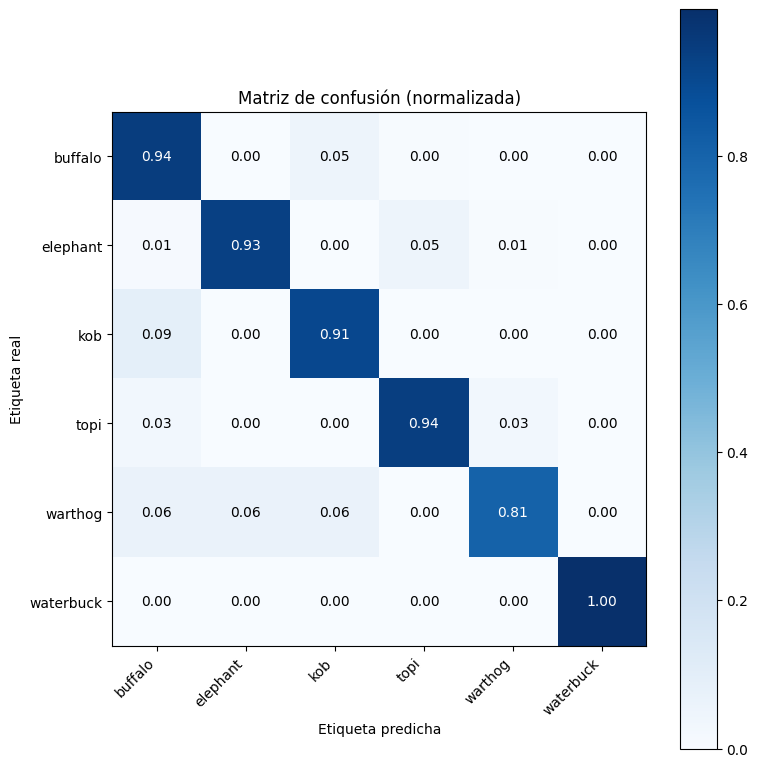

In [180]:
# Benchamark
plot_confusion_matrix(test_evaluator_b.metrics.confusion_matrix, normalize=True)

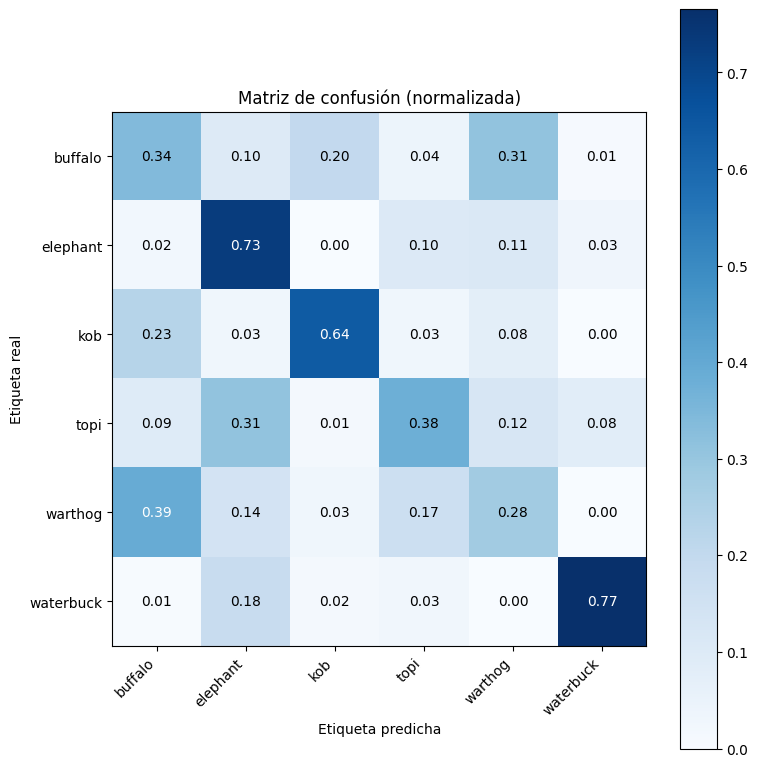

In [181]:
# Mejor modelo
plot_confusion_matrix(test_evaluator.metrics.confusion_matrix, normalize=True)